# Quick synthetic to verify that the code works as intended

In [2]:

import pygmt
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import bordado as bd
import boule as bl
import harmonica as hm
import verde as vd
import pandas as pd
import time
from sklearn.metrics import mean_squared_error
%load_ext line_profiler

import spherical as sph

## Forward modeling

Test the forward modeling functions and see if they make sense.

In [3]:
region = (-60, -30, -40, -10)
grid_coordinates = bd.grid_coordinates(region, spacing=10 / 60, non_dimensional_coords=200)
dipole = (-45, -20, -250e3)
# Regional field
inclination, declination = -30, 0
dipole_moment = hm.magnetic_angles_to_vec(1e17, inclination, declination)
magnetic_field = sph.dipole_magnetic_geodetic(grid_coordinates, dipole, dipole_moment)
total_field_anomaly = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(magnetic_field, inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid



Make a map with PyGMT so we can visually inspect the anomaly. It should have a positive part to the North and negative to the South.

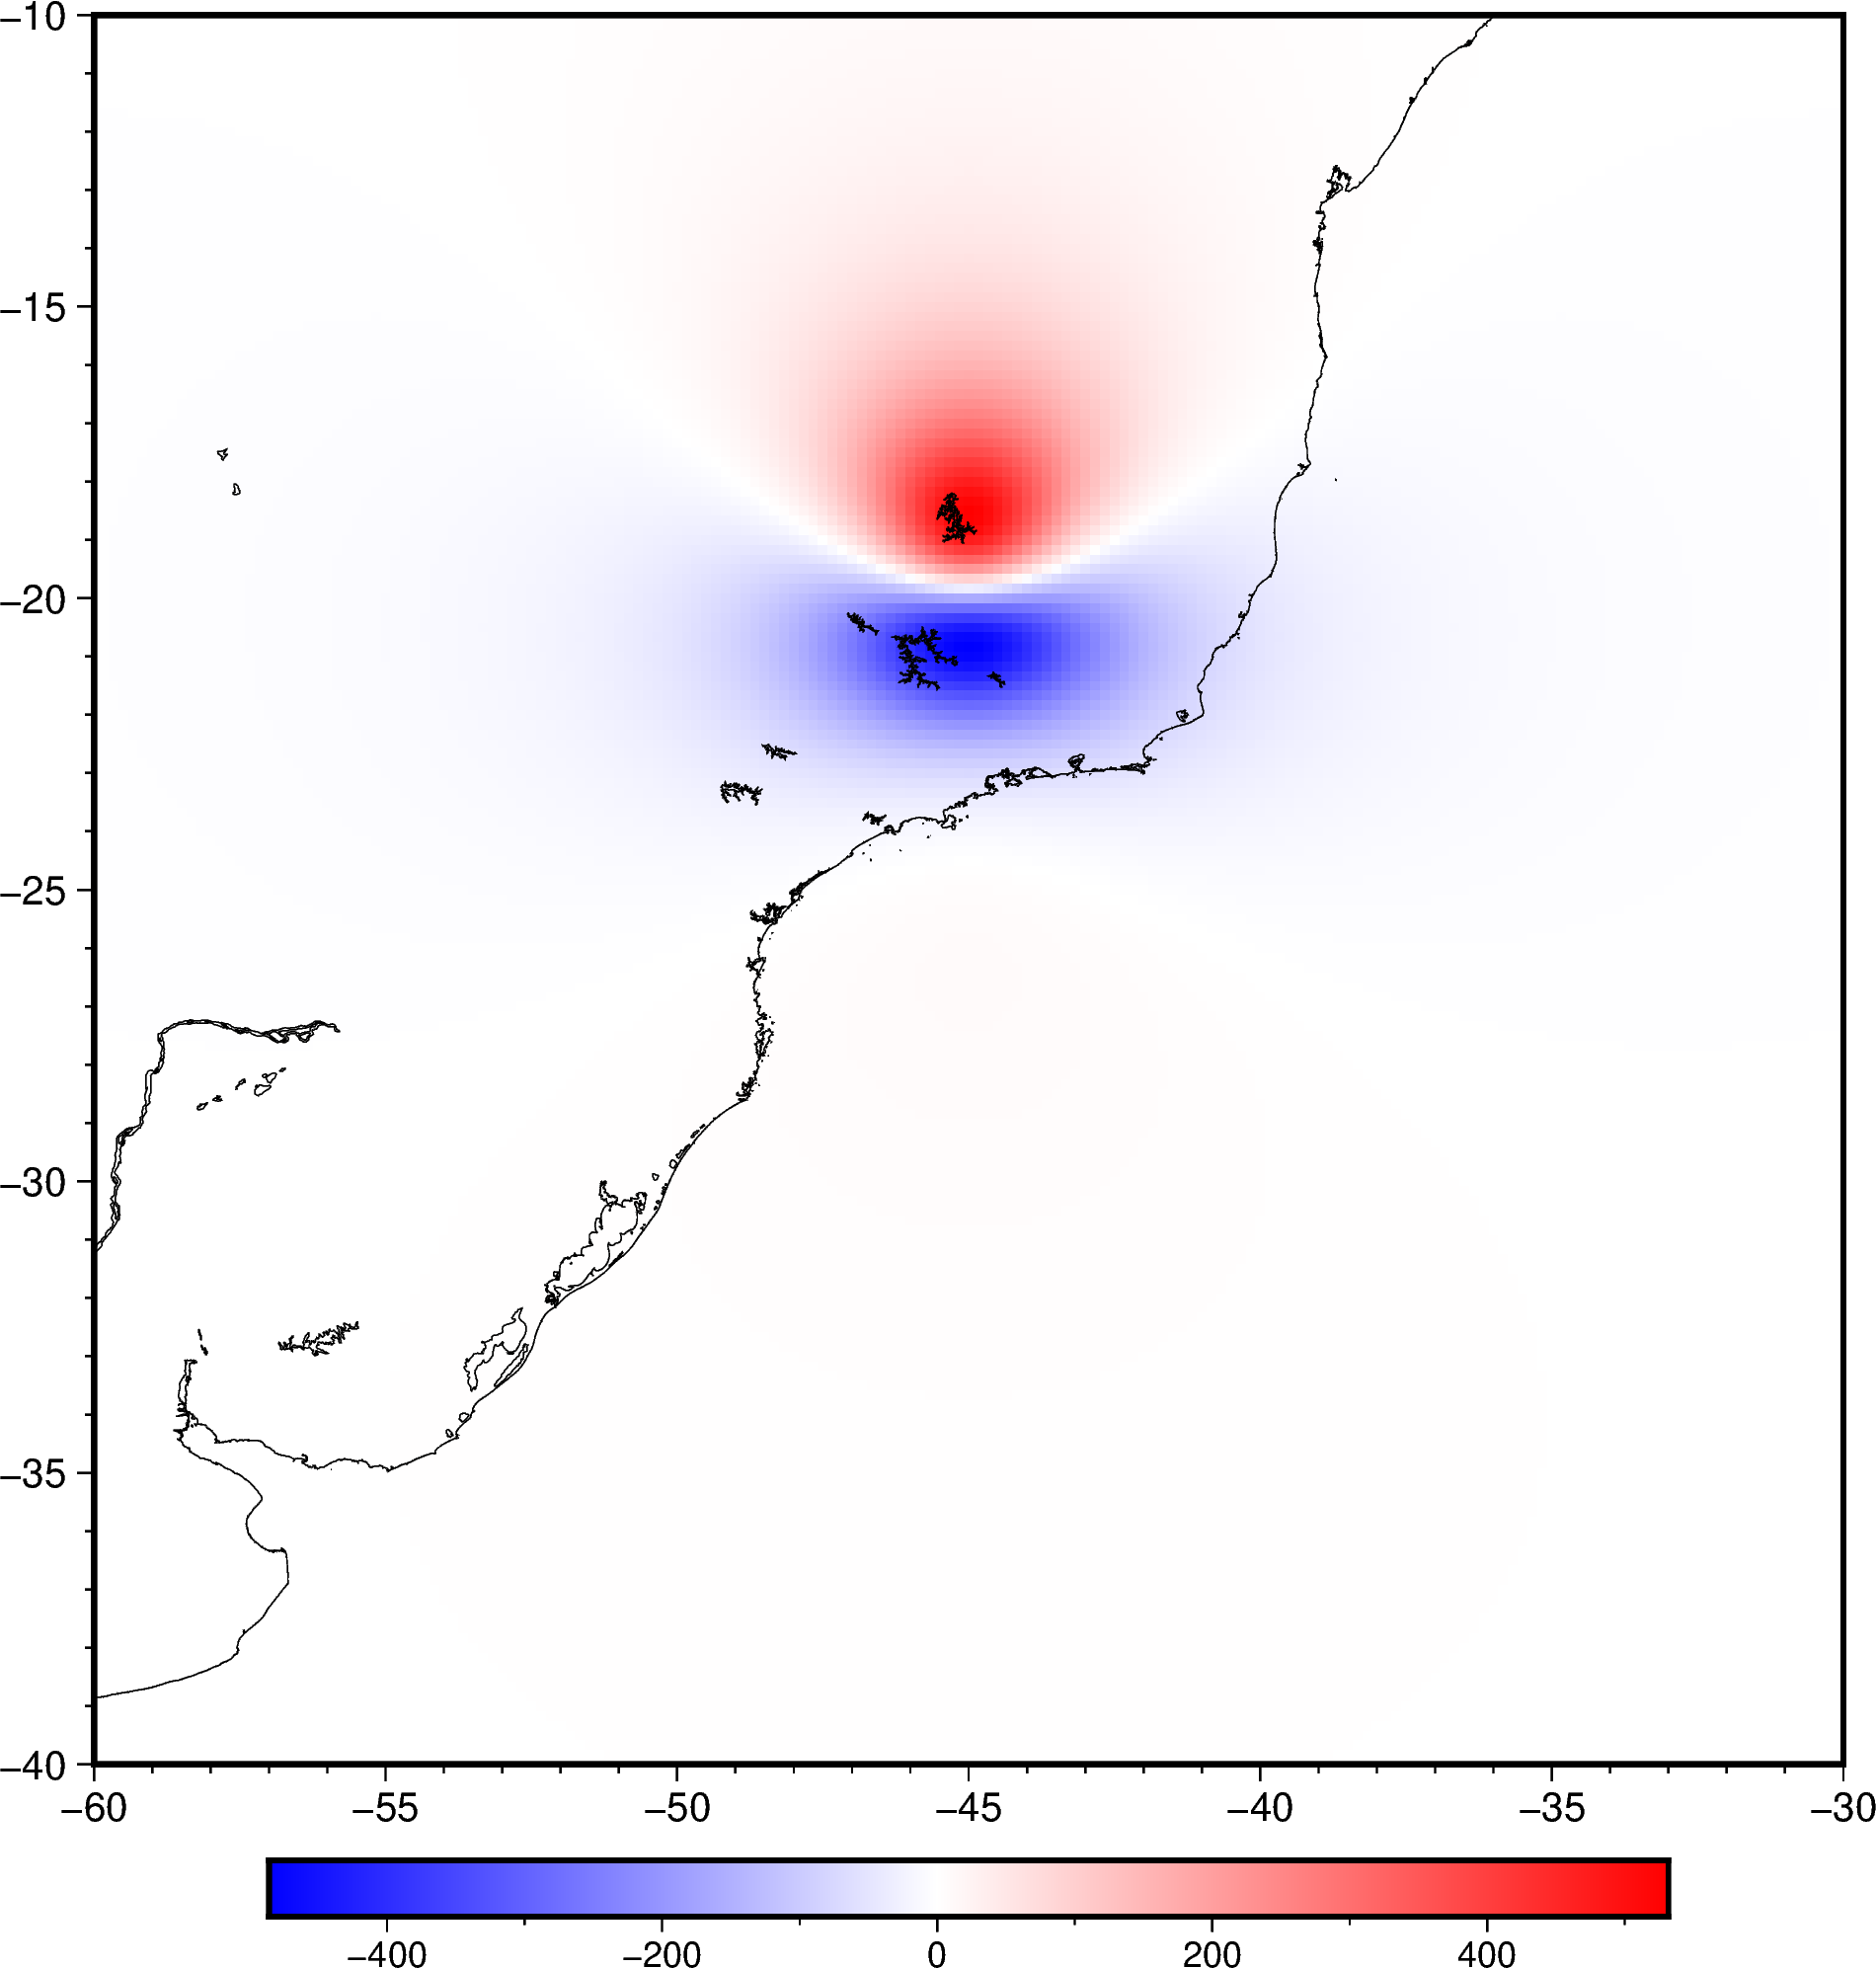

In [4]:
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

## Simple equivalent source inversion

Try recovering the dipole field with a simple single layer inversion.

In [5]:
coordinates = bd.random_coordinates(list(region) + [150, 300], 10000)
magnetic_field_obs = sph.dipole_magnetic_geodetic(coordinates, dipole, dipole_moment)
data = hm.total_field_anomaly(magnetic_field_obs, inclination, declination)
noise_level = 0.02 * vd.maxabs(data)
data += np.random.default_rng(42).normal(0, noise_level, data.shape)
print(noise_level, "nT")

qtd_pontos = data.size
print(f"Quantidade total de pontos para o fit: {qtd_pontos}")

10.491240636816357 nT
Quantidade total de pontos para o fit: 10000


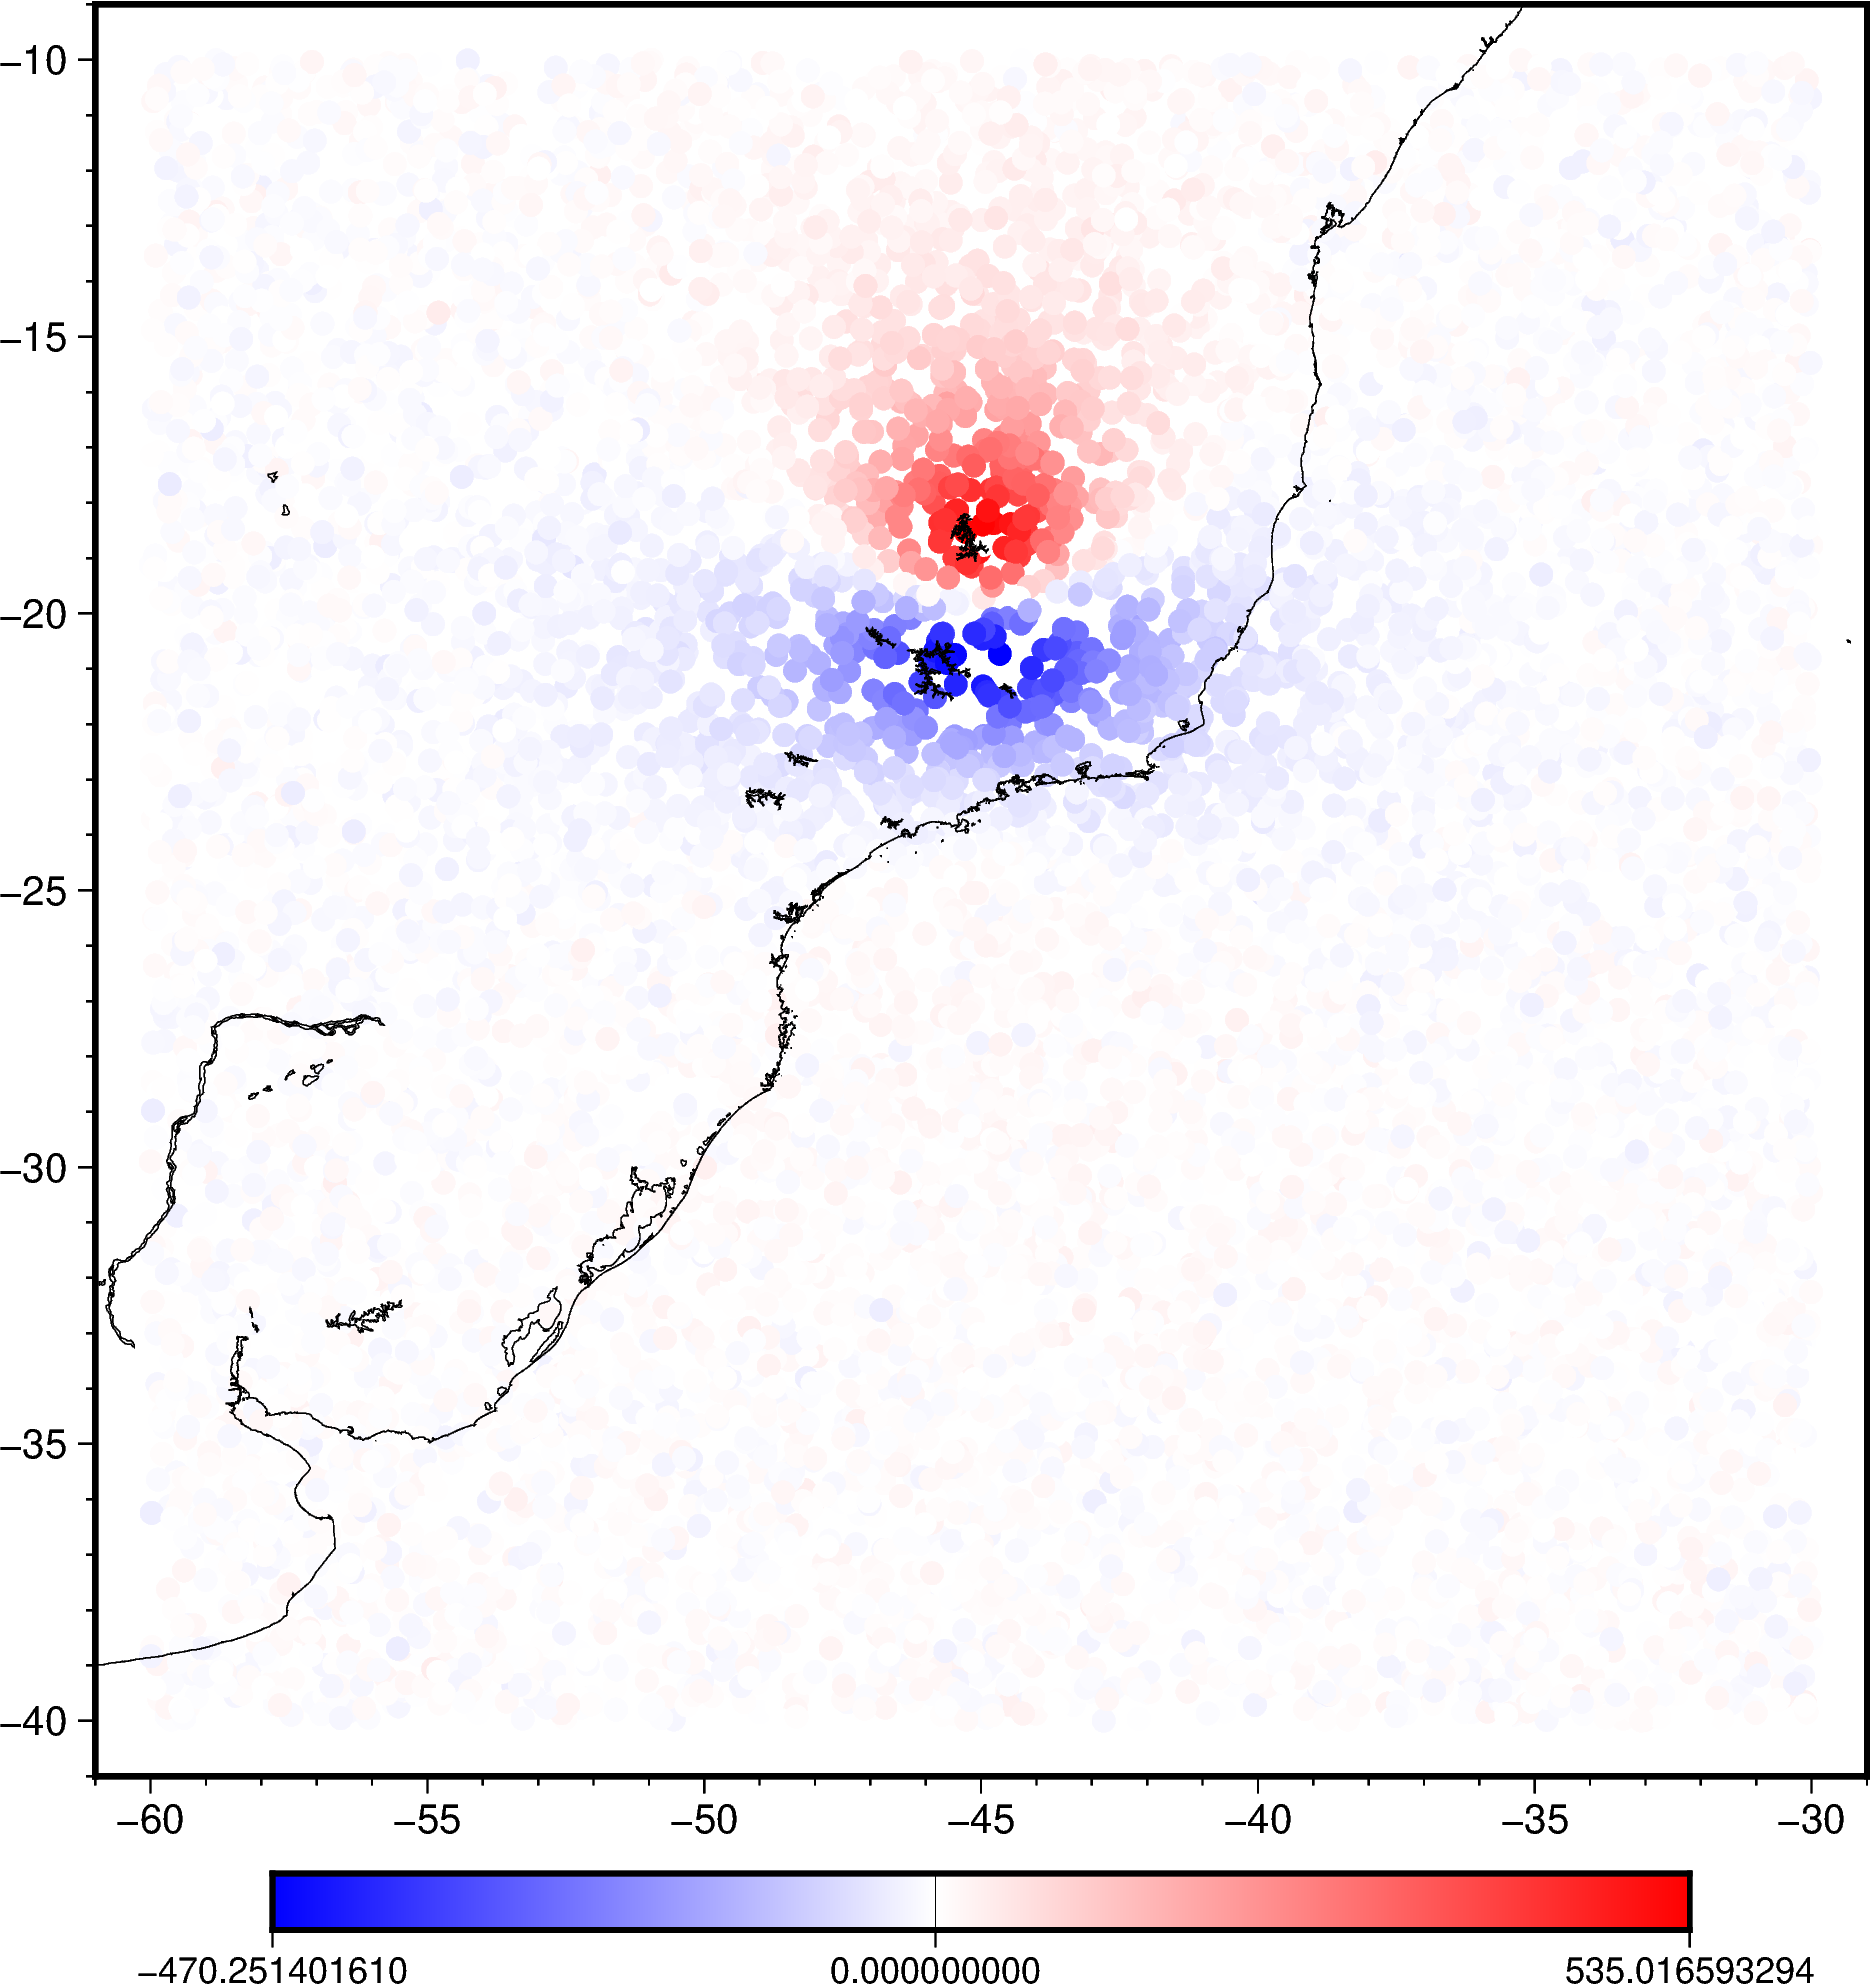

In [6]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h", series=[data.min(), data.max()])
fig.plot(x=coordinates[0], y=coordinates[1], fill=data, style="c0.2c", cmap=True, frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Run the inversion.

In [7]:
%%time
eqs_64 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
%lprun -f sph.EquivalentSourcesMagGeod.fit eqs_64.fit(coordinates, inclination, declination, data)


CPU times: user 2min 40s, sys: 11.4 s, total: 2min 51s
Wall time: 24.1 s


Timer unit: 1e-09 s

Total time: 24.0183 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeod.fit at line 424

Line #      Hits         Time  Per Hit   % Time  Line Contents
   424                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   425                                           
   426                                           
   427                                                   ### ---------- LINHA ALTERADA ------------- ###
   428                                                   # Altera todos os dados para o data type passado por parâmetro
   429         1        784.0    784.0      0.0          if dtype is not None:
   430                                                       coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   431                                                

Run the inversion - 32 bits

In [8]:
%%time
eqs_32 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
%lprun -f sph.EquivalentSourcesMagGeod.fit eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

CPU times: user 1min 27s, sys: 4.36 s, total: 1min 31s
Wall time: 11.7 s


Timer unit: 1e-09 s

Total time: 11.7124 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeod.fit at line 424

Line #      Hits         Time  Per Hit   % Time  Line Contents
   424                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   425                                           
   426                                           
   427                                                   ### ---------- LINHA ALTERADA ------------- ###
   428                                                   # Altera todos os dados para o data type passado por parâmetro
   429         1       2399.0   2399.0      0.0          if dtype is not None:
   430         1    3404211.0  3.4e+06      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   431         1      76087.0  76087.0      0.0       

In [8]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 9


for i in range(n_repeticoes):
    
    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados


[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dt

Versão  Rodada    Duração
0   64 bits       2  48.714272
1   64 bits       3  43.125155
2   64 bits       4  44.270325
3   64 bits       5  44.337618
4   64 bits       6  44.298248
5   64 bits       7  43.212948
6   64 bits       8  41.687750
7   64 bits       9  44.905770
8   32 bits       2  19.804892
9   32 bits       3  19.207550
10  32 bits       4  20.561998
11  32 bits       5  20.572568
12  32 bits       6  20.553205
13  32 bits       7  20.756847
14  32 bits       8  21.341202
15  32 bits       9  20.774410

Plotting the statistics


In [9]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Comparação de Desempenho (Medições Individuais)')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_1.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('Comparação de Desempenho do Spline.fit() por Precisão do Dado')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_1.png") descomentar para salvar imagem
plt.show()

NameError: name 'df_resultados' is not defined

Calculate and plot the residuals.

64 bits


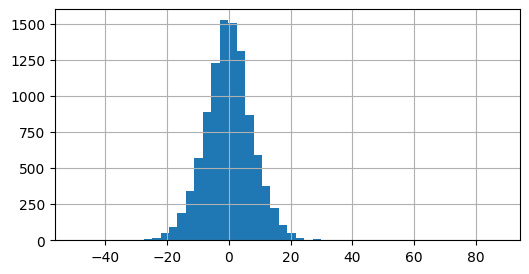

32 bits


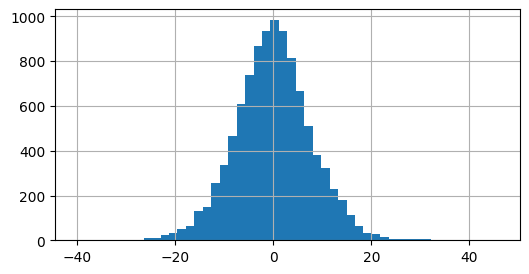

In [9]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

In [10]:
total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

tamanho_grid = total_field_anomaly_predicted_64.size
print(f"Tamanho do grid resultante: {tamanho_grid}")

Tamanho do grid resultante: 32761


64 bits


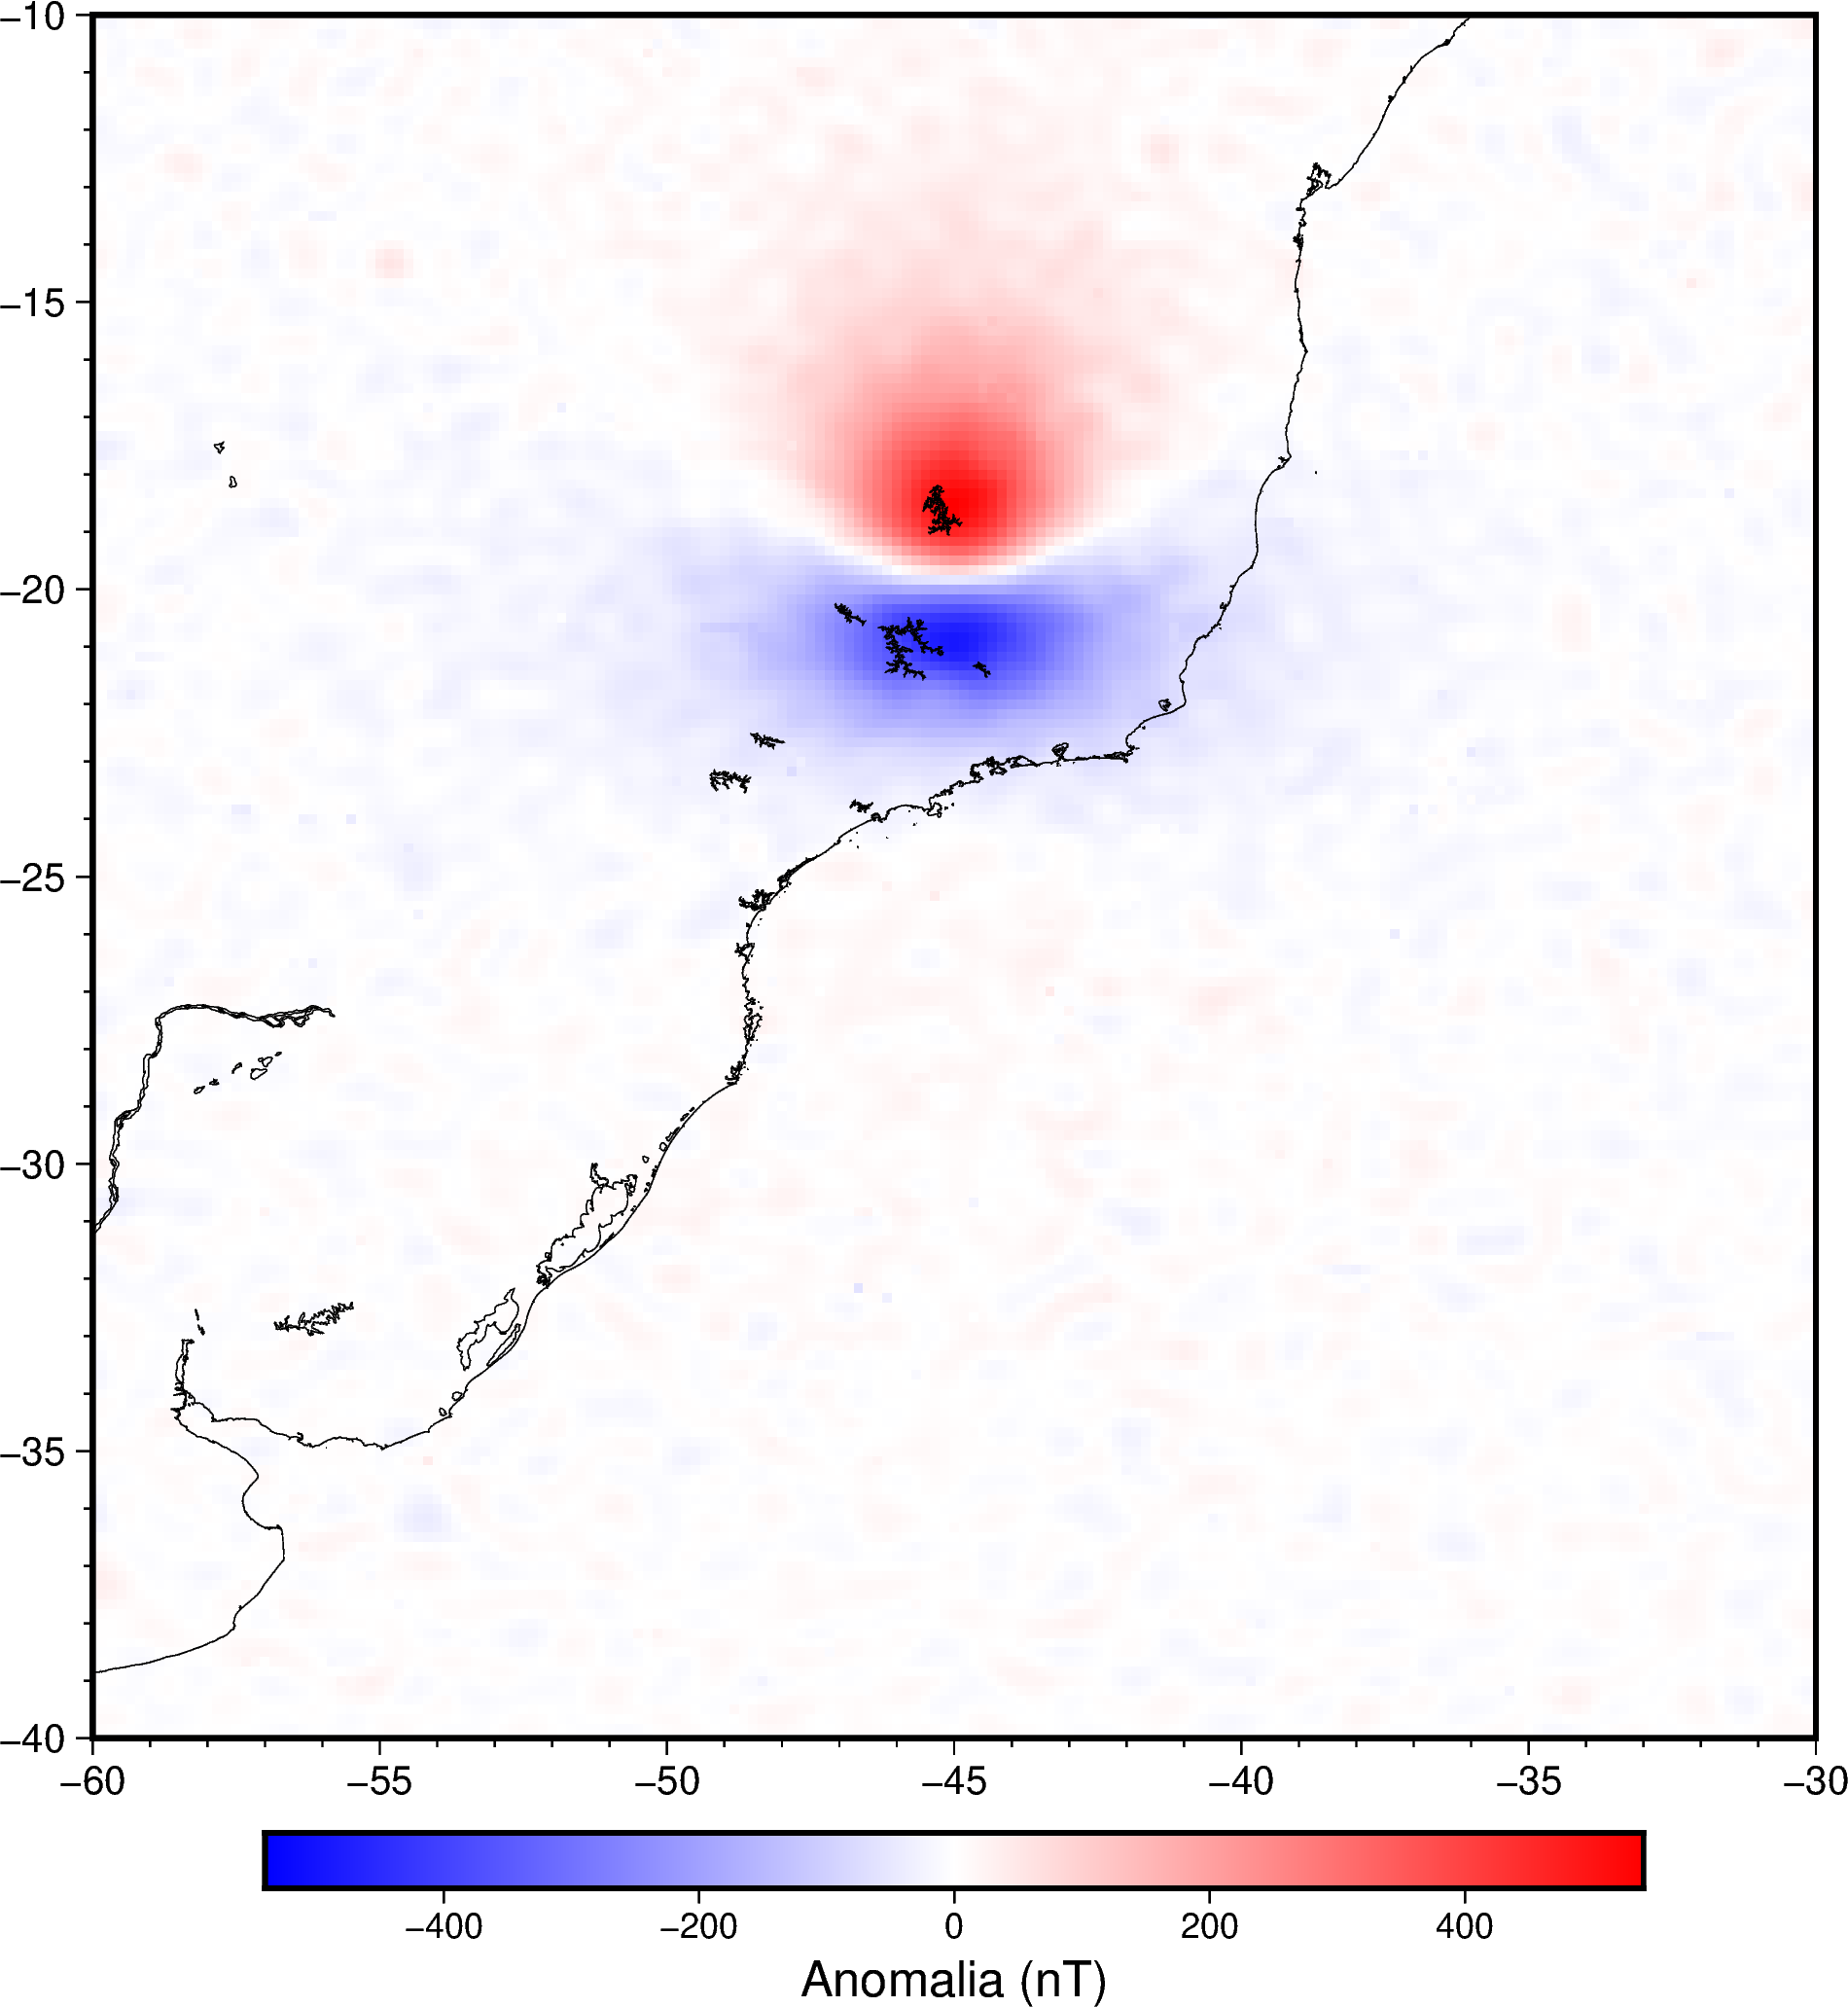

32 bits


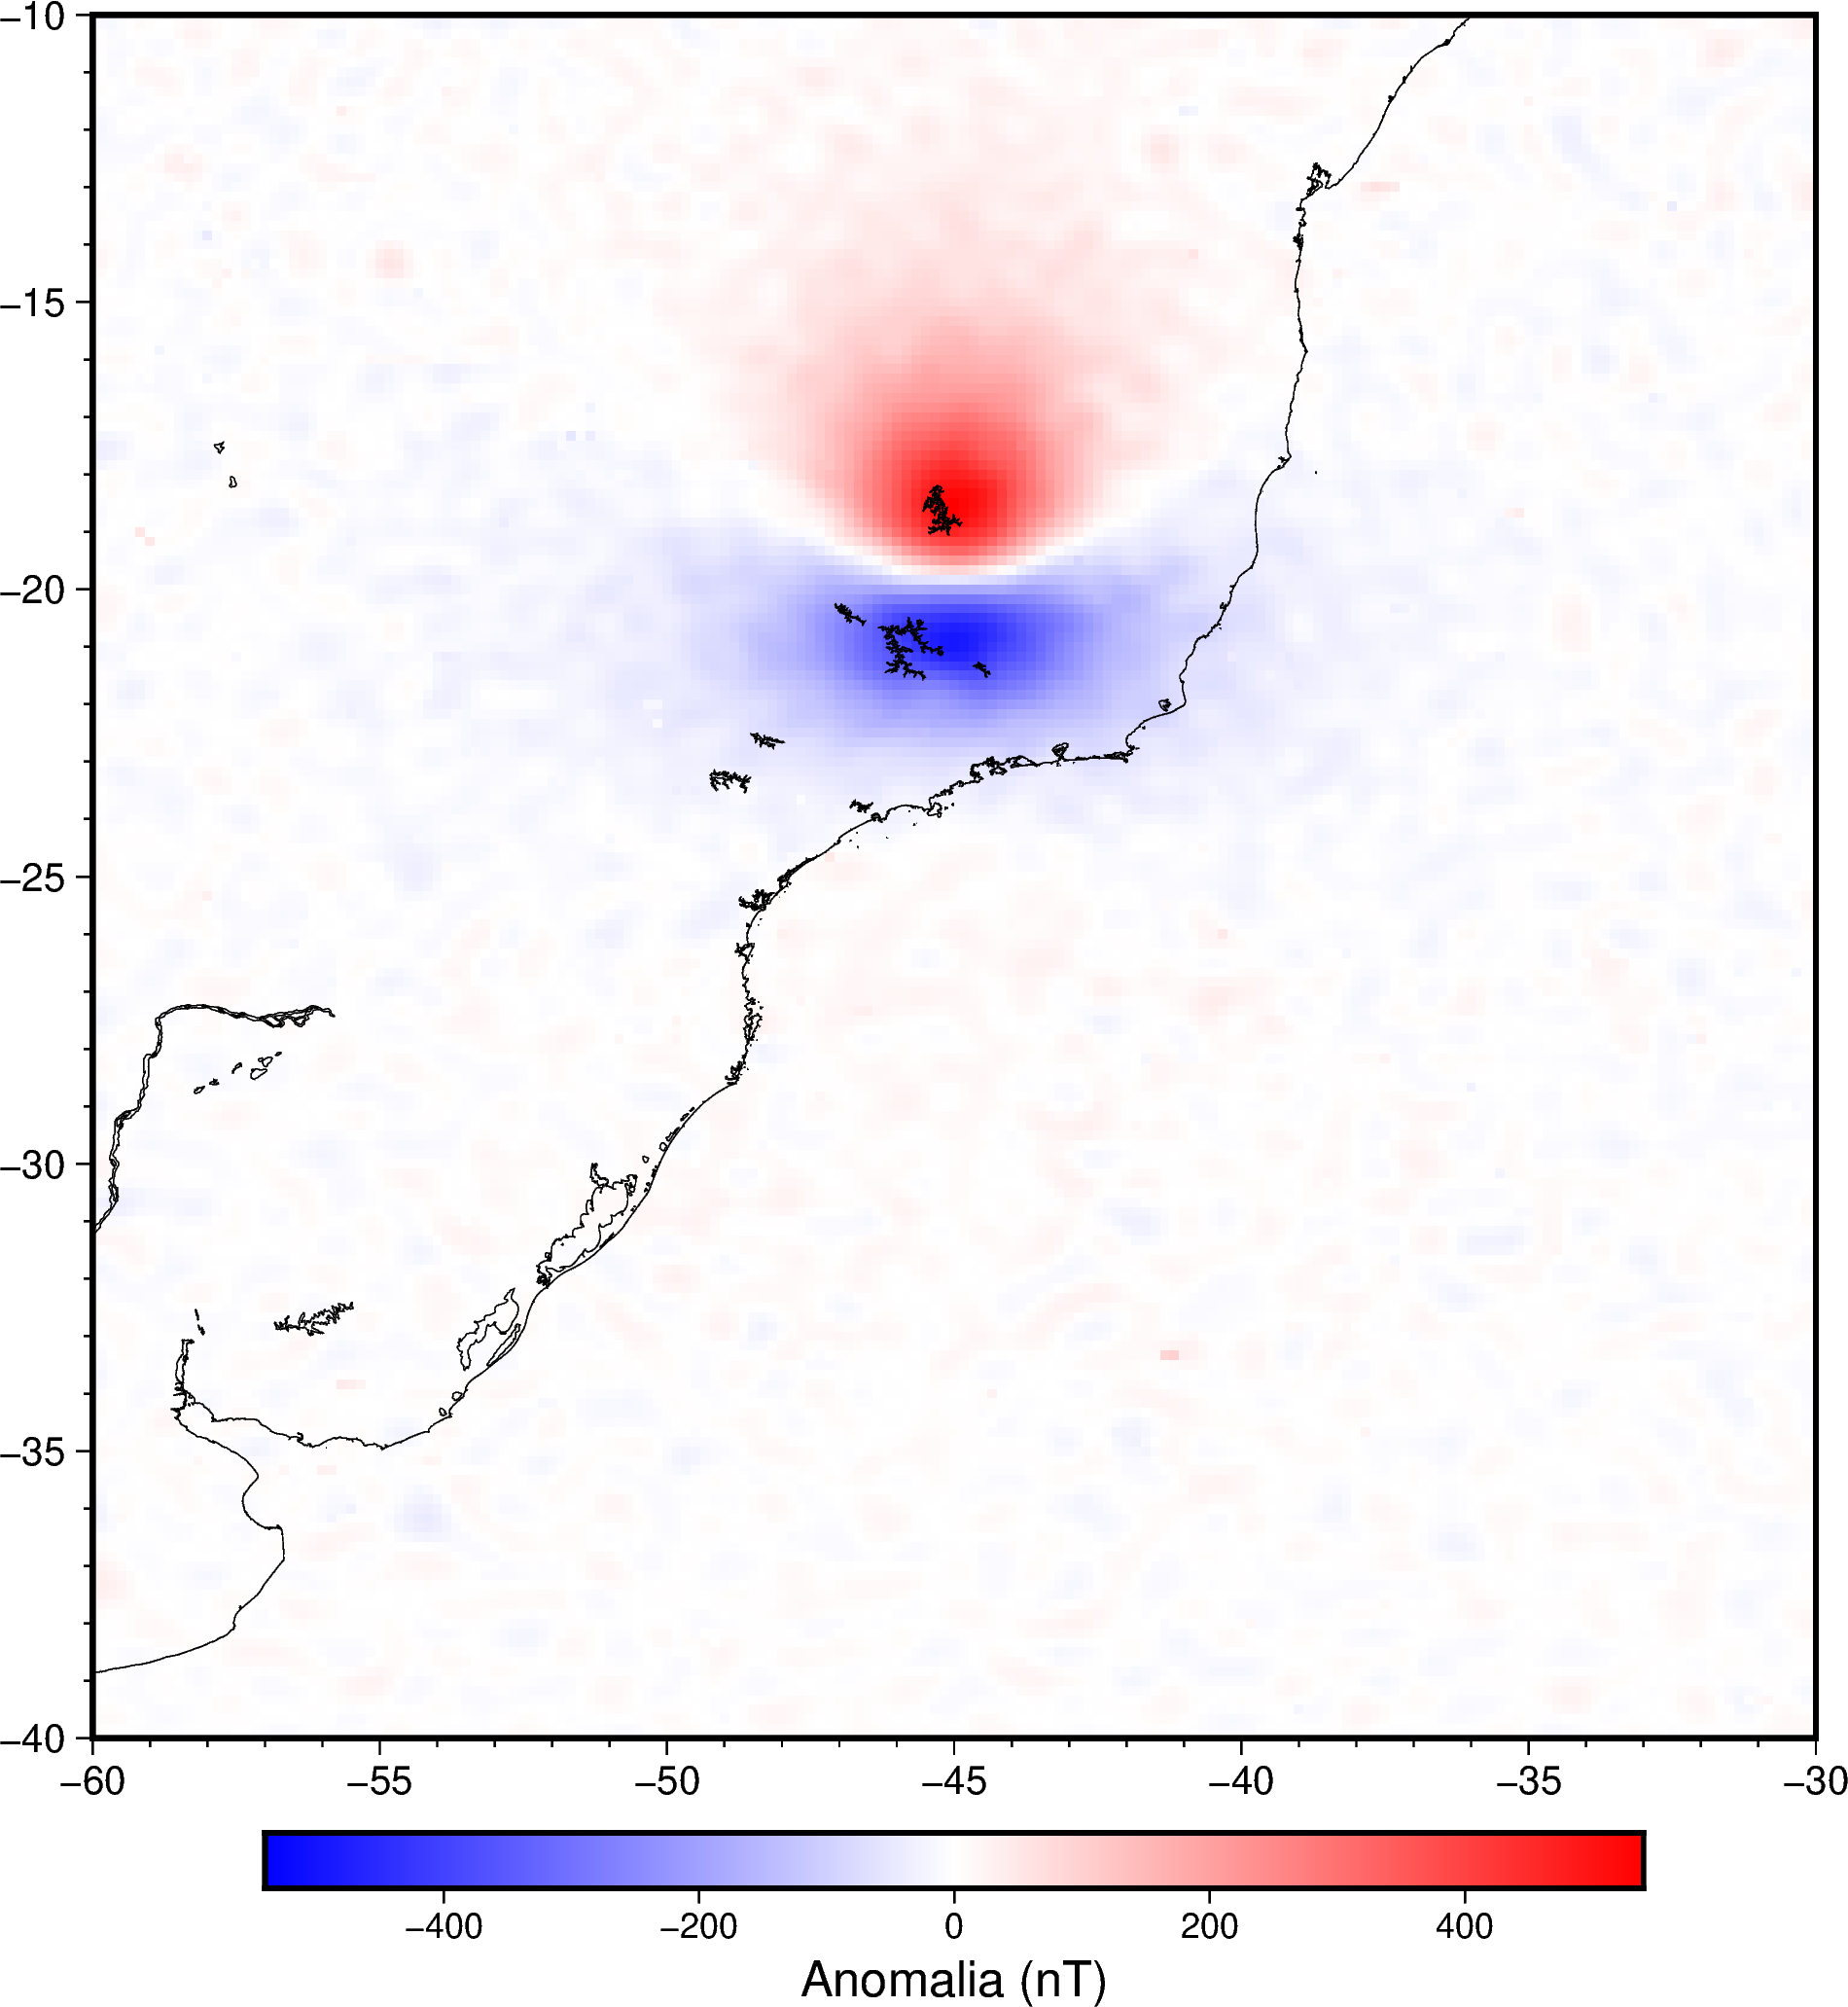

In [11]:
# Encontrar o limite global da escala
# Calculamos o máximo absoluto entre os dois mapas para garantir que a escala cubra tudo
max_abs_64 = np.nanmax(np.abs(total_field_anomaly_predicted_64))
max_abs_32 = np.nanmax(np.abs(total_field_anomaly_predicted_32))

# O limite será o maior valor encontrado
limite_global = max(max_abs_64, max_abs_32)


# Criar e salvar o arquivo de cores (CPT)
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_global, limite_global], 
    background=True,
    output="escala.cpt"
)

# --- Plot 64 bits ---
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(
    total_field_anomaly_predicted_64, 
    cmap="escala.cpt",
    frame=True
)
fig.colorbar(cmap="escala.cpt", frame=["a", "x+lAnomalia (nT)"])
fig.coast(shorelines=True)
fig.show()

# --- Plot 32 bits ---
print("32 bits")
fig = pygmt.Figure()
fig.grdimage(
    total_field_anomaly_predicted_32, 
    cmap="escala.cpt", 
    frame=True
)
fig.colorbar(cmap="escala.cpt", frame=["a", "x+lAnomalia (nT)"])
fig.coast(shorelines=True)
fig.show()

Mapa de Diferença (64 bits vs 32 bits)


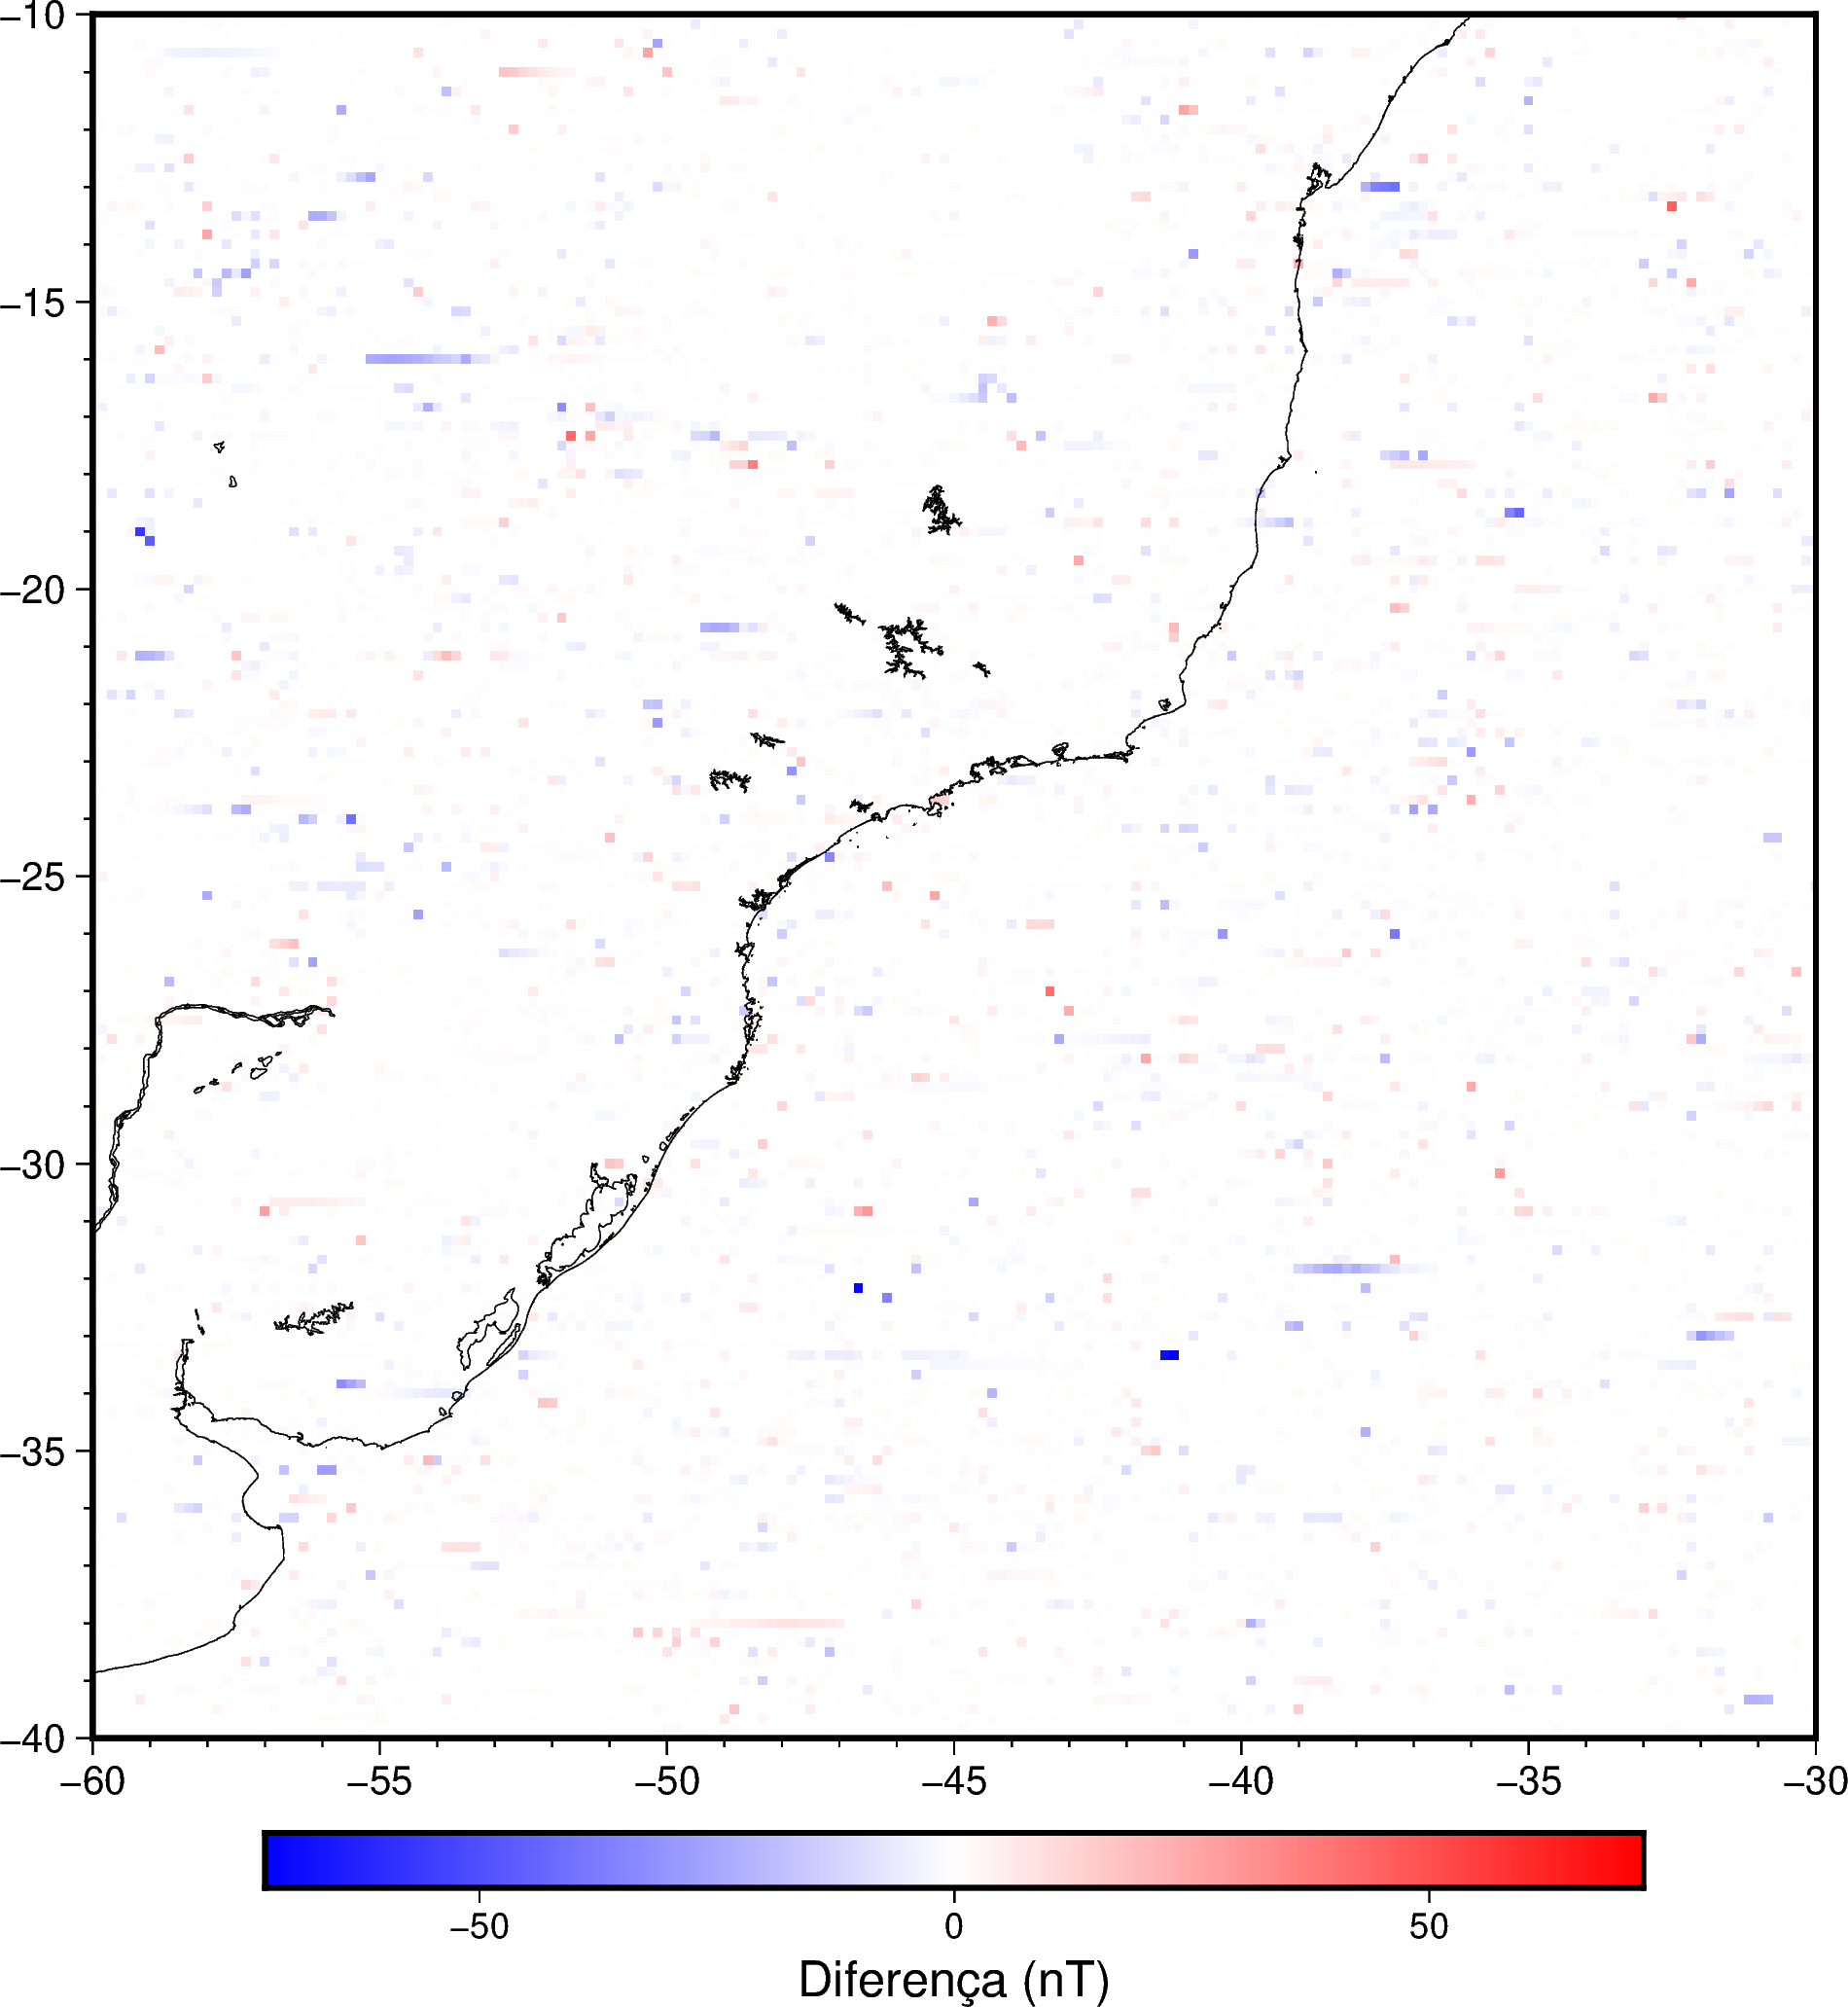

In [12]:
# Diferença entre o grid calculdado com 64 e 32 bits.

# Calcular o Grid da Diferença (64 bits - 32 bits)
# Isso mostra onde a precisão foi perdida ou alterada
diff_bits = total_field_anomaly_predicted_64 - total_field_anomaly_predicted_32

# Calcular a escala automática para essa diferença
# Usamos o máximo absoluto para garantir que o zero fique no centro (branco)
limite_diff = np.nanmax(np.abs(diff_bits))

# Criar e salvar o CPT específico para essa diferença
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_diff, limite_diff], 
    background=True,
    output="escala.cpt"
)

# 4. Plotar
print("Mapa de Diferença (64 bits vs 32 bits)")
fig = pygmt.Figure()
fig.grdimage(
    diff_bits, 
    cmap="escala.cpt", 
    frame=True
)
fig.colorbar(
    cmap="escala.cpt", 
    frame=["a", "x+lDiferença (nT)"]
)
fig.coast(shorelines=True)
fig.show()

Diferença de precisão

In [13]:
# --- 1. Extração dos Dados Numéricos ---

valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---

mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")


media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: 5.2338693690268006
A Raiz do Erro Quadrático Médio (RMSE) é: 2.2878 nT
O erro dividido pela média dos valores absolutos dos dados é: 0.1171038571050393


Proporção entre quantidade de pontos de entrada e tamanho do grid

In [14]:
pontos_entrada = len(data)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)

10000
32761


Show the difference.

64 bits


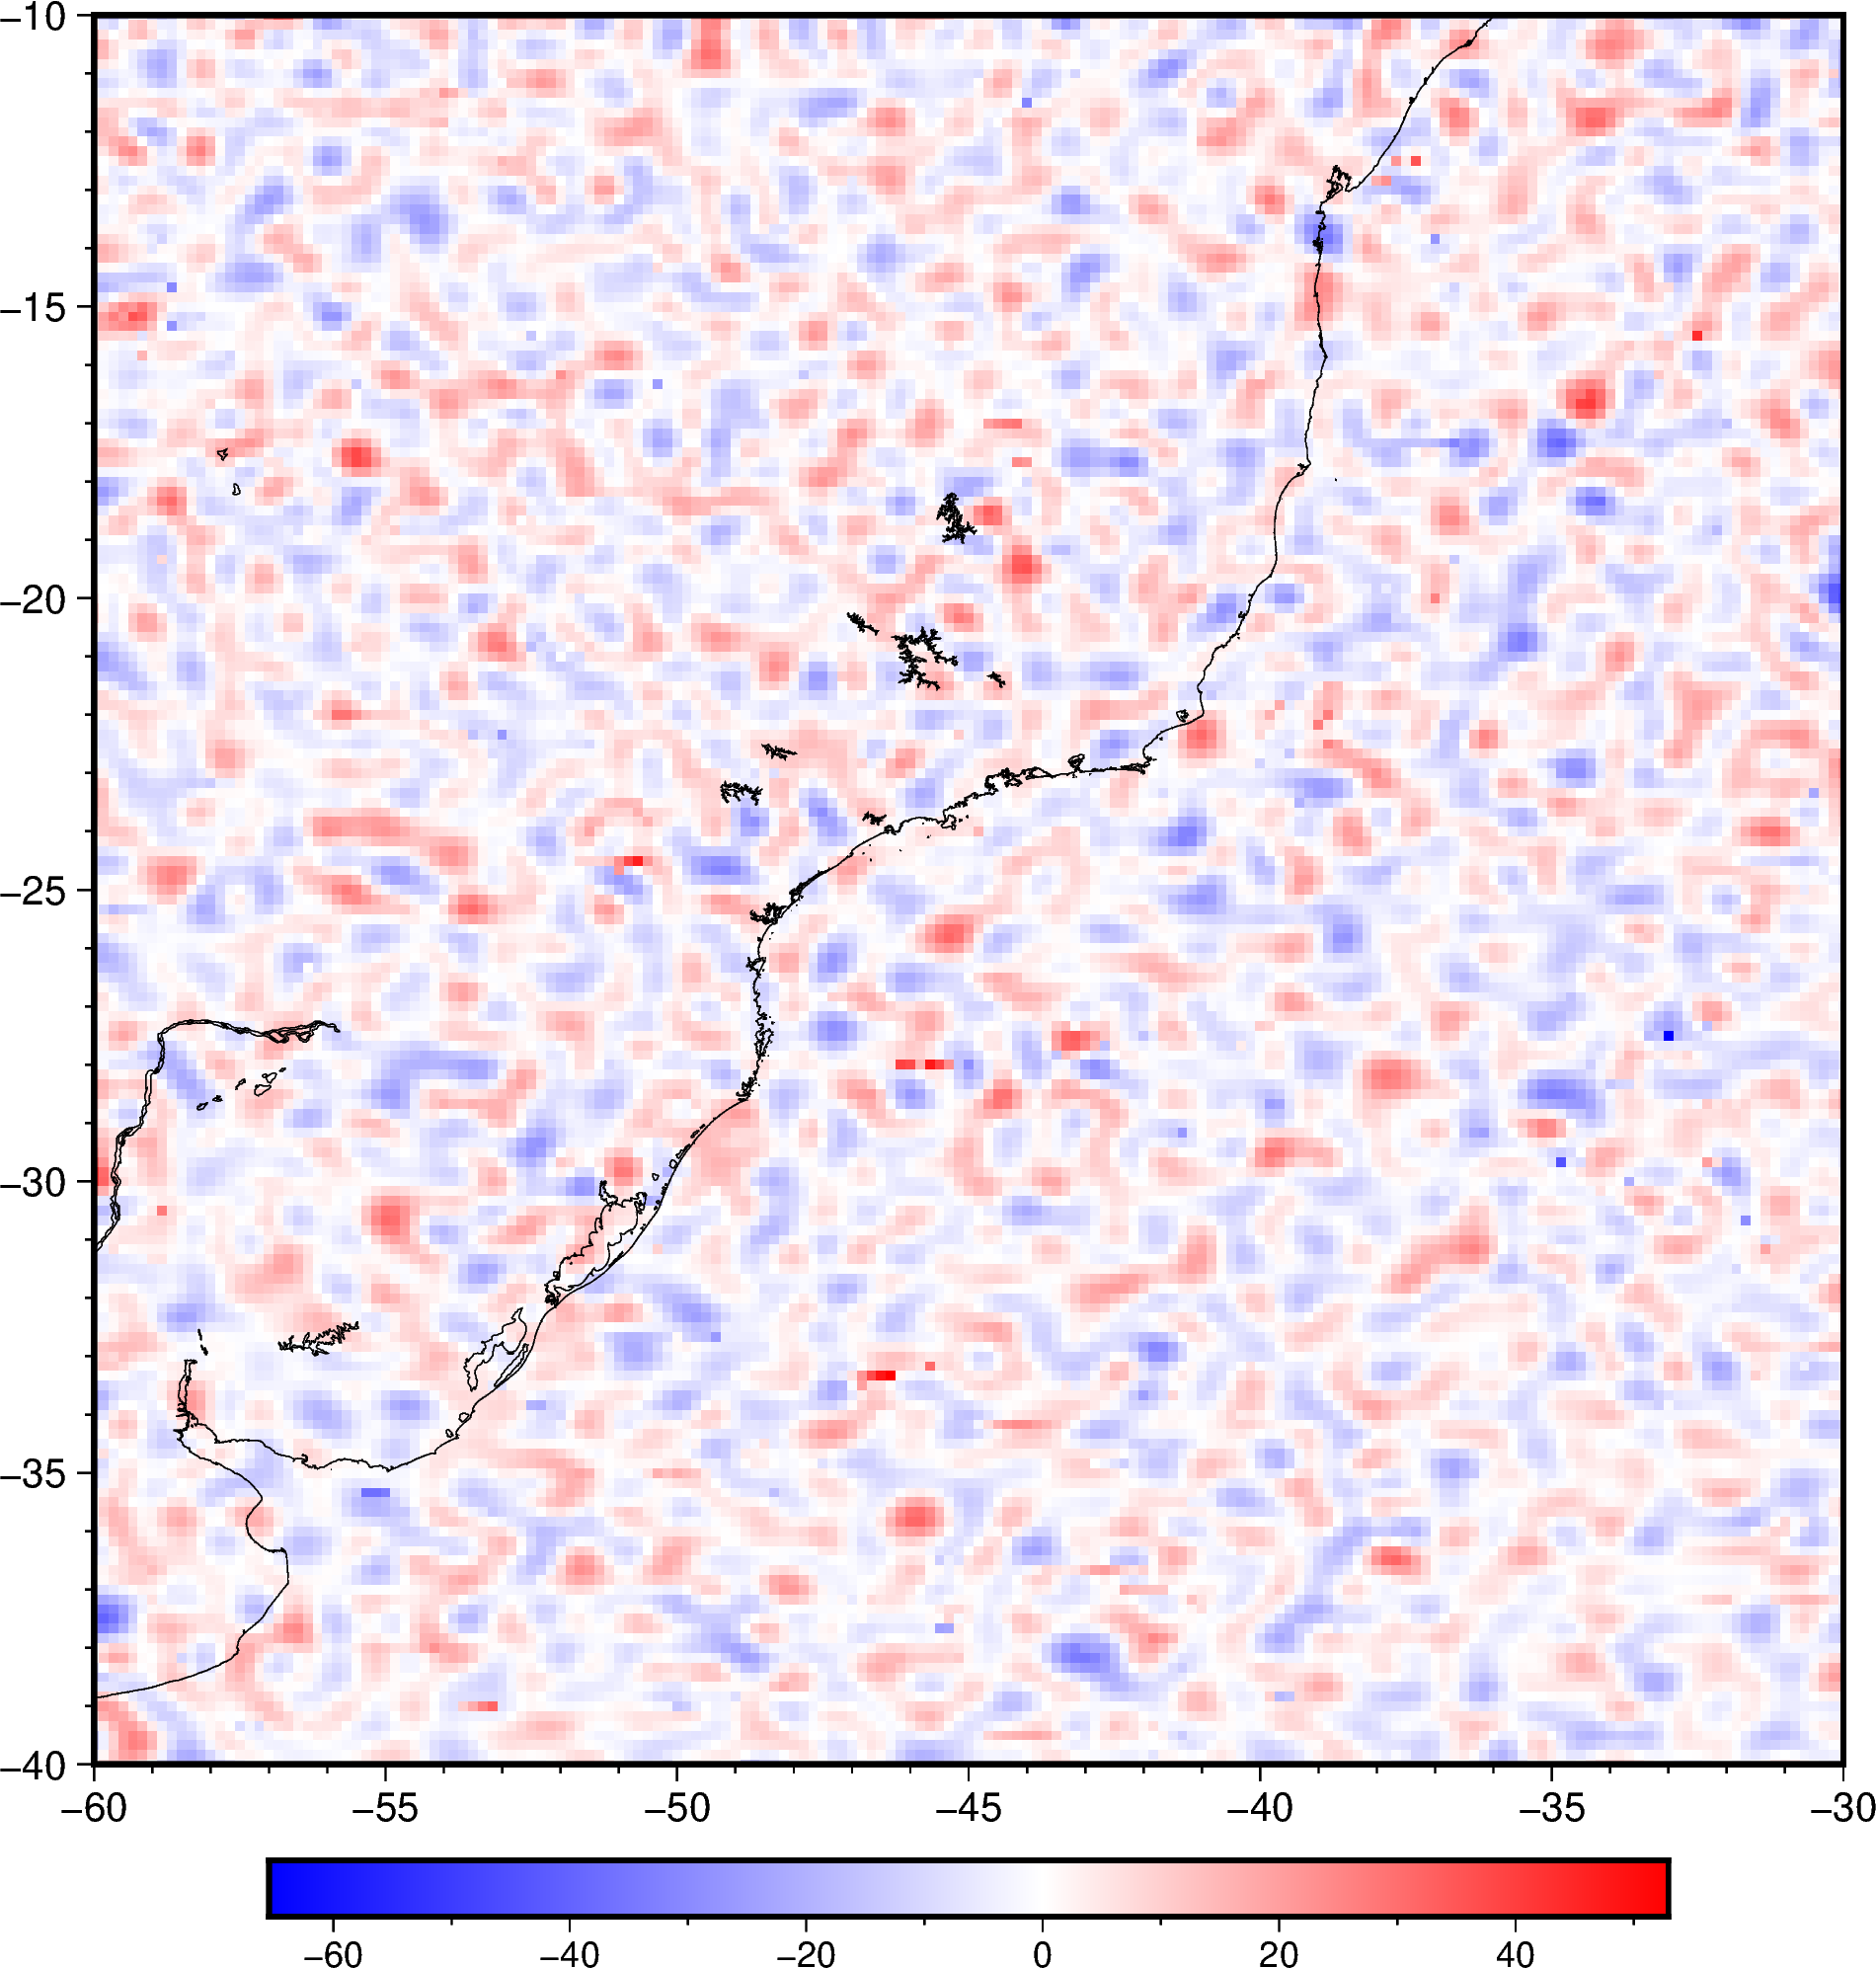

32 bits


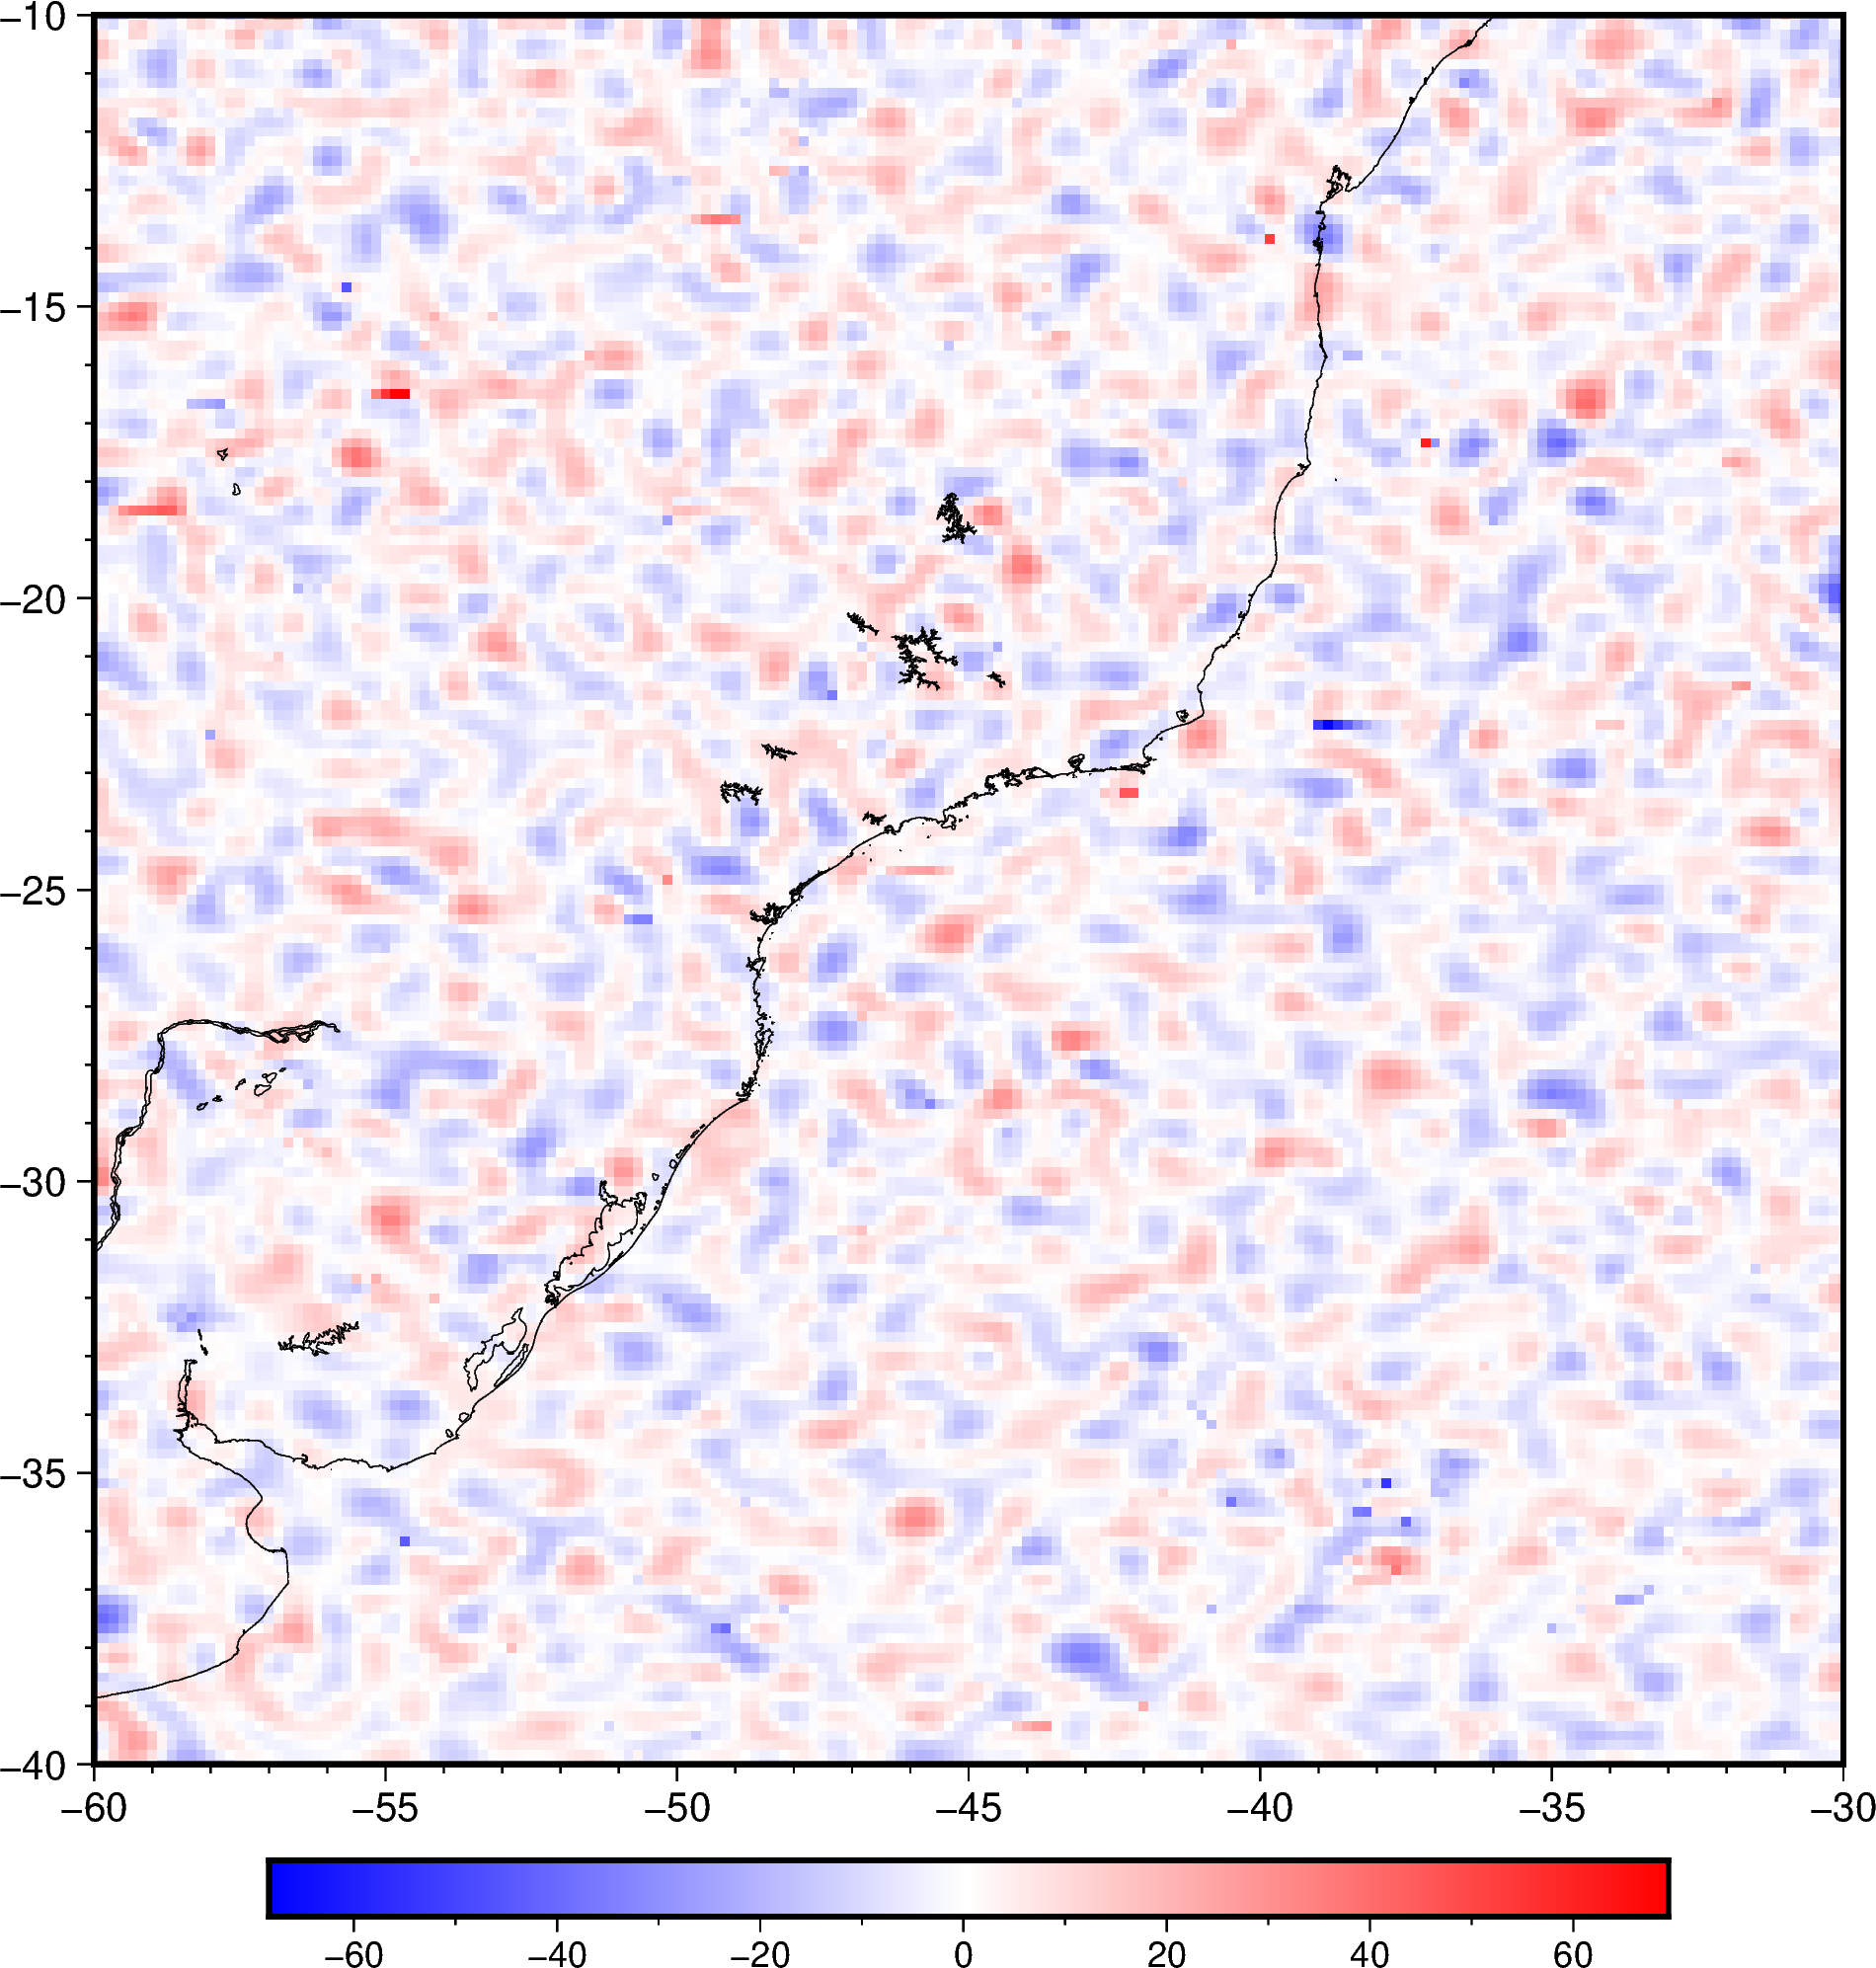

In [14]:
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_64, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_32, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

## Gradient-boosting

obs: Mesma proporção de pontos de entrada para pontos no grid.

In [15]:
%%time
eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3, window_size=1000e3)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_64.fit(coordinates, inclination, declination, data, dtype="float64")

Output()

CPU times: user 1min 56s, sys: 434 ms, total: 1min 57s
Wall time: 12.2 s


Timer unit: 1e-09 s

Total time: 12.2355 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       1314.0   1314.0      0.0          if dtype is not None:
   551         1      21549.0  21549.0      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552         1        635.0    635.0      0.0              data = np.asarray(data, dtype=dtype)
   5

In [16]:
%%time
eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3, window_size=1000e3)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

Output()

CPU times: user 1min 24s, sys: 183 ms, total: 1min 24s
Wall time: 10.1 s


Timer unit: 1e-09 s

Total time: 10.1262 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1        854.0    854.0      0.0          if dtype is not None:
   551         1     220153.0 220153.0      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552         1     378817.0 378817.0      0.0              data = np.asarray(data, dtype=dtype)
   5

In [17]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 9


for i in range(n_repeticoes):
    
    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados


Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64

[DEBUG least_squares] Resultado (regr.coef_) dtype: float64

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

Output()

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float32

[DEBUG least_squares] Resultado (regr.coef_) dtype: float32

[DEBUG least_squares] Params finais dtype: float64


--- Estatísticas Descritivas por Versão ---
         count       mean       std        min        25%        50%  \
Versão                                                                 
32 bits    8.0  20.012858  3.072980  17.866618  18.021370  18.279750   
64 bits    8.0  31.470964  0.445137  30.841407  31.153837  31.492927   

               75%        max  
Versão                         
32 bits  21.069393  25.282720  
64 bits  31.720686  32.231736  


Versão  Rodada    Duração
0   64 bits       2  31.564214
1   64 bits       3  31.047690
2   64 bits       4  30.841407
3   64 bits       5  31.189219
4   64 bits       6  31.421639
5   64 bits       7  31.766343
6   64 bits       8  32.231736
7   64 bits       9  31.705467
8   32 bits       2  24.434639
9   32 bits       3  25.282720
10  32 bits       4  19.947645
11  32 bits       5  18.506722
12  32 bits       6  17.866618
13  32 bits       7  18.036867
14  32 bits       8  17.974878
15  32 bits       9  18.052778

Plotting the statistics


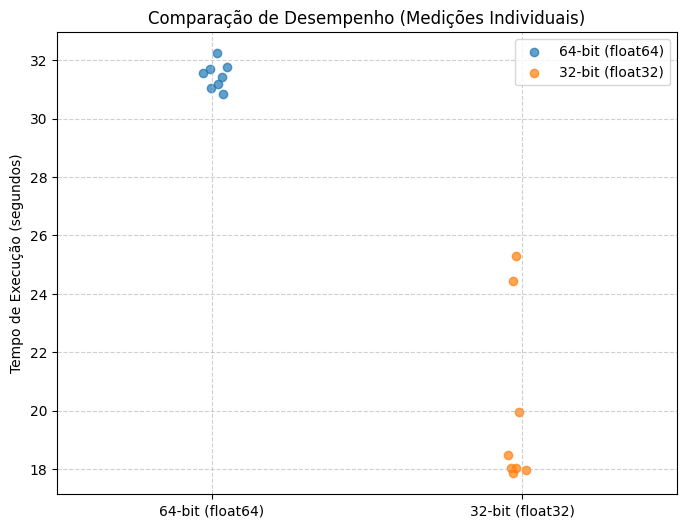

/tmp/ipykernel_5935/2717439439.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


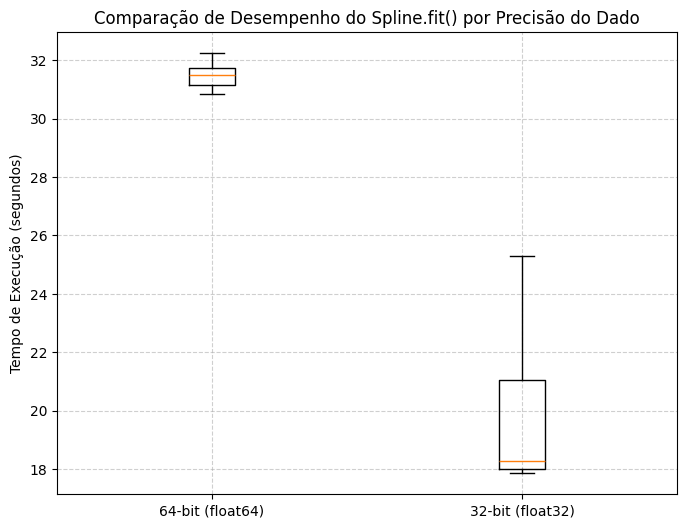

In [18]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Comparação de Desempenho (Medições Individuais)')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_2.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('Comparação de Desempenho do Spline.fit() por Precisão do Dado')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_2.png") descomentar para salvar imagem
plt.show()

Calculate and plot the residuals.

64 bits


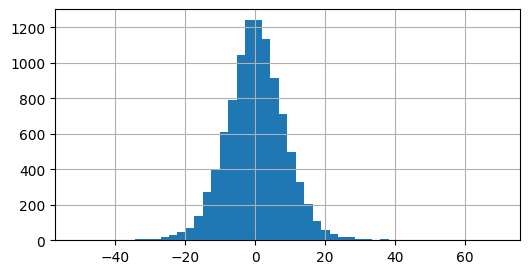

32 bits


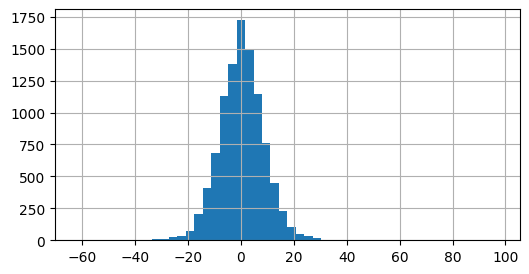

In [19]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()


print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

Predict on a grid.

In [21]:

total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid


total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

64 bits


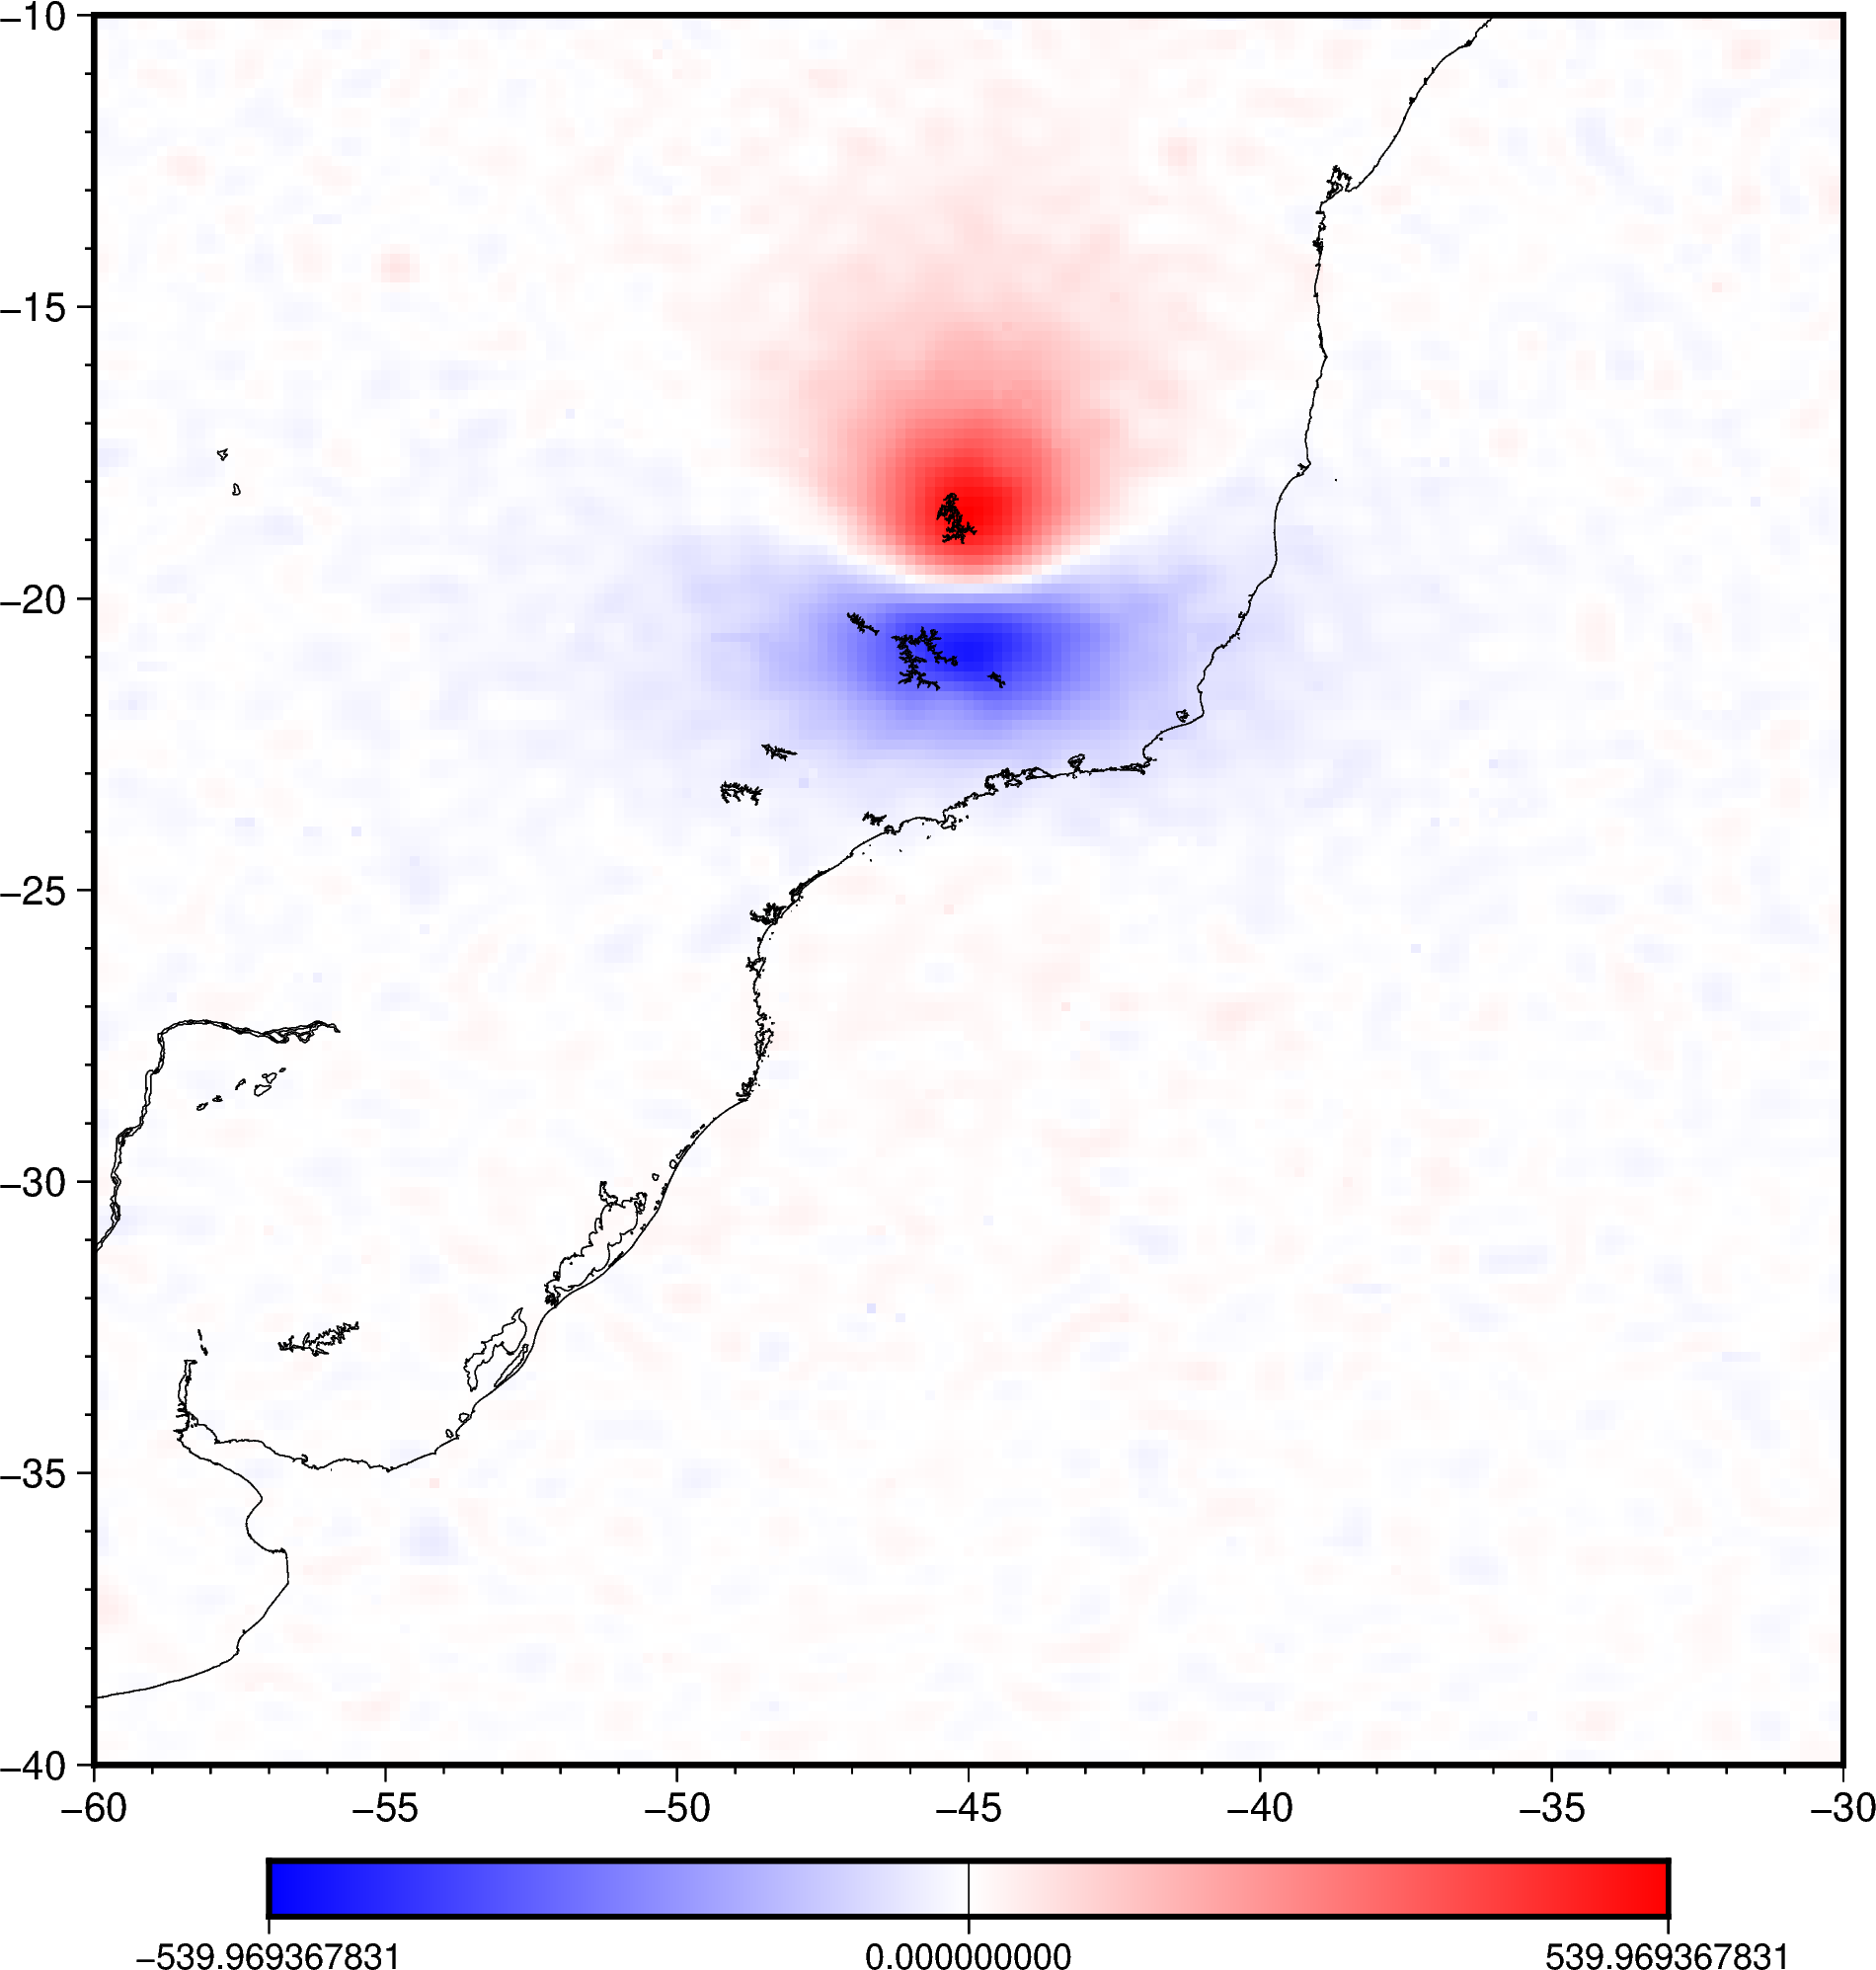

32 bits


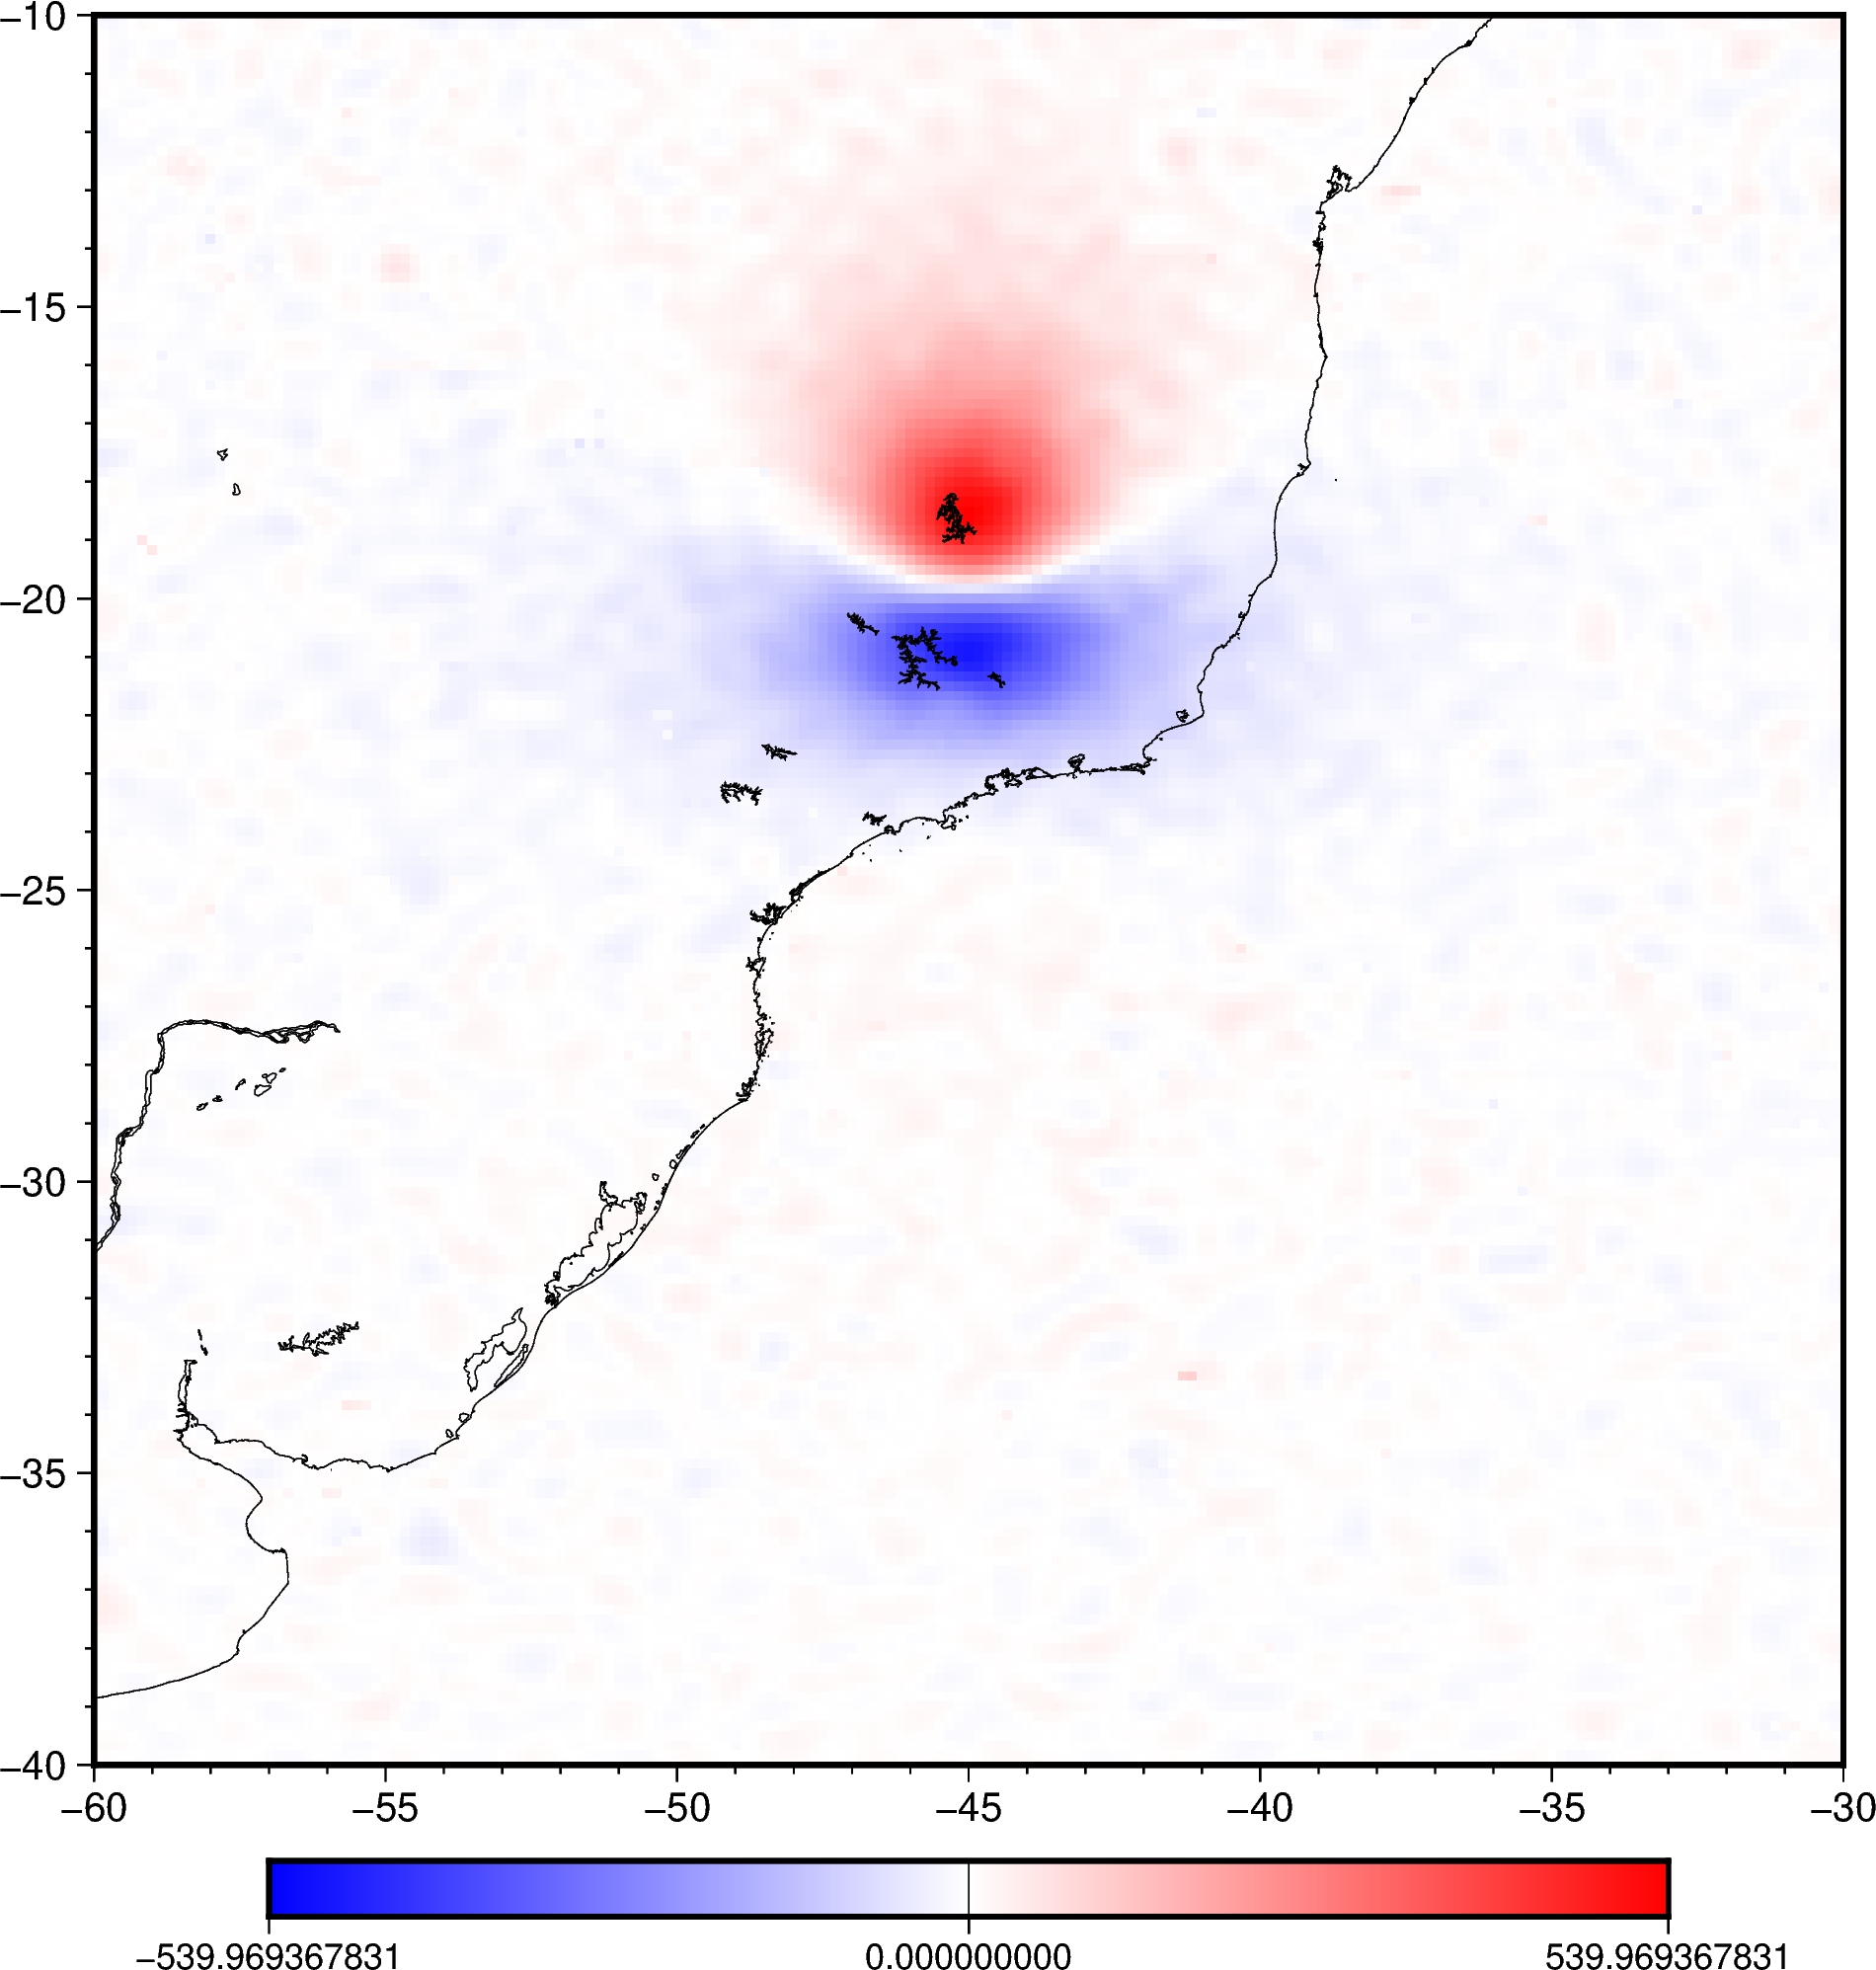

In [17]:
# Encontrar o teto da escala (Máximo valor Absoluto Global)
# Isso garante que o zero seja branco e os extremos (positivo/negativo) tenham a mesma intensidade
max_erro_64 = np.nanmax(np.abs(total_field_anomaly_predicted_64))
max_erro_32 = np.nanmax(np.abs(total_field_anomaly_predicted_32))
limite_escala = max(max_erro_64, max_erro_32)


# Criar e salvar o arquivo de cores (CPT)
pygmt.makecpt(
    cmap="polar+h",
    series=[-limite_escala, limite_escala],
    background=True,
    output="escala.cpt"
)

# --- Plot 64 bits ---
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_64, cmap="escala.cpt", frame=True)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

# --- Plot 32 bits ---
print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_32, cmap="escala.cpt", frame=True)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

Mapa de Diferença (64 bits vs 32 bits)


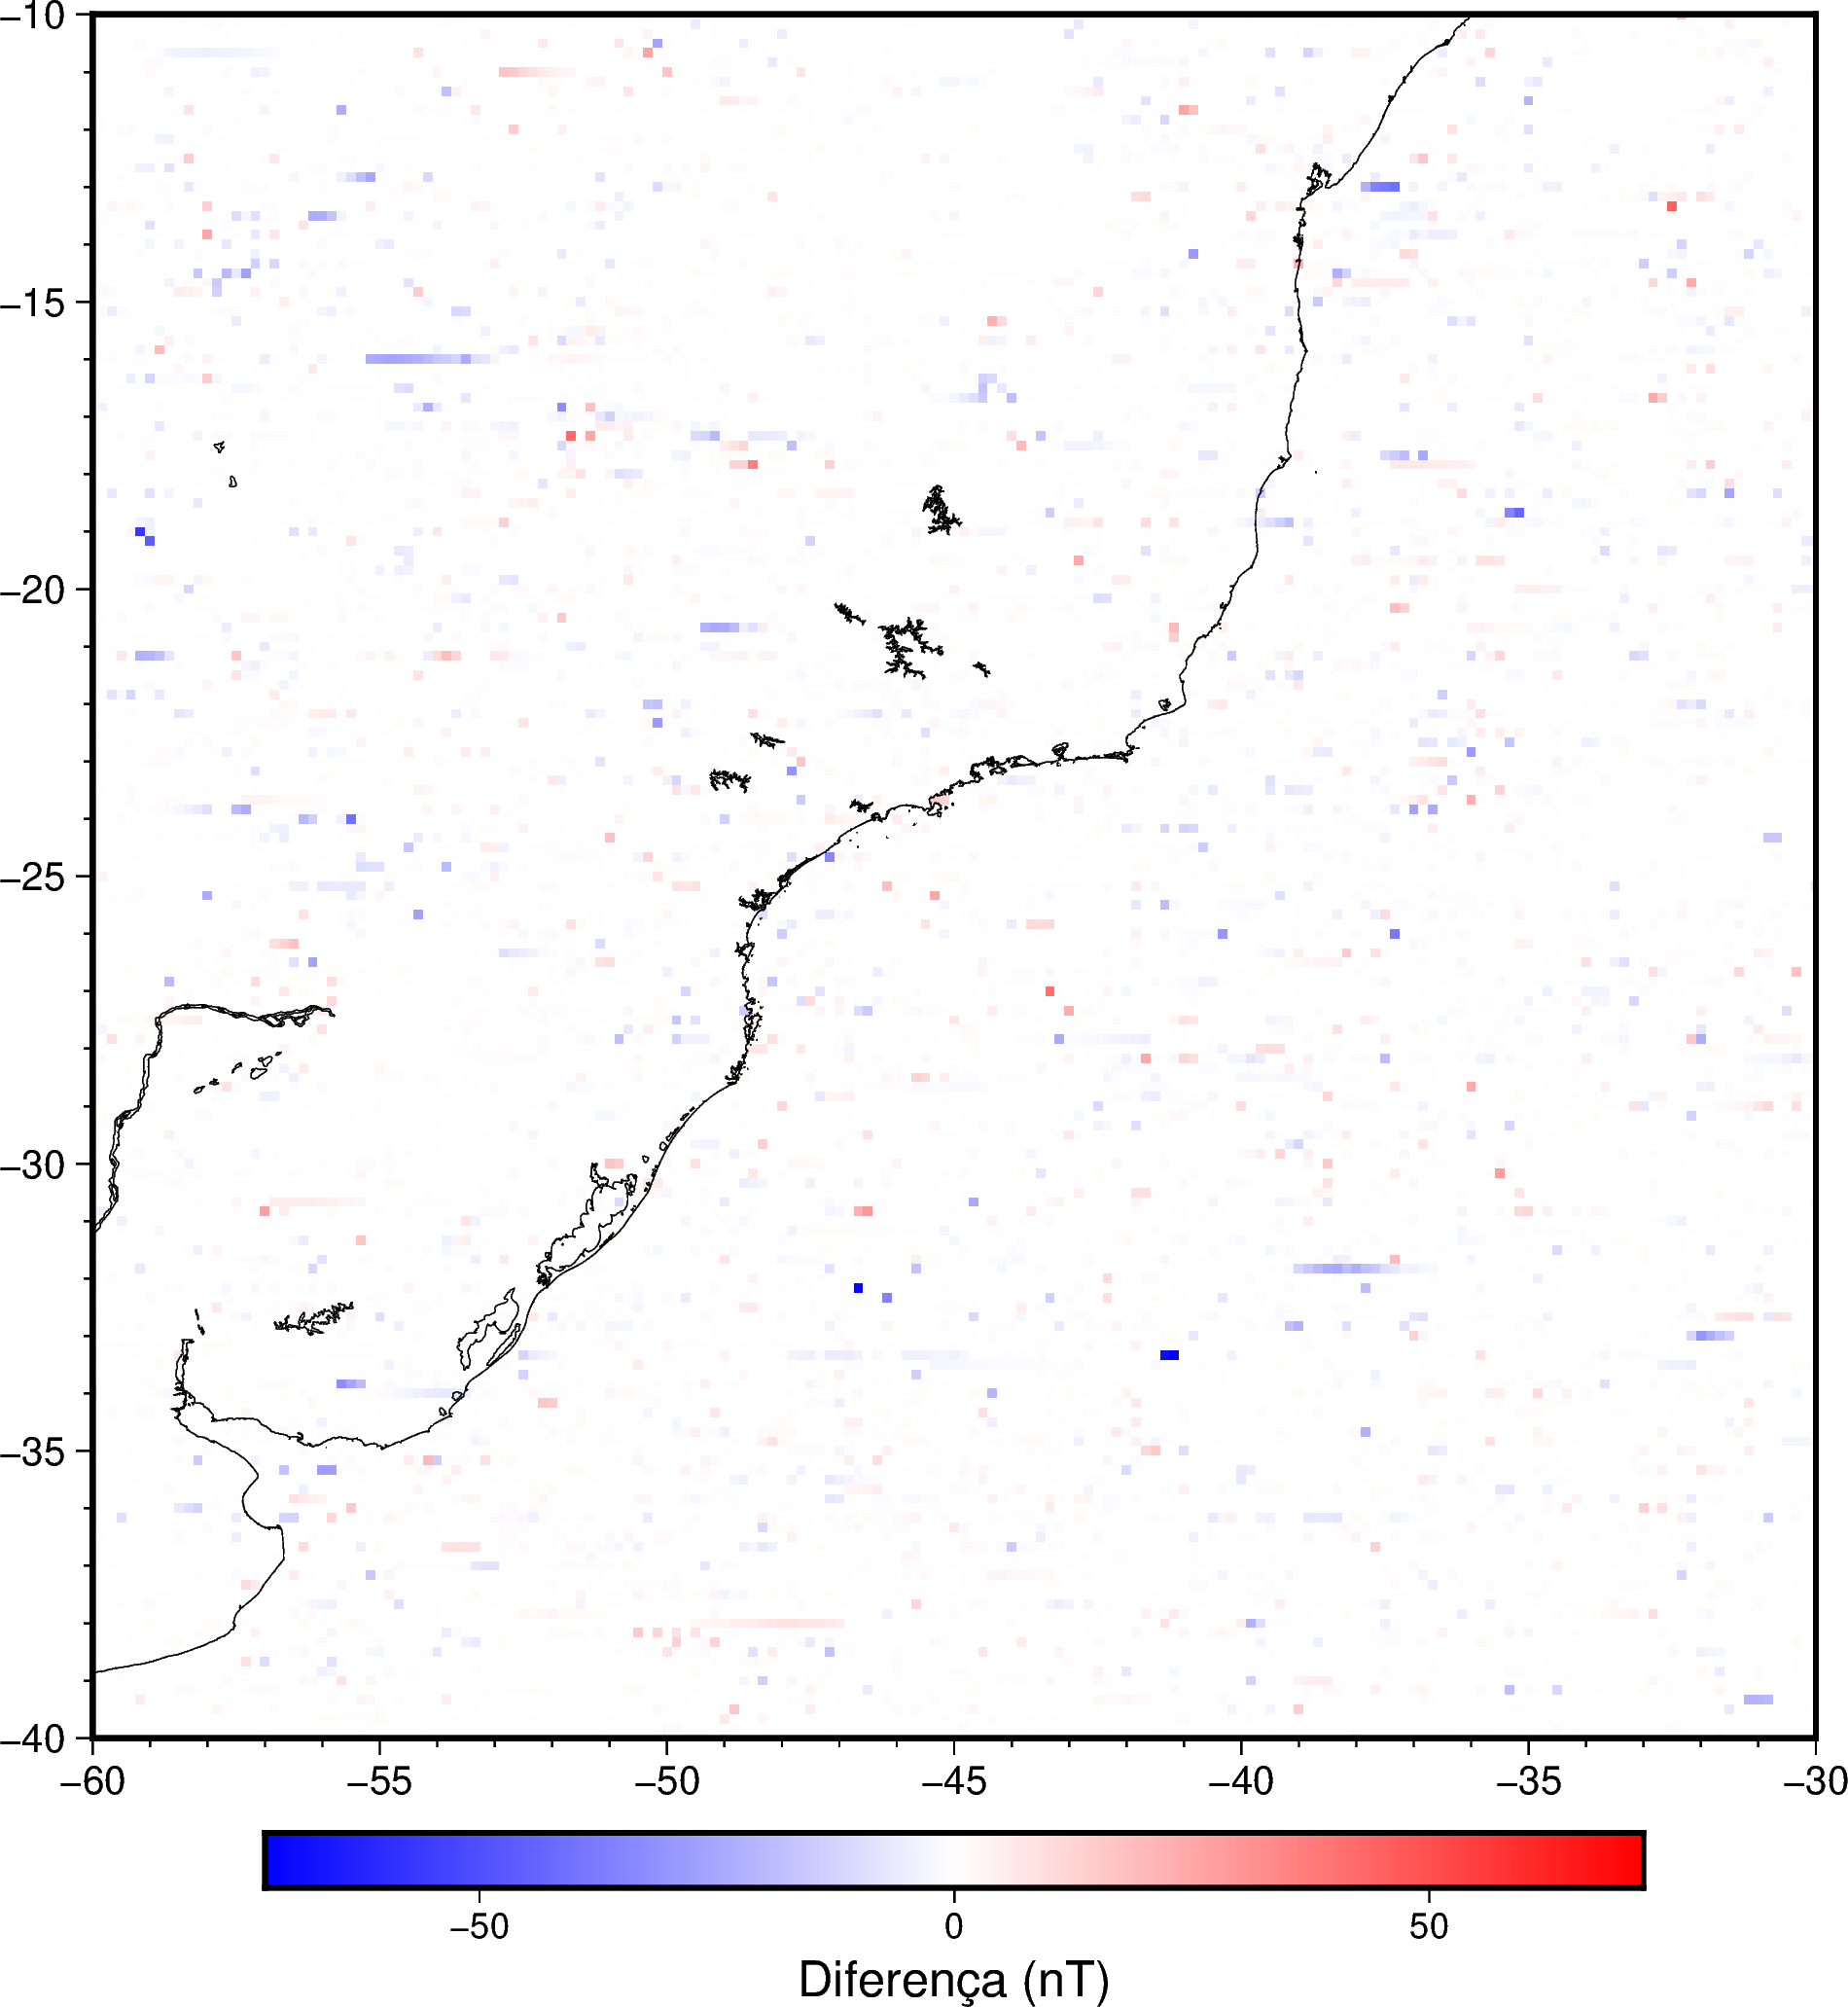

In [18]:
# Diferença entre o grid calculdado com 64 e 32 bits.

# Calcular o Grid da Diferença (64 bits - 32 bits)
# Isso mostra onde a precisão foi perdida ou alterada
diff_bits = total_field_anomaly_predicted_64 - total_field_anomaly_predicted_32

# Calcular a escala automática para essa diferença
# Usamos o máximo absoluto para garantir que o zero fique no centro (branco)
limite_diff = np.nanmax(np.abs(diff_bits))

# Criar e salvar o CPT específico para essa diferença
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_diff, limite_diff], 
    background=True,
    output="escala.cpt"
)

# 4. Plotar
print("Mapa de Diferença (64 bits vs 32 bits)")
fig = pygmt.Figure()
fig.grdimage(
    diff_bits, 
    cmap="escala.cpt", 
    frame=True
)
fig.colorbar(
    cmap="escala.cpt", 
    frame=["a", "x+lDiferença (nT)"]
)
fig.coast(shorelines=True)
fig.show()

Diferença de precisão

In [20]:
# --- 1. Extração dos Dados Numéricos ---

valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---

mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")


media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: 5.2338693690268006
A Raiz do Erro Quadrático Médio (RMSE) é: 2.2878 nT
O erro dividido pela média dos valores absolutos dos dados é: 0.1171038571050393


Proporção entre quantidade de pontos de entrada e tamanho do grid

In [21]:
pontos_entrada = len(data)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)

10000
32761


Show the difference.

64 bits (Resíduos)


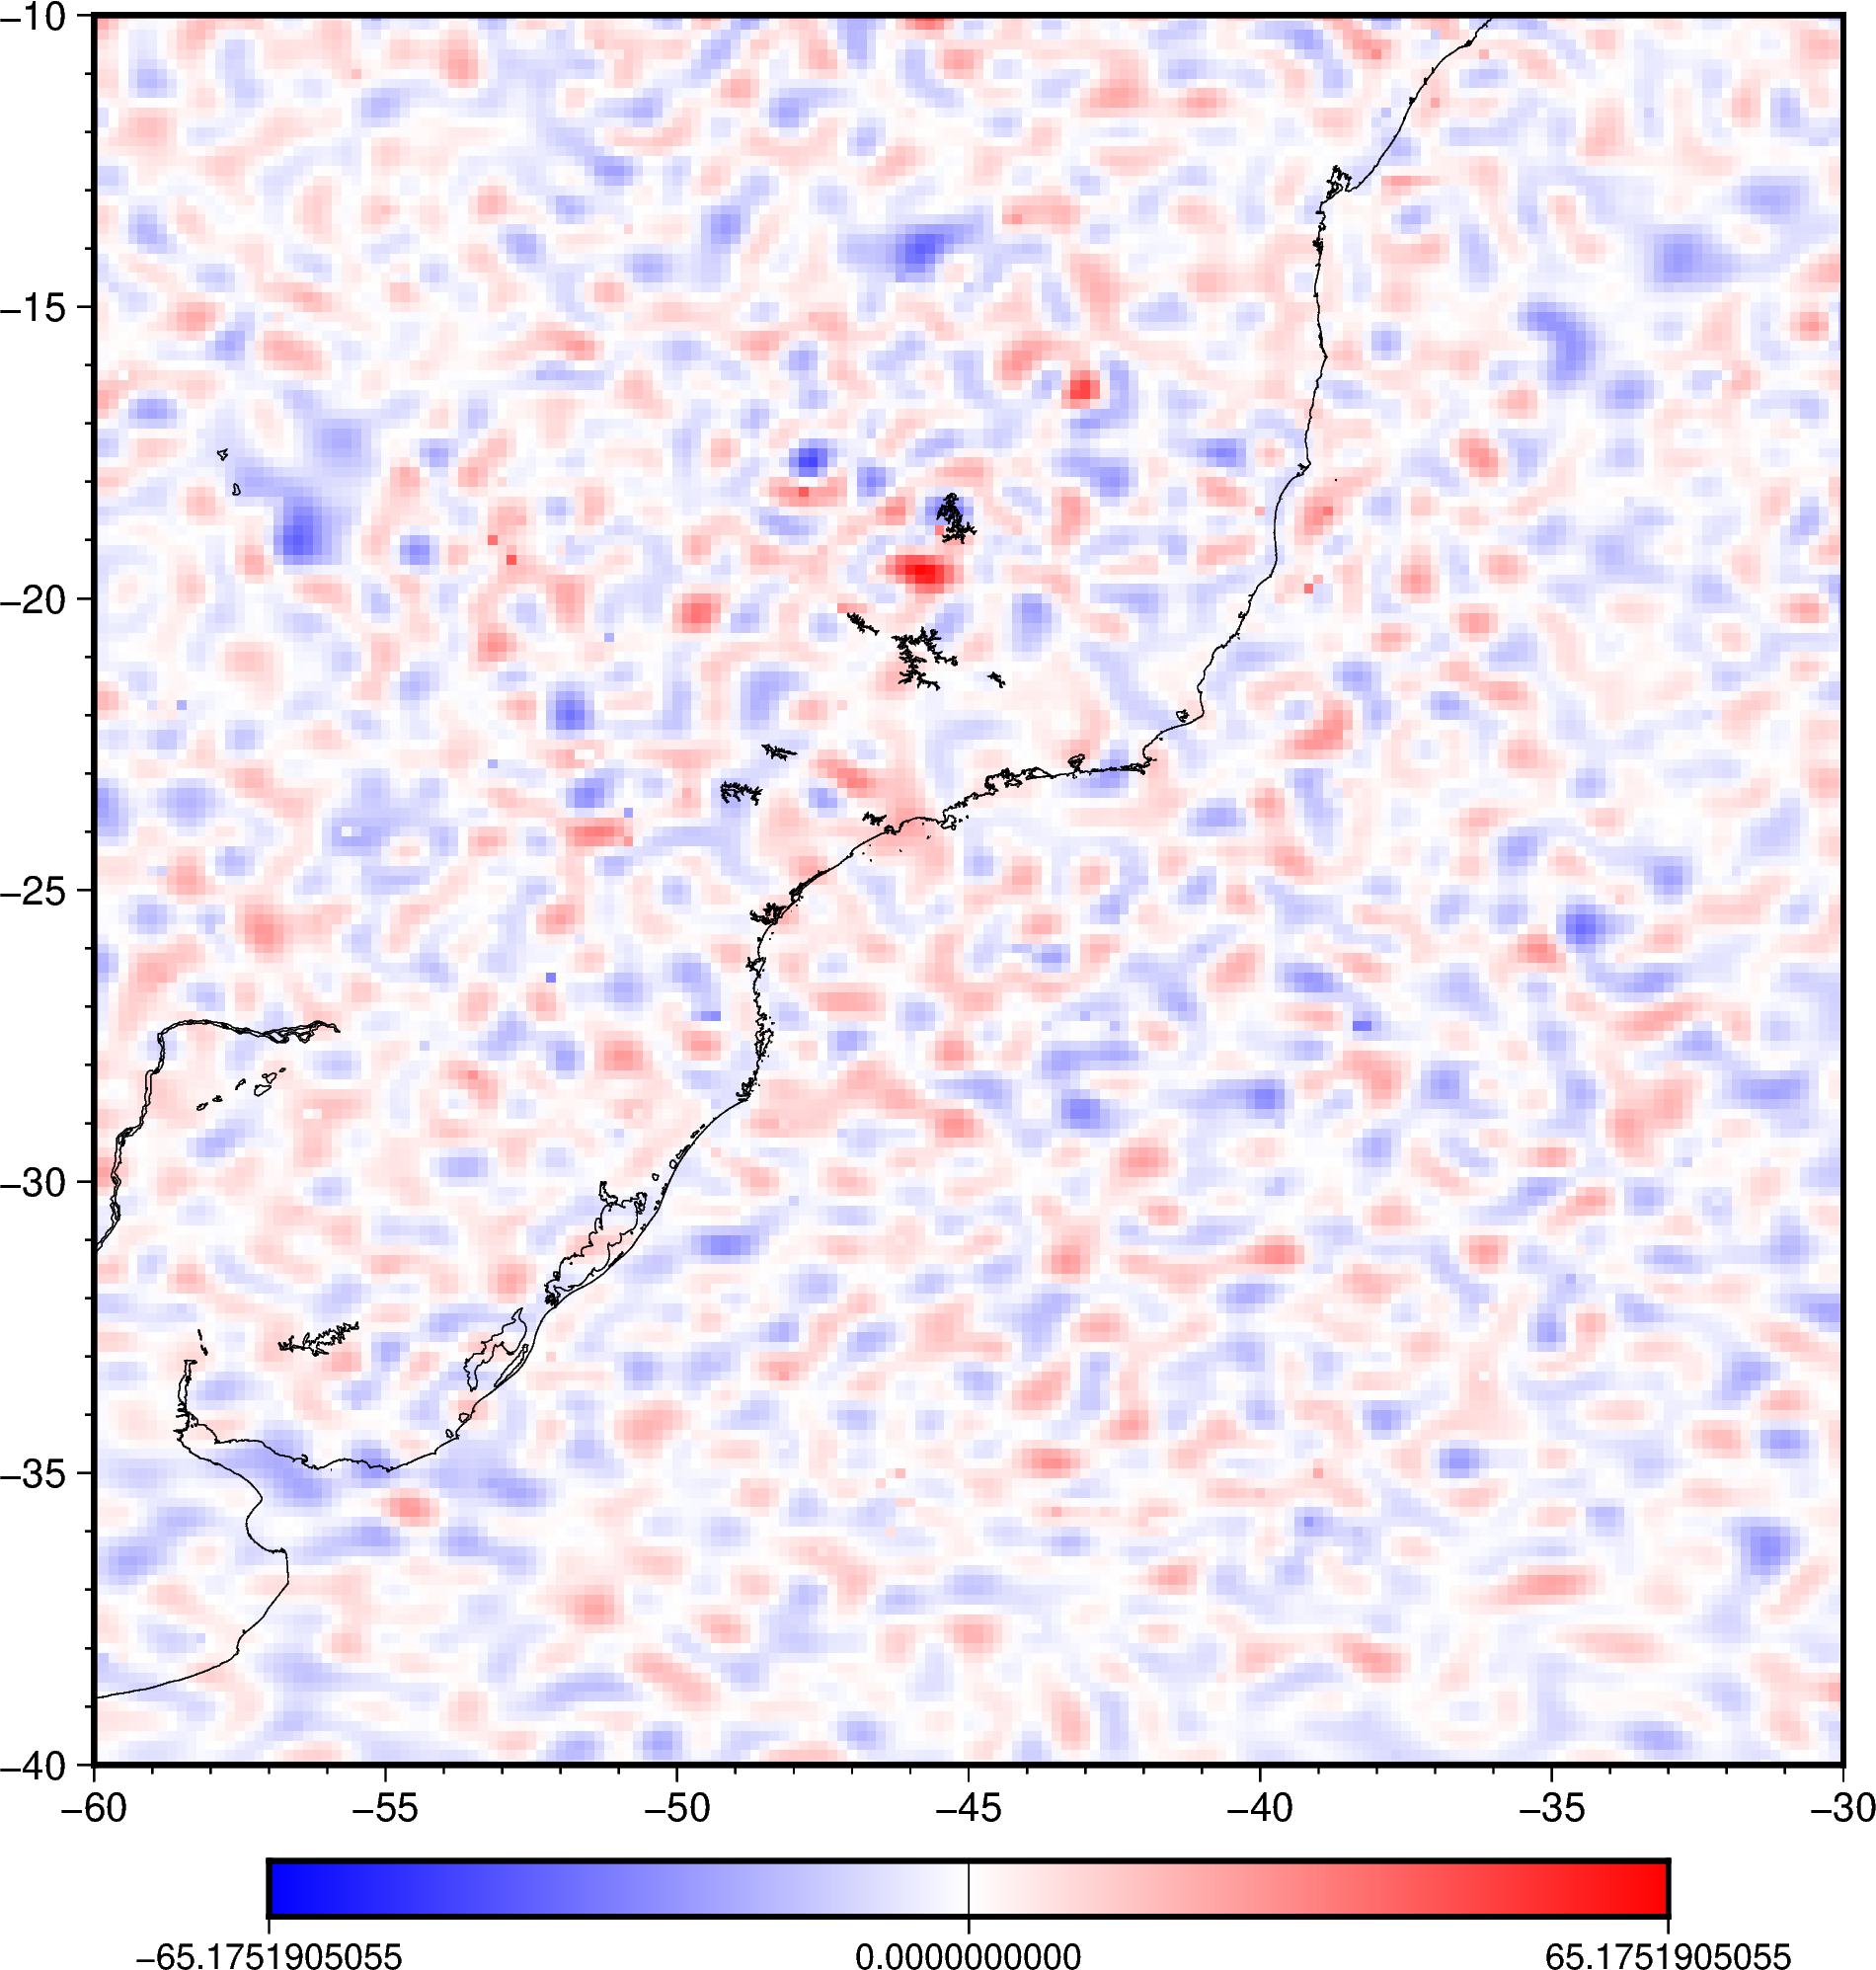

32 bits (Resíduos)


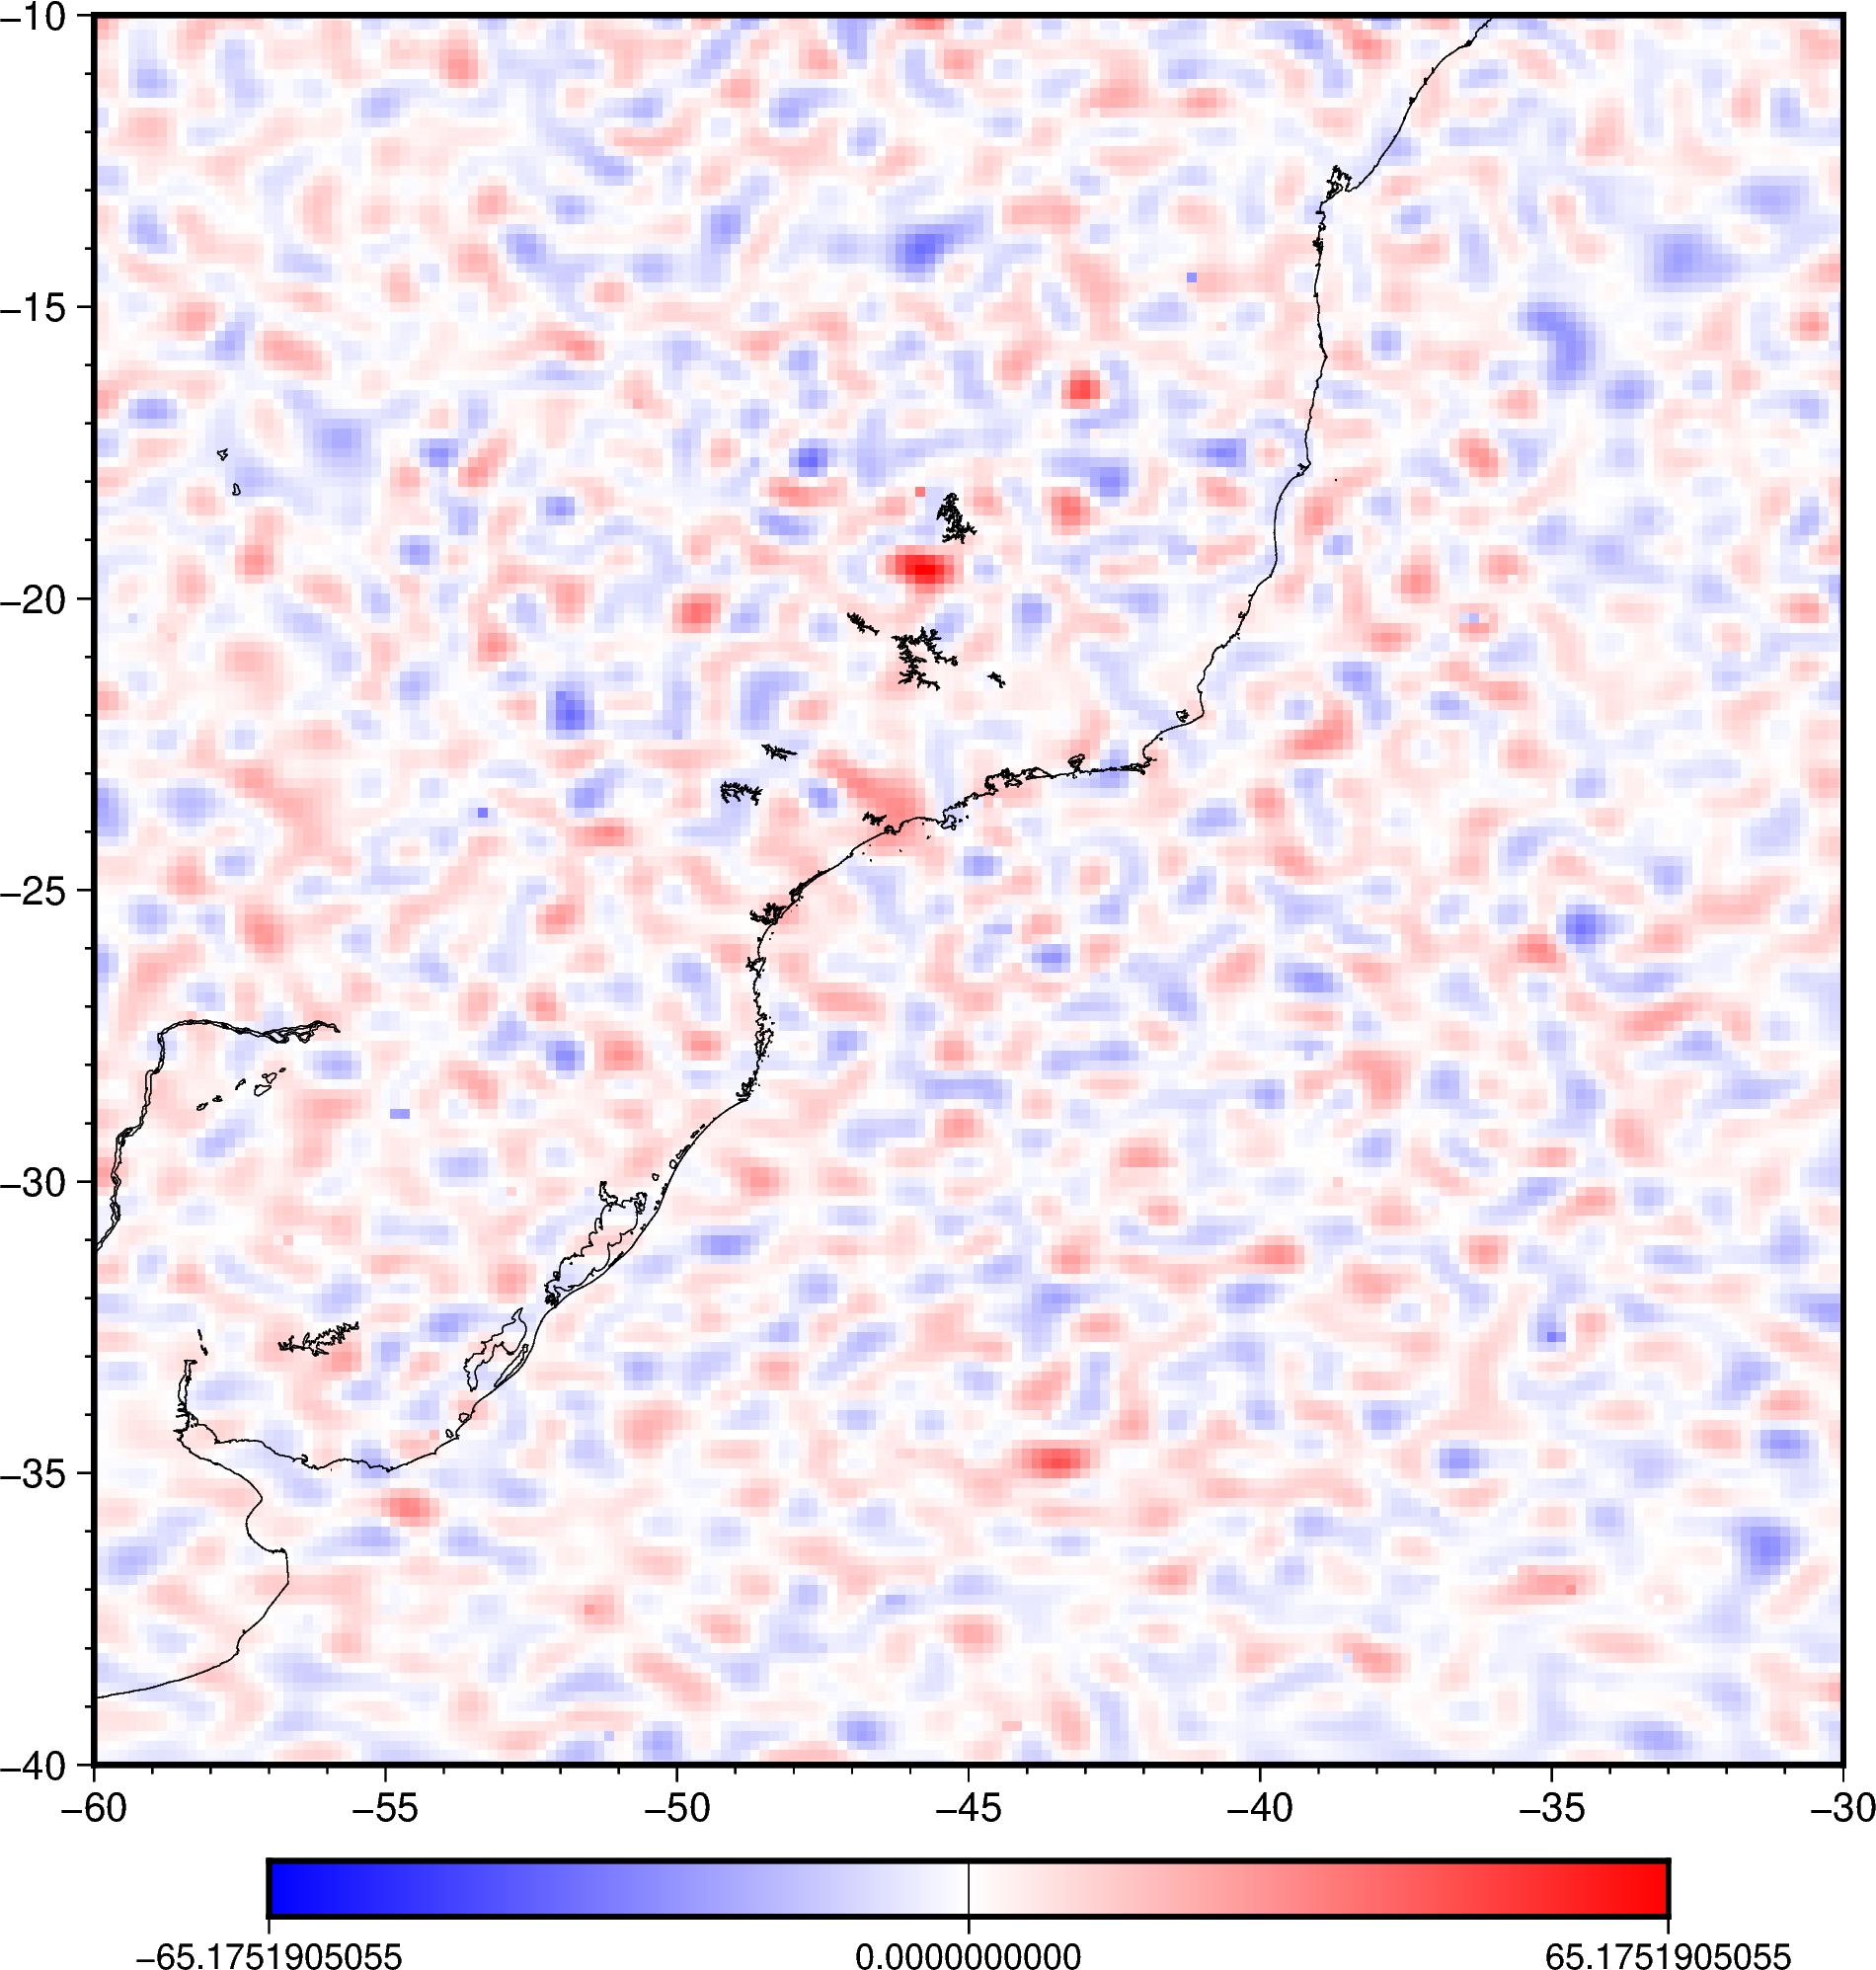

In [27]:
# Calcular os grids de diferença (Resíduos)
diff_64 = total_field_anomaly - total_field_anomaly_predicted_64
diff_32 = total_field_anomaly - total_field_anomaly_predicted_32

# Encontrar o teto da escala (Máximo valor Absoluto Global)
# Isso garante que o zero seja branco e os extremos (positivo/negativo) tenham a mesma intensidade
max_erro_64 = np.nanmax(np.abs(diff_64))
max_erro_32 = np.nanmax(np.abs(diff_32))
limite_escala = max(max_erro_64, max_erro_32)


# Criar e salvar o arquivo de cores (CPT)
pygmt.makecpt(
    cmap="polar+h",
    series=[-limite_escala, limite_escala],
    background=True,
    output="escala.cpt"
)

# --- Plot 64 bits ---
print("64 bits (Resíduos)")
fig = pygmt.Figure()
fig.grdimage(
    diff_64,
    cmap="escala.cpt",
    frame=True
)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

# --- Plot 32 bits ---
print("32 bits (Resíduos)")
fig = pygmt.Figure()
fig.grdimage(
    diff_32,
    cmap="escala.cpt",
    frame=True
)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

Plot the windows.

64 bits


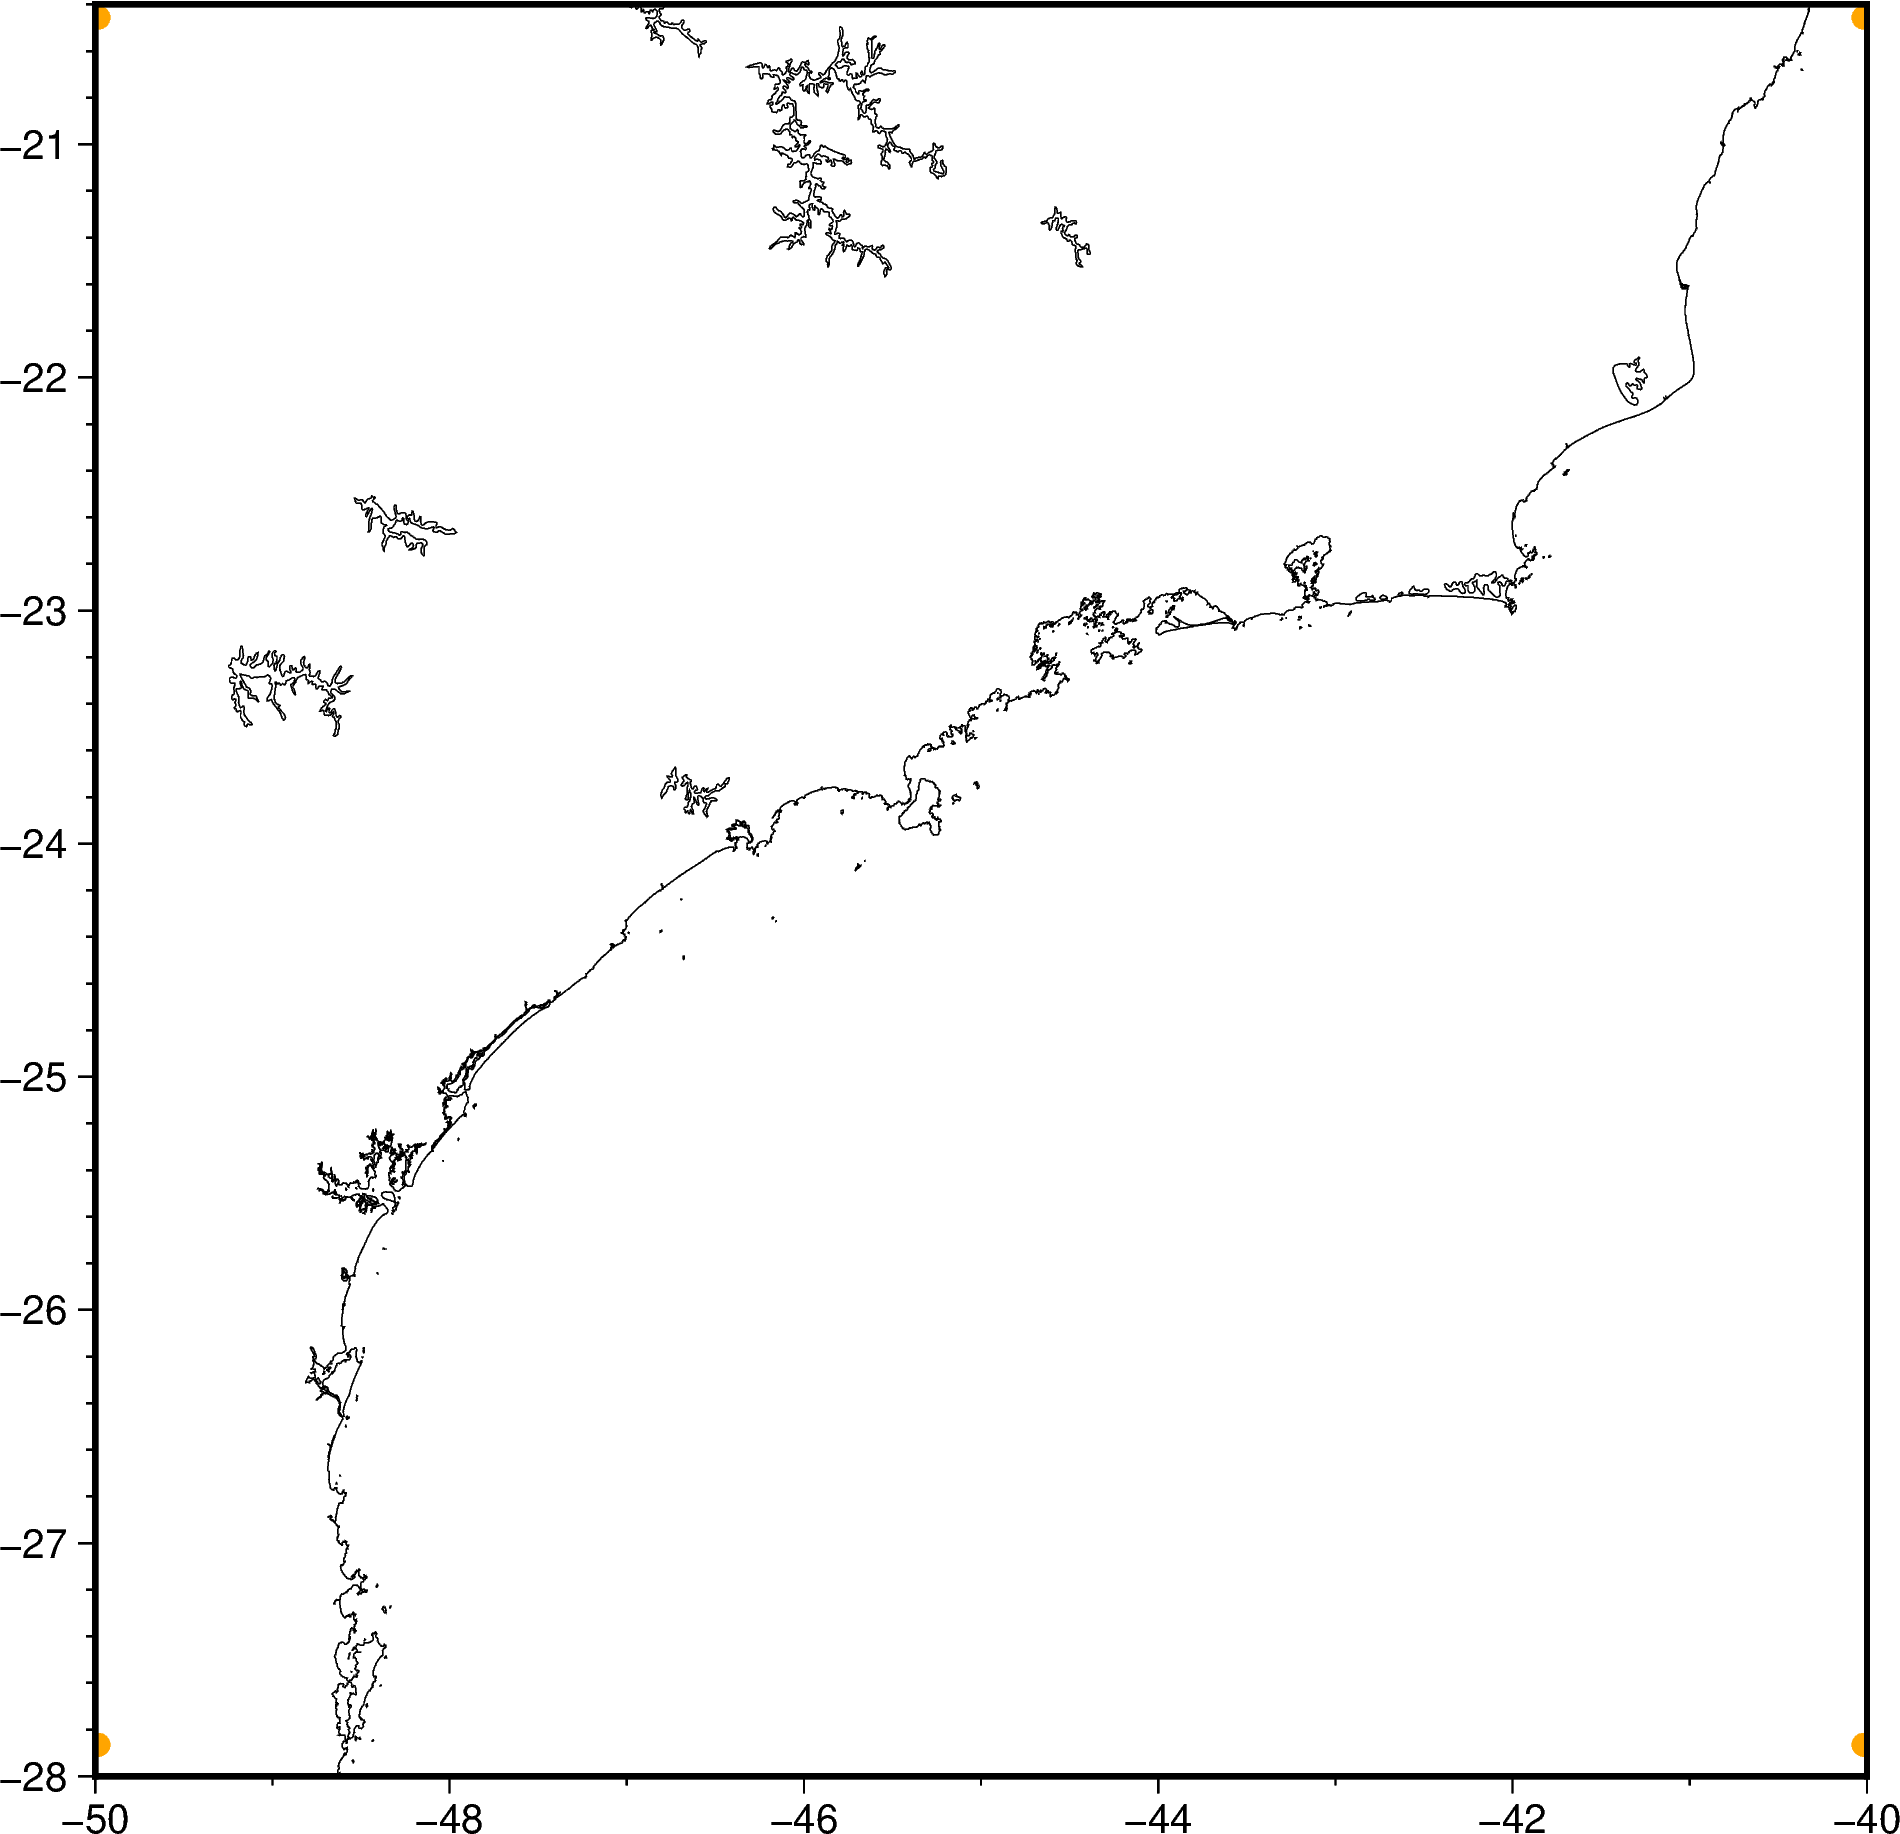

32 bits


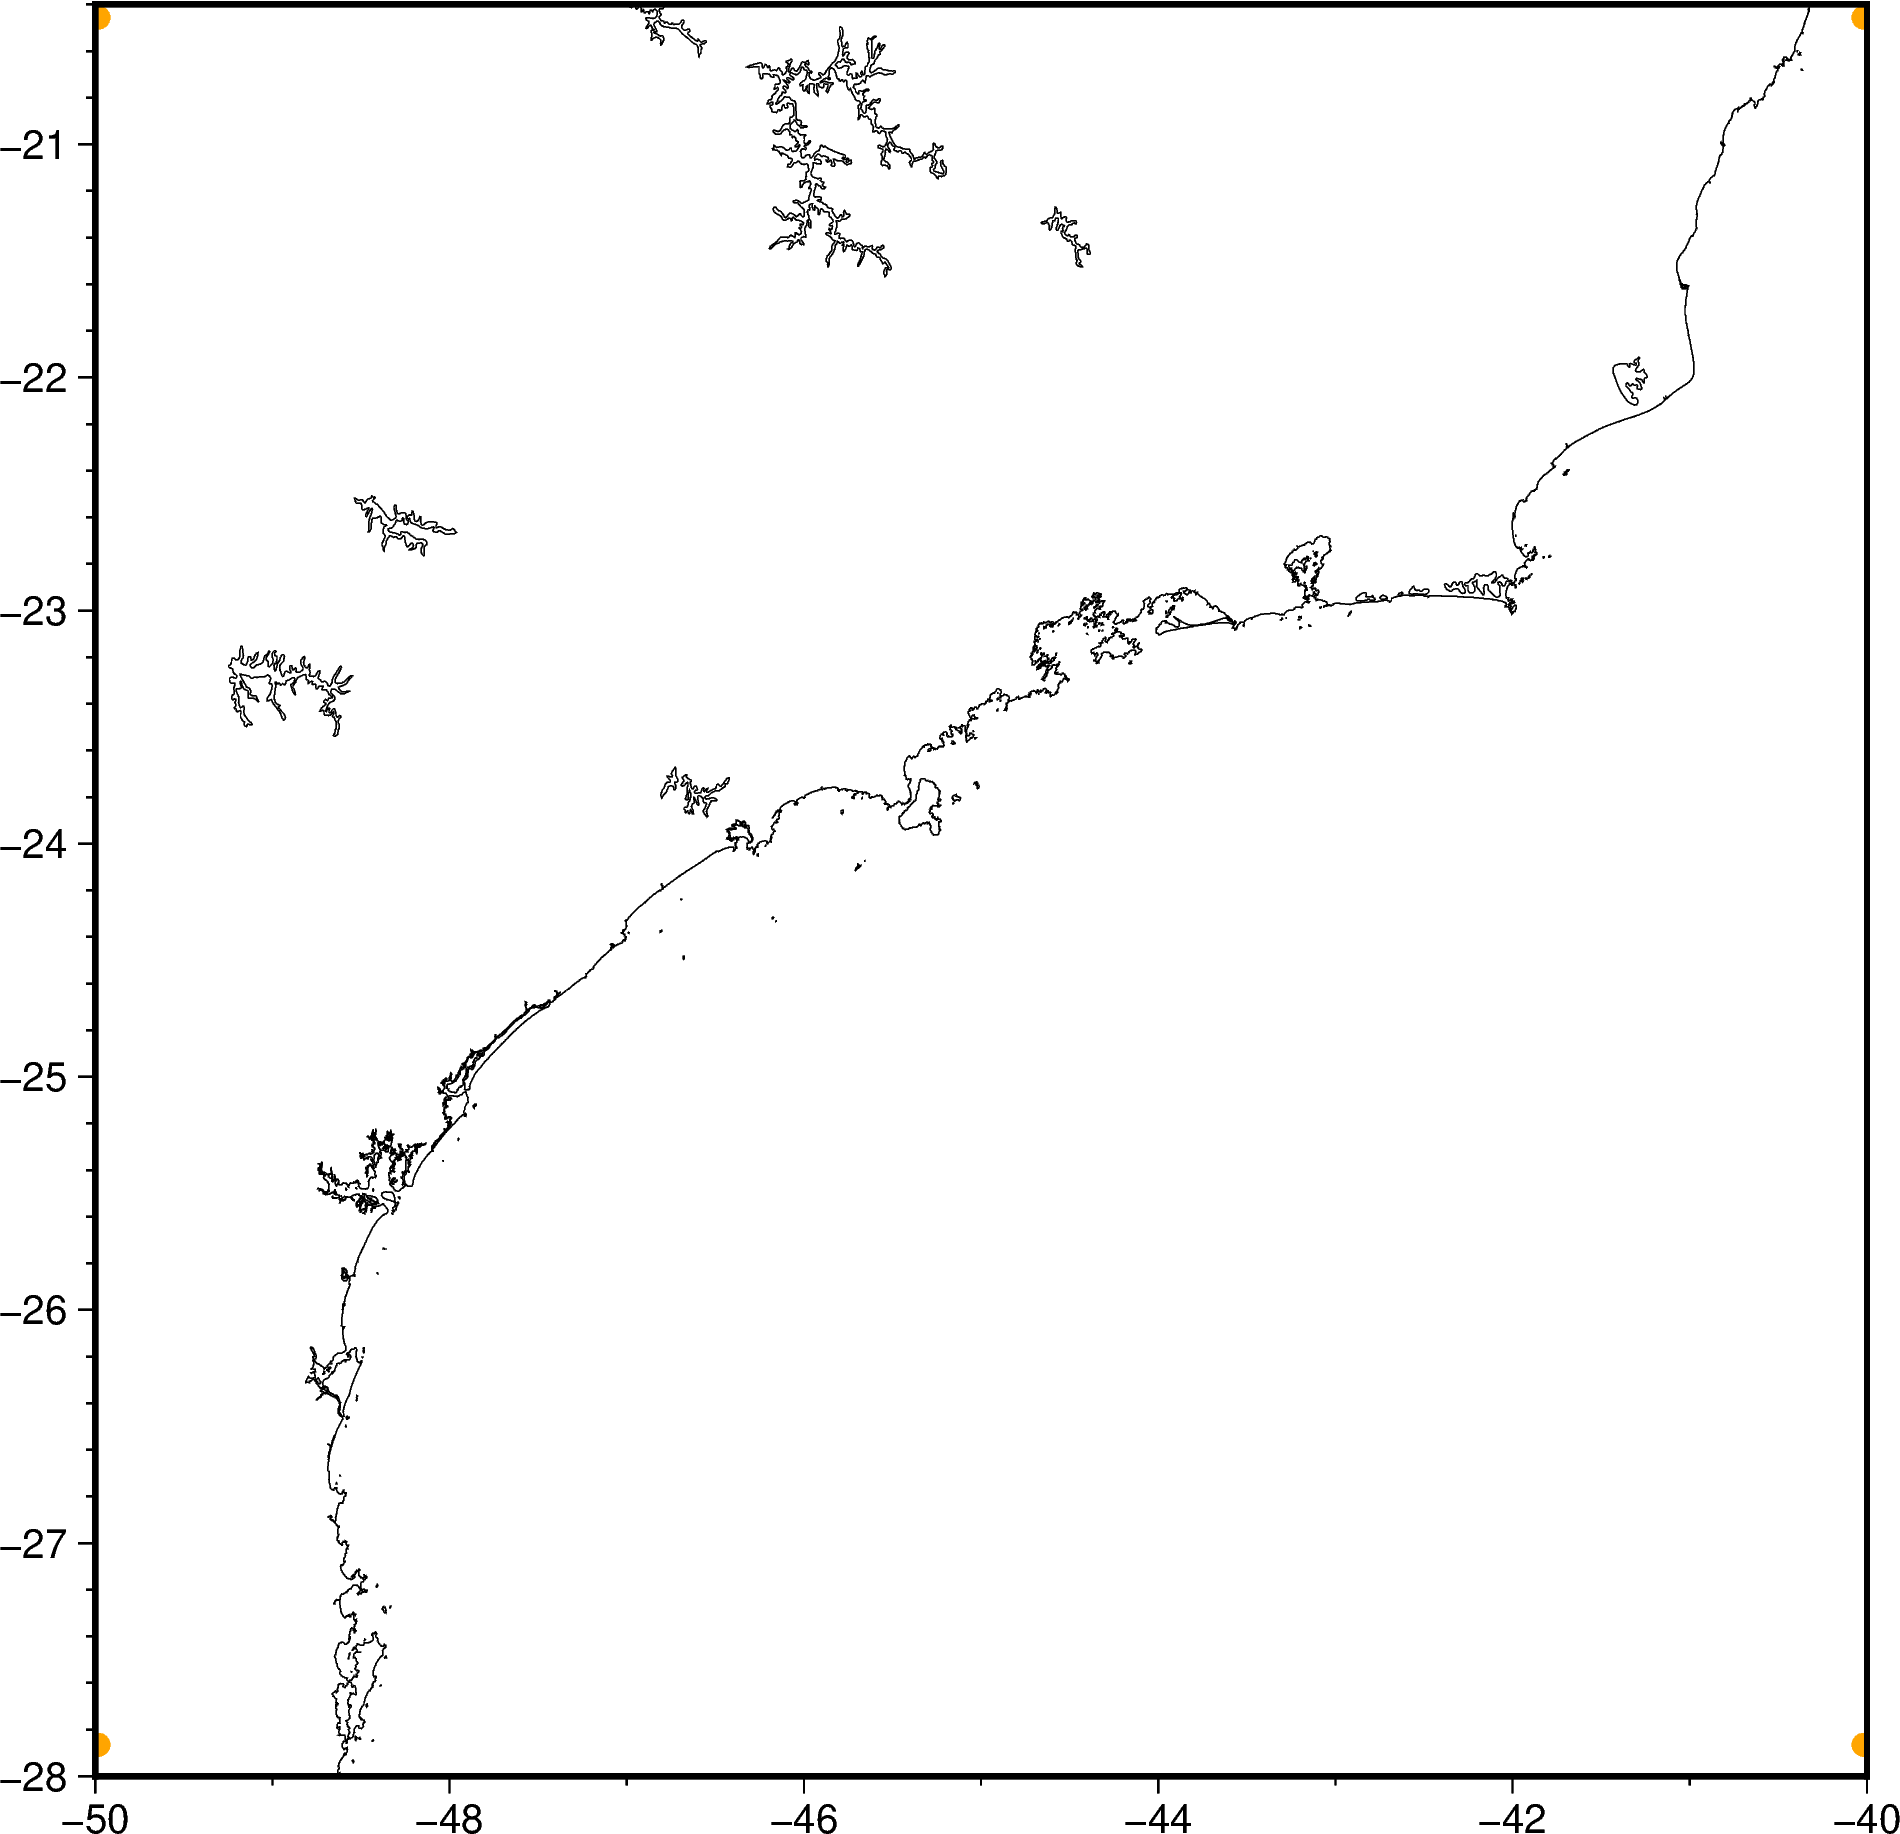

In [24]:
# Não sei se isso muda de um para o outro averiguar posteriormente
print("64 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_64.window_centers_[0].ravel(), y=eqs_64.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True)
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_32.window_centers_[0].ravel(), y=eqs_32.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True)
fig.coast(shorelines=True)
fig.show()


## Test in the poles

In [22]:
region = (0, 360, -90, -60)
grid_coordinates = bd.grid_coordinates(region, spacing=20/60, non_dimensional_coords=200)
dipole = (-66, -79, -200e3)
# Regional field
inclination, declination = -80, 0
dipole_moment = hm.magnetic_angles_to_vec(1e16, inclination, declination)
magnetic_field = sph.dipole_magnetic_geodetic(grid_coordinates, dipole, dipole_moment)
total_field_anomaly = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(magnetic_field, inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

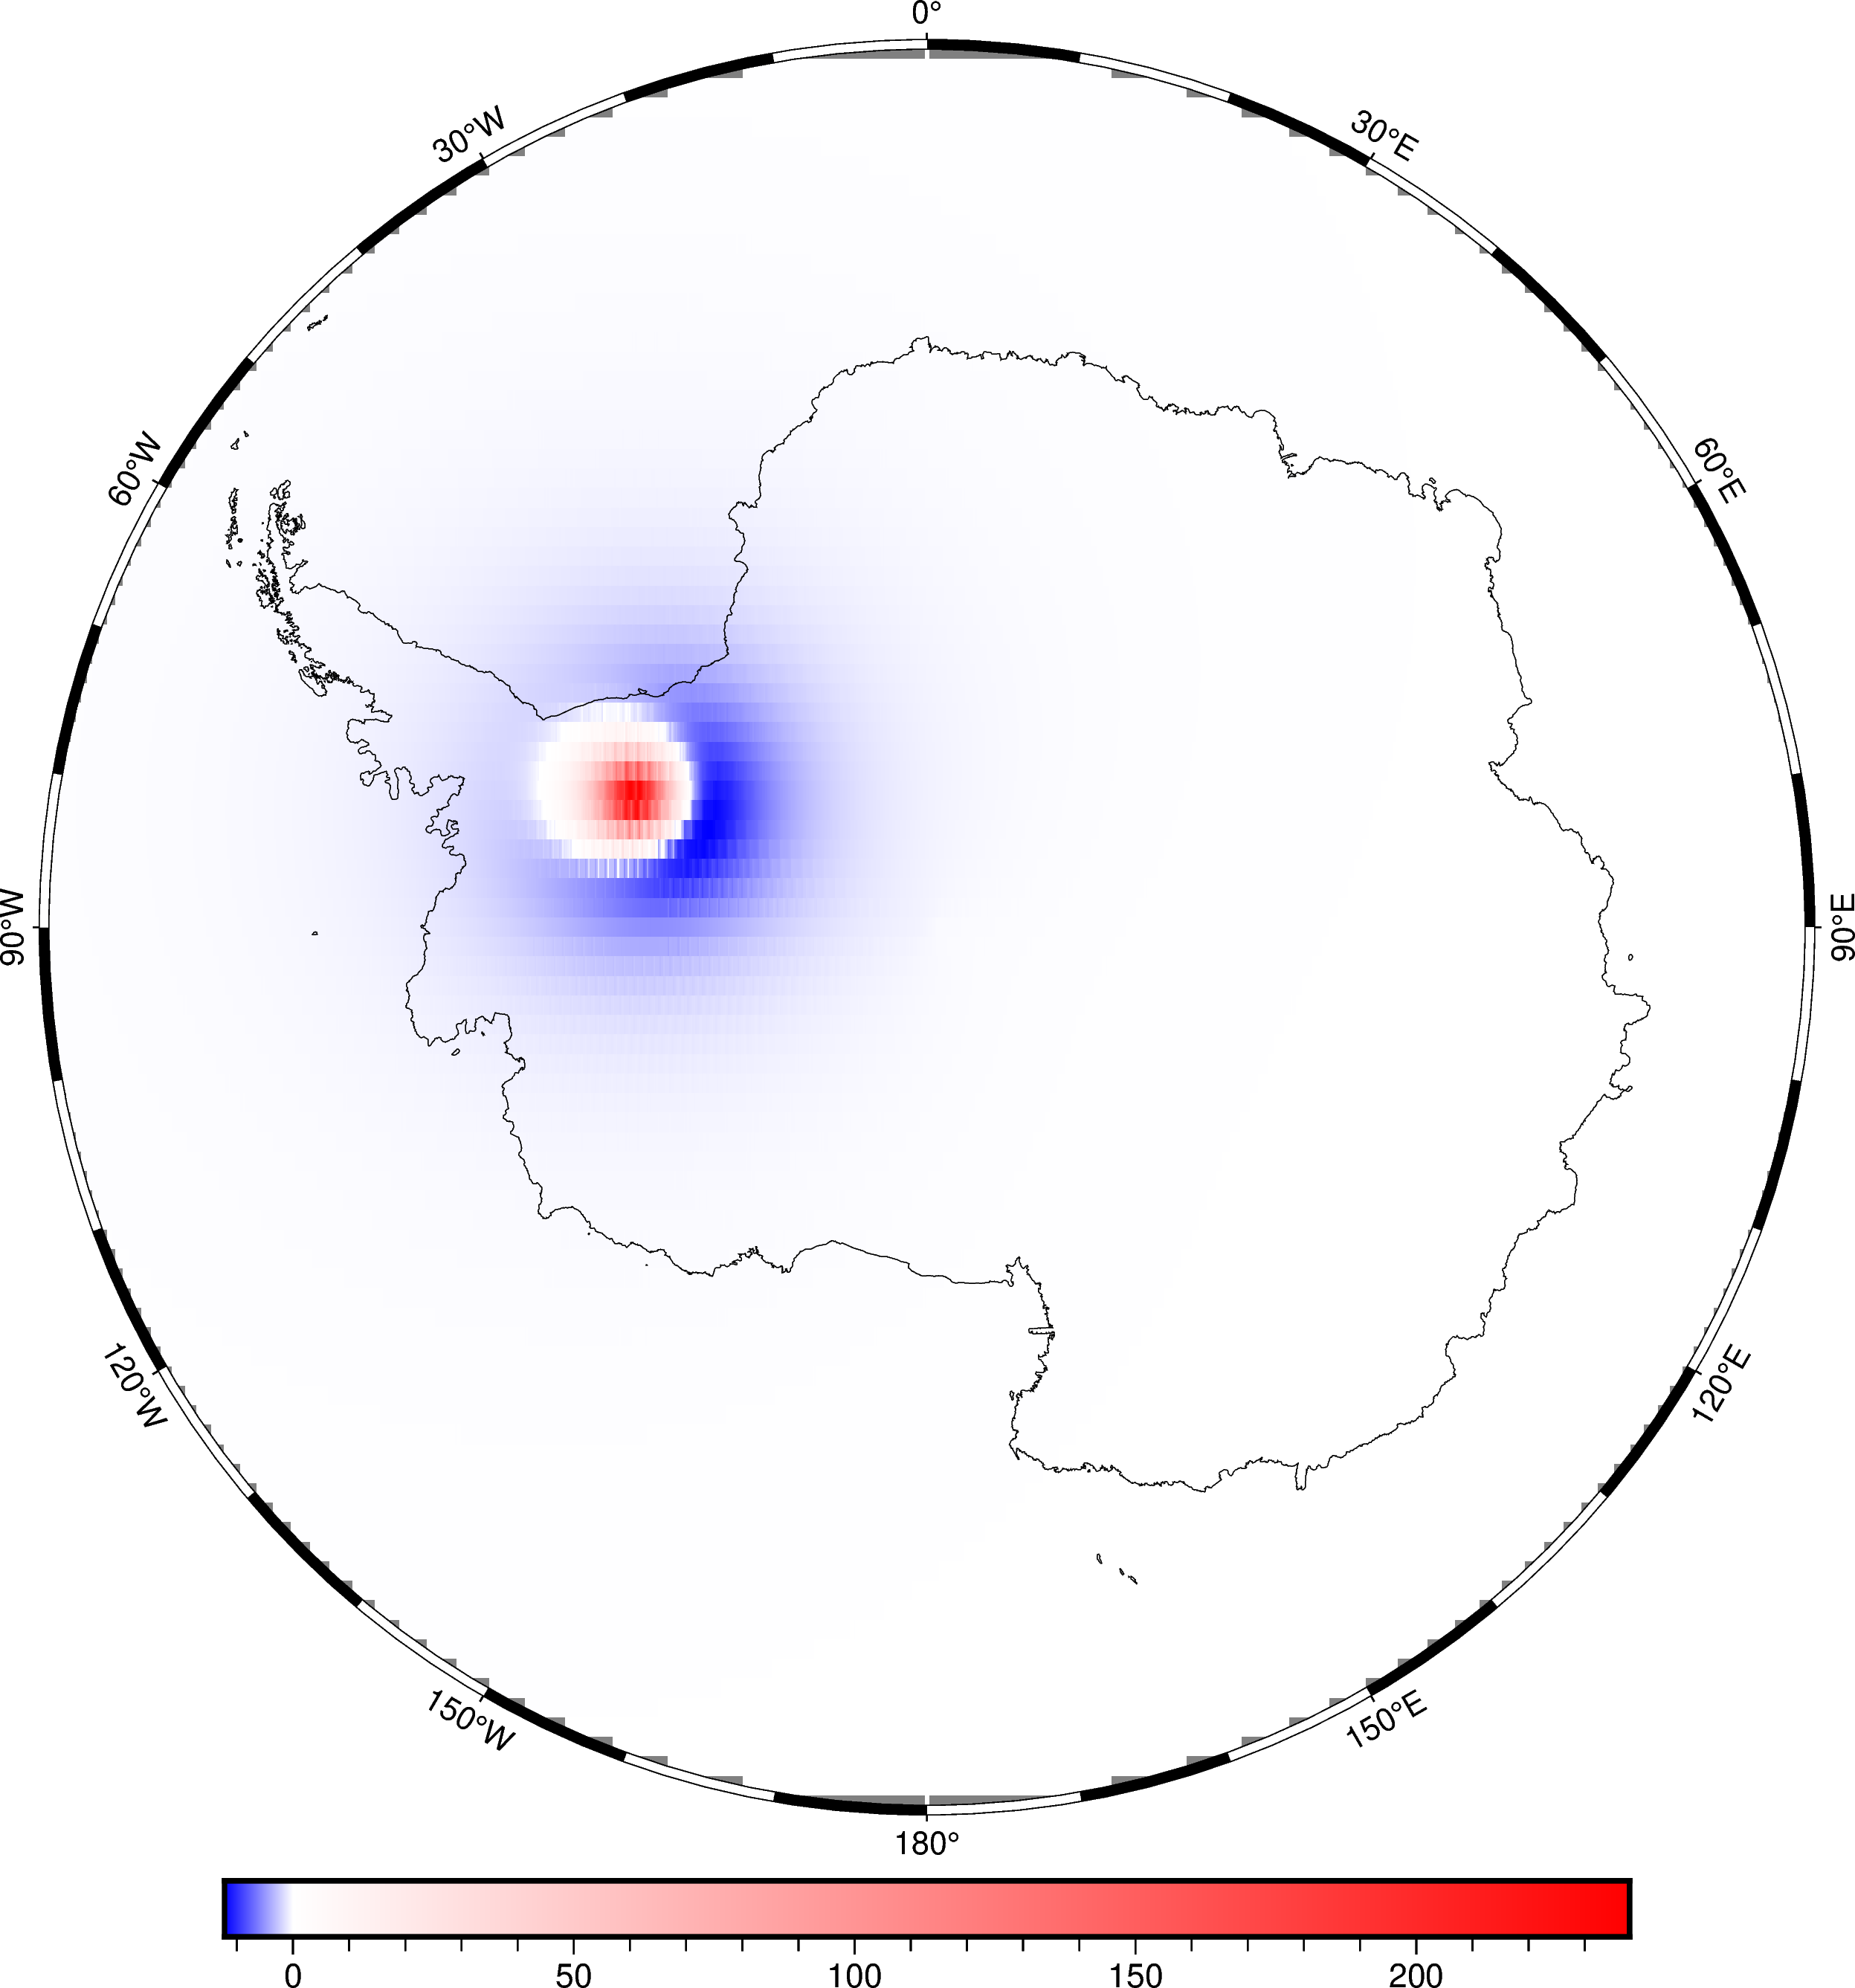

In [23]:
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly, cmap="polar+h", frame=True, projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

In [24]:
coordinates = bd.random_coordinates(list(region) + [150, 300], 10000)
magnetic_field_obs = sph.dipole_magnetic_geodetic(coordinates, dipole, dipole_moment)
data = hm.total_field_anomaly(magnetic_field_obs, inclination, declination)
noise_level = 0.01 * vd.maxabs(data)
data += np.random.default_rng(42).normal(0, noise_level, data.shape)
print(noise_level, "nT")

qtd_pontos = data.size
print(f"Quantidade total de pontos para o fit: {qtd_pontos}")

2.4008205384583867 nT
Quantidade total de pontos para o fit: 10000


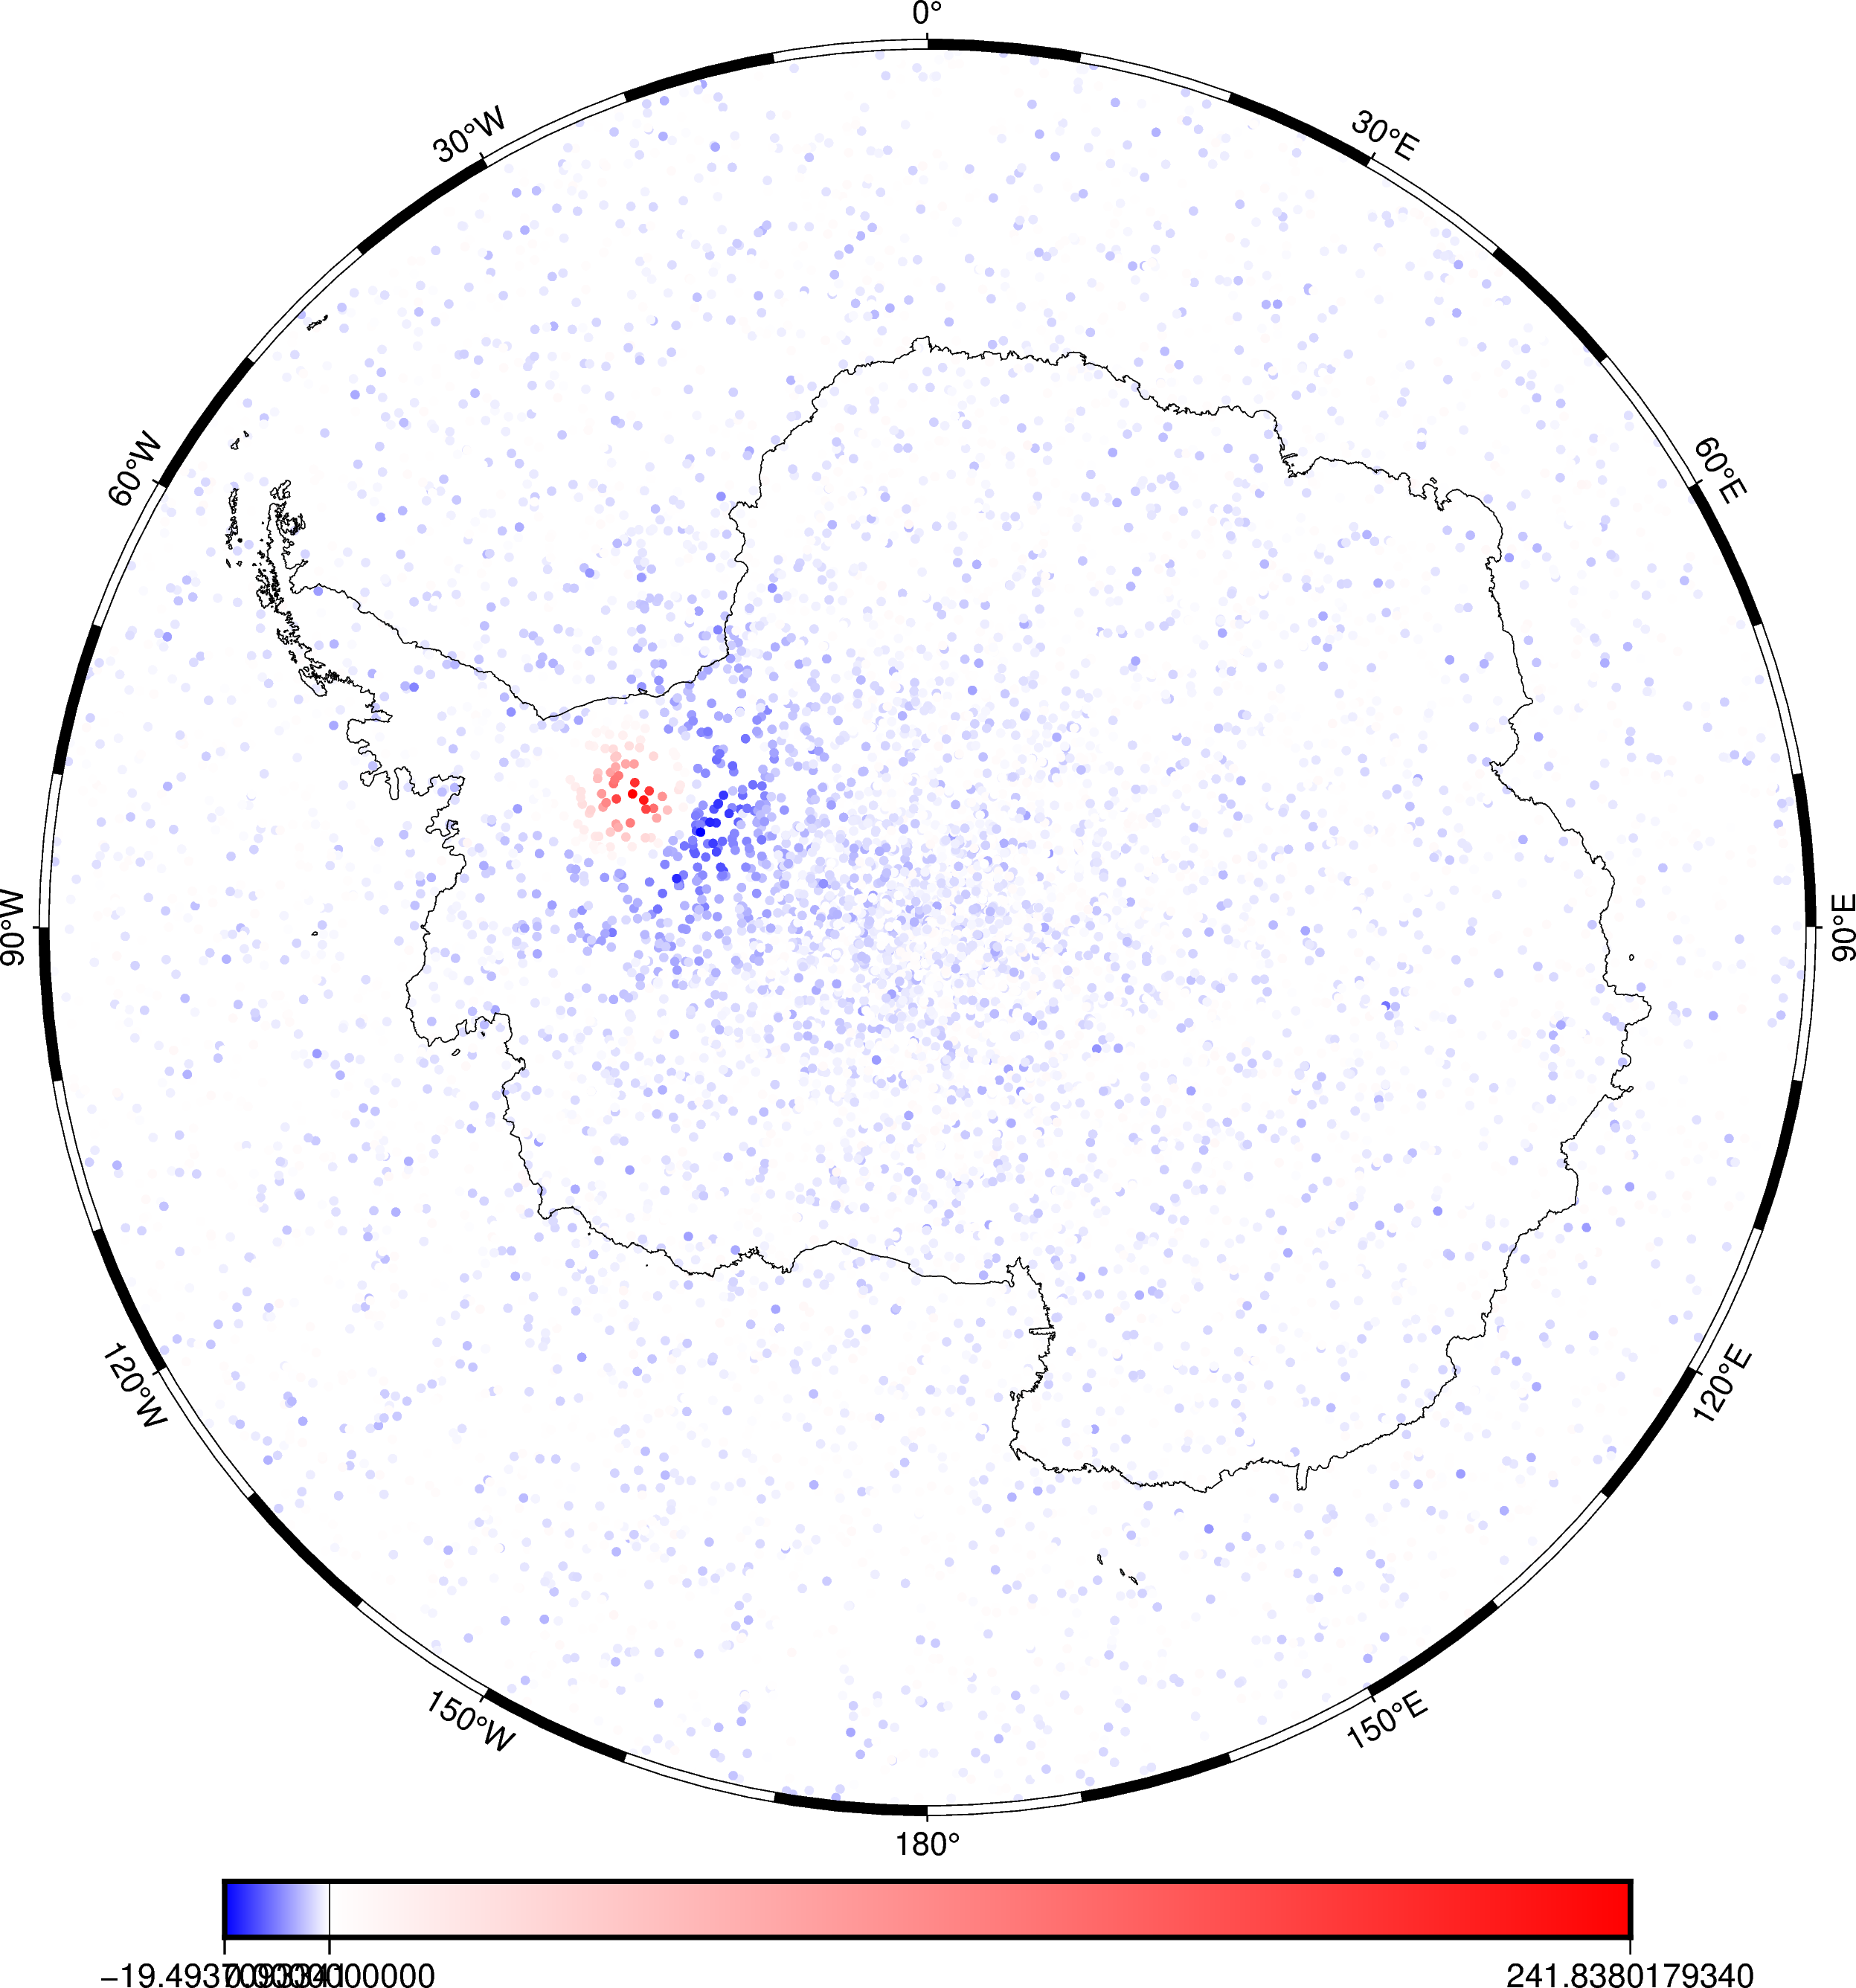

In [25]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h", series=[data.min(), data.max()])
fig.plot(x=coordinates[0], y=coordinates[1], fill=data, style="c0.1c", cmap=True, frame=True, projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Try recovering the dipole field with a gradient-boosting single layer inversion in the poles.

In [26]:
proj = pyproj.Proj(
                f"+proj=ups +south")
eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_64.fit(coordinates, inclination, declination, data)
print(eqs_64.window_size_)

Output()

4794840.393655064


Timer unit: 1e-09 s

Total time: 37.1844 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       1473.0   1473.0      0.0          if dtype is not None:
   551                                                       coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552                                                       data = np.asarray(data, dtype=dtype)
   5

Try recovering the dipole field with a gradient-boosting single layer inversion in the poles. - 32 bits

In [27]:
proj = pyproj.Proj(
                f"+proj=ups +south")

eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")
print(eqs_32.window_size_)

Output()

4794840.361559076


Timer unit: 1e-09 s

Total time: 34.2707 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       1268.0   1268.0      0.0          if dtype is not None:
   551         1    1009107.0 1.01e+06      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552         1     215266.0 215266.0      0.0              data = np.asarray(data, dtype=dtype)
   5

In [31]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 7


for i in range(n_repeticoes):
    
    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj, verbose=False)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj, verbose=False)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })



[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dtype: float64

[DEBUG least_squares] Pós-Scaler Jacobian dtype: float64
[DEBUG least_squares] Resultado (regr.coef_) dtype: float64
[DEBUG least_squares] Params finais dt

In [32]:
# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados


--- Estatísticas Descritivas por Versão ---
         count       mean       std        min        25%        50%  \
Versão                                                                 
32 bits    6.0  39.456553  1.311093  37.749231  38.522822  39.442569   
64 bits    6.0  72.349362  1.167778  70.482312  71.889616  72.547432   

               75%        max  
Versão                         
32 bits  40.508833  41.024457  
64 bits  72.829354  73.925322  


Versão  Rodada    Duração
0   64 bits       2  70.482312
1   64 bits       3  71.678895
2   64 bits       4  73.925322
3   64 bits       5  72.914777
4   64 bits       6  72.573082
5   64 bits       7  72.521781
6   32 bits       2  39.197985
7   32 bits       3  41.024457
8   32 bits       4  40.782726
9   32 bits       5  38.297767
10  32 bits       6  37.749231
11  32 bits       7  39.687154

Plotting the statistics

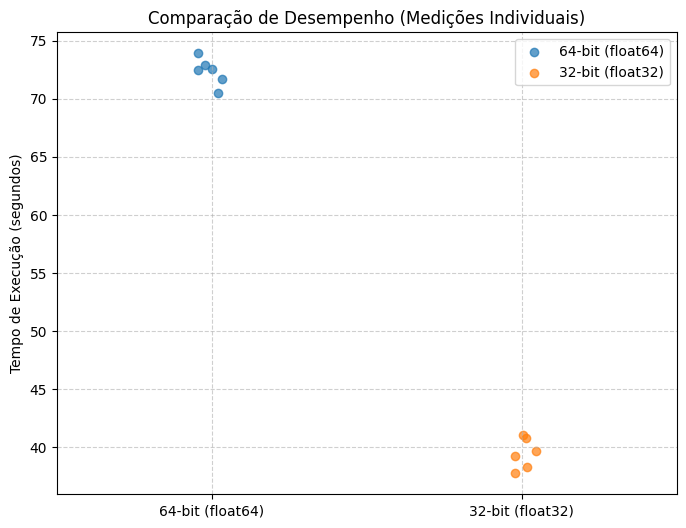

/tmp/ipykernel_5935/2918459018.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


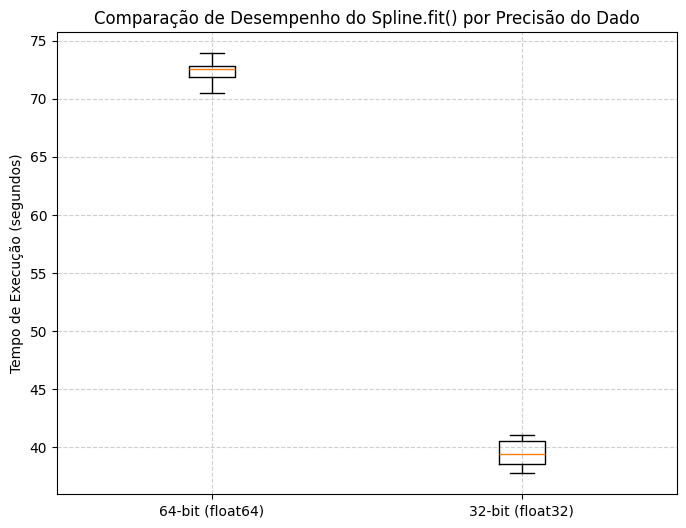

In [33]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Comparação de Desempenho (Medições Individuais)')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_3.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('Comparação de Desempenho do Spline.fit() por Precisão do Dado')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_3.png") descomentar para salvar imagem
plt.show()

Calculate and plot the residuals.

64 bits


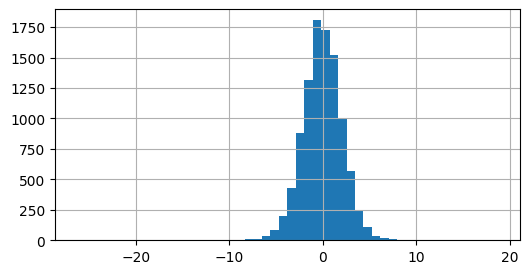

32 bits


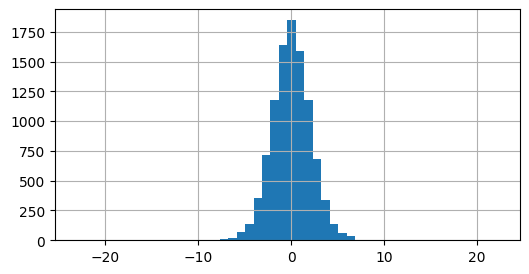

In [34]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

Predict on a grid.

In [28]:
total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

tamanho_grid = total_field_anomaly_predicted_64.size
print(f"Tamanho do grid: {tamanho_grid}")

Tamanho do grid: 98371


64 bits


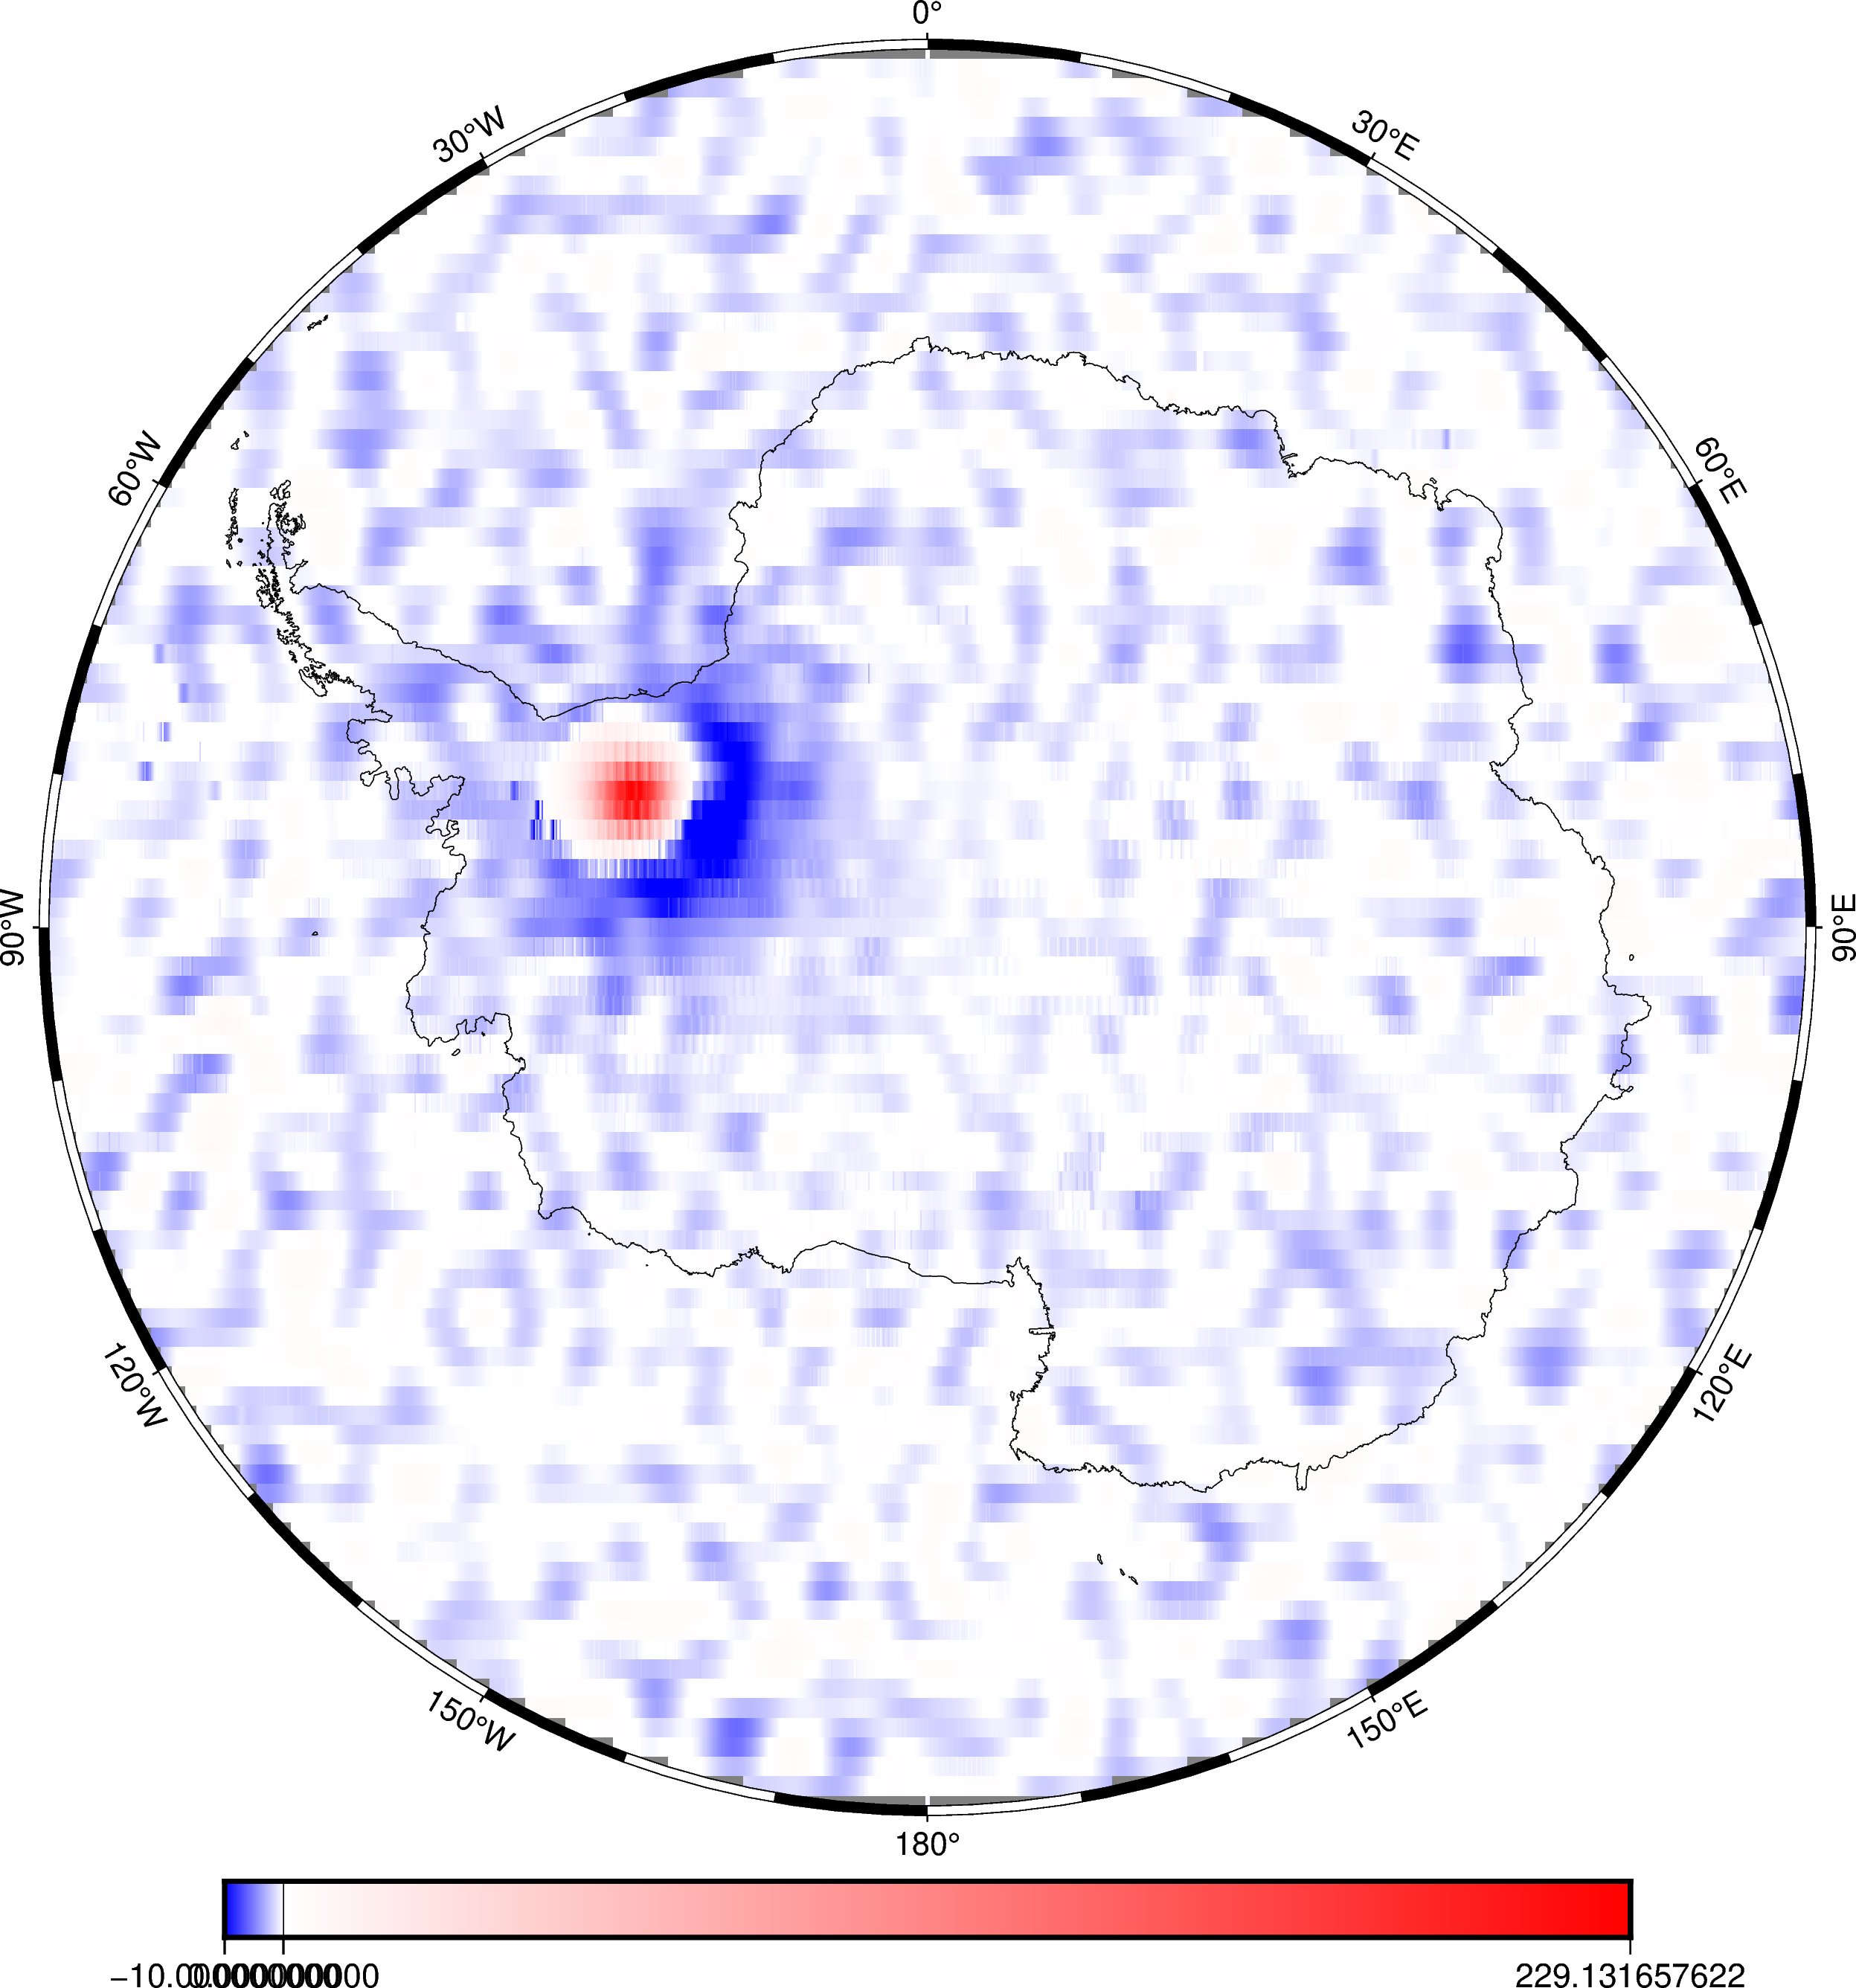

32 bits


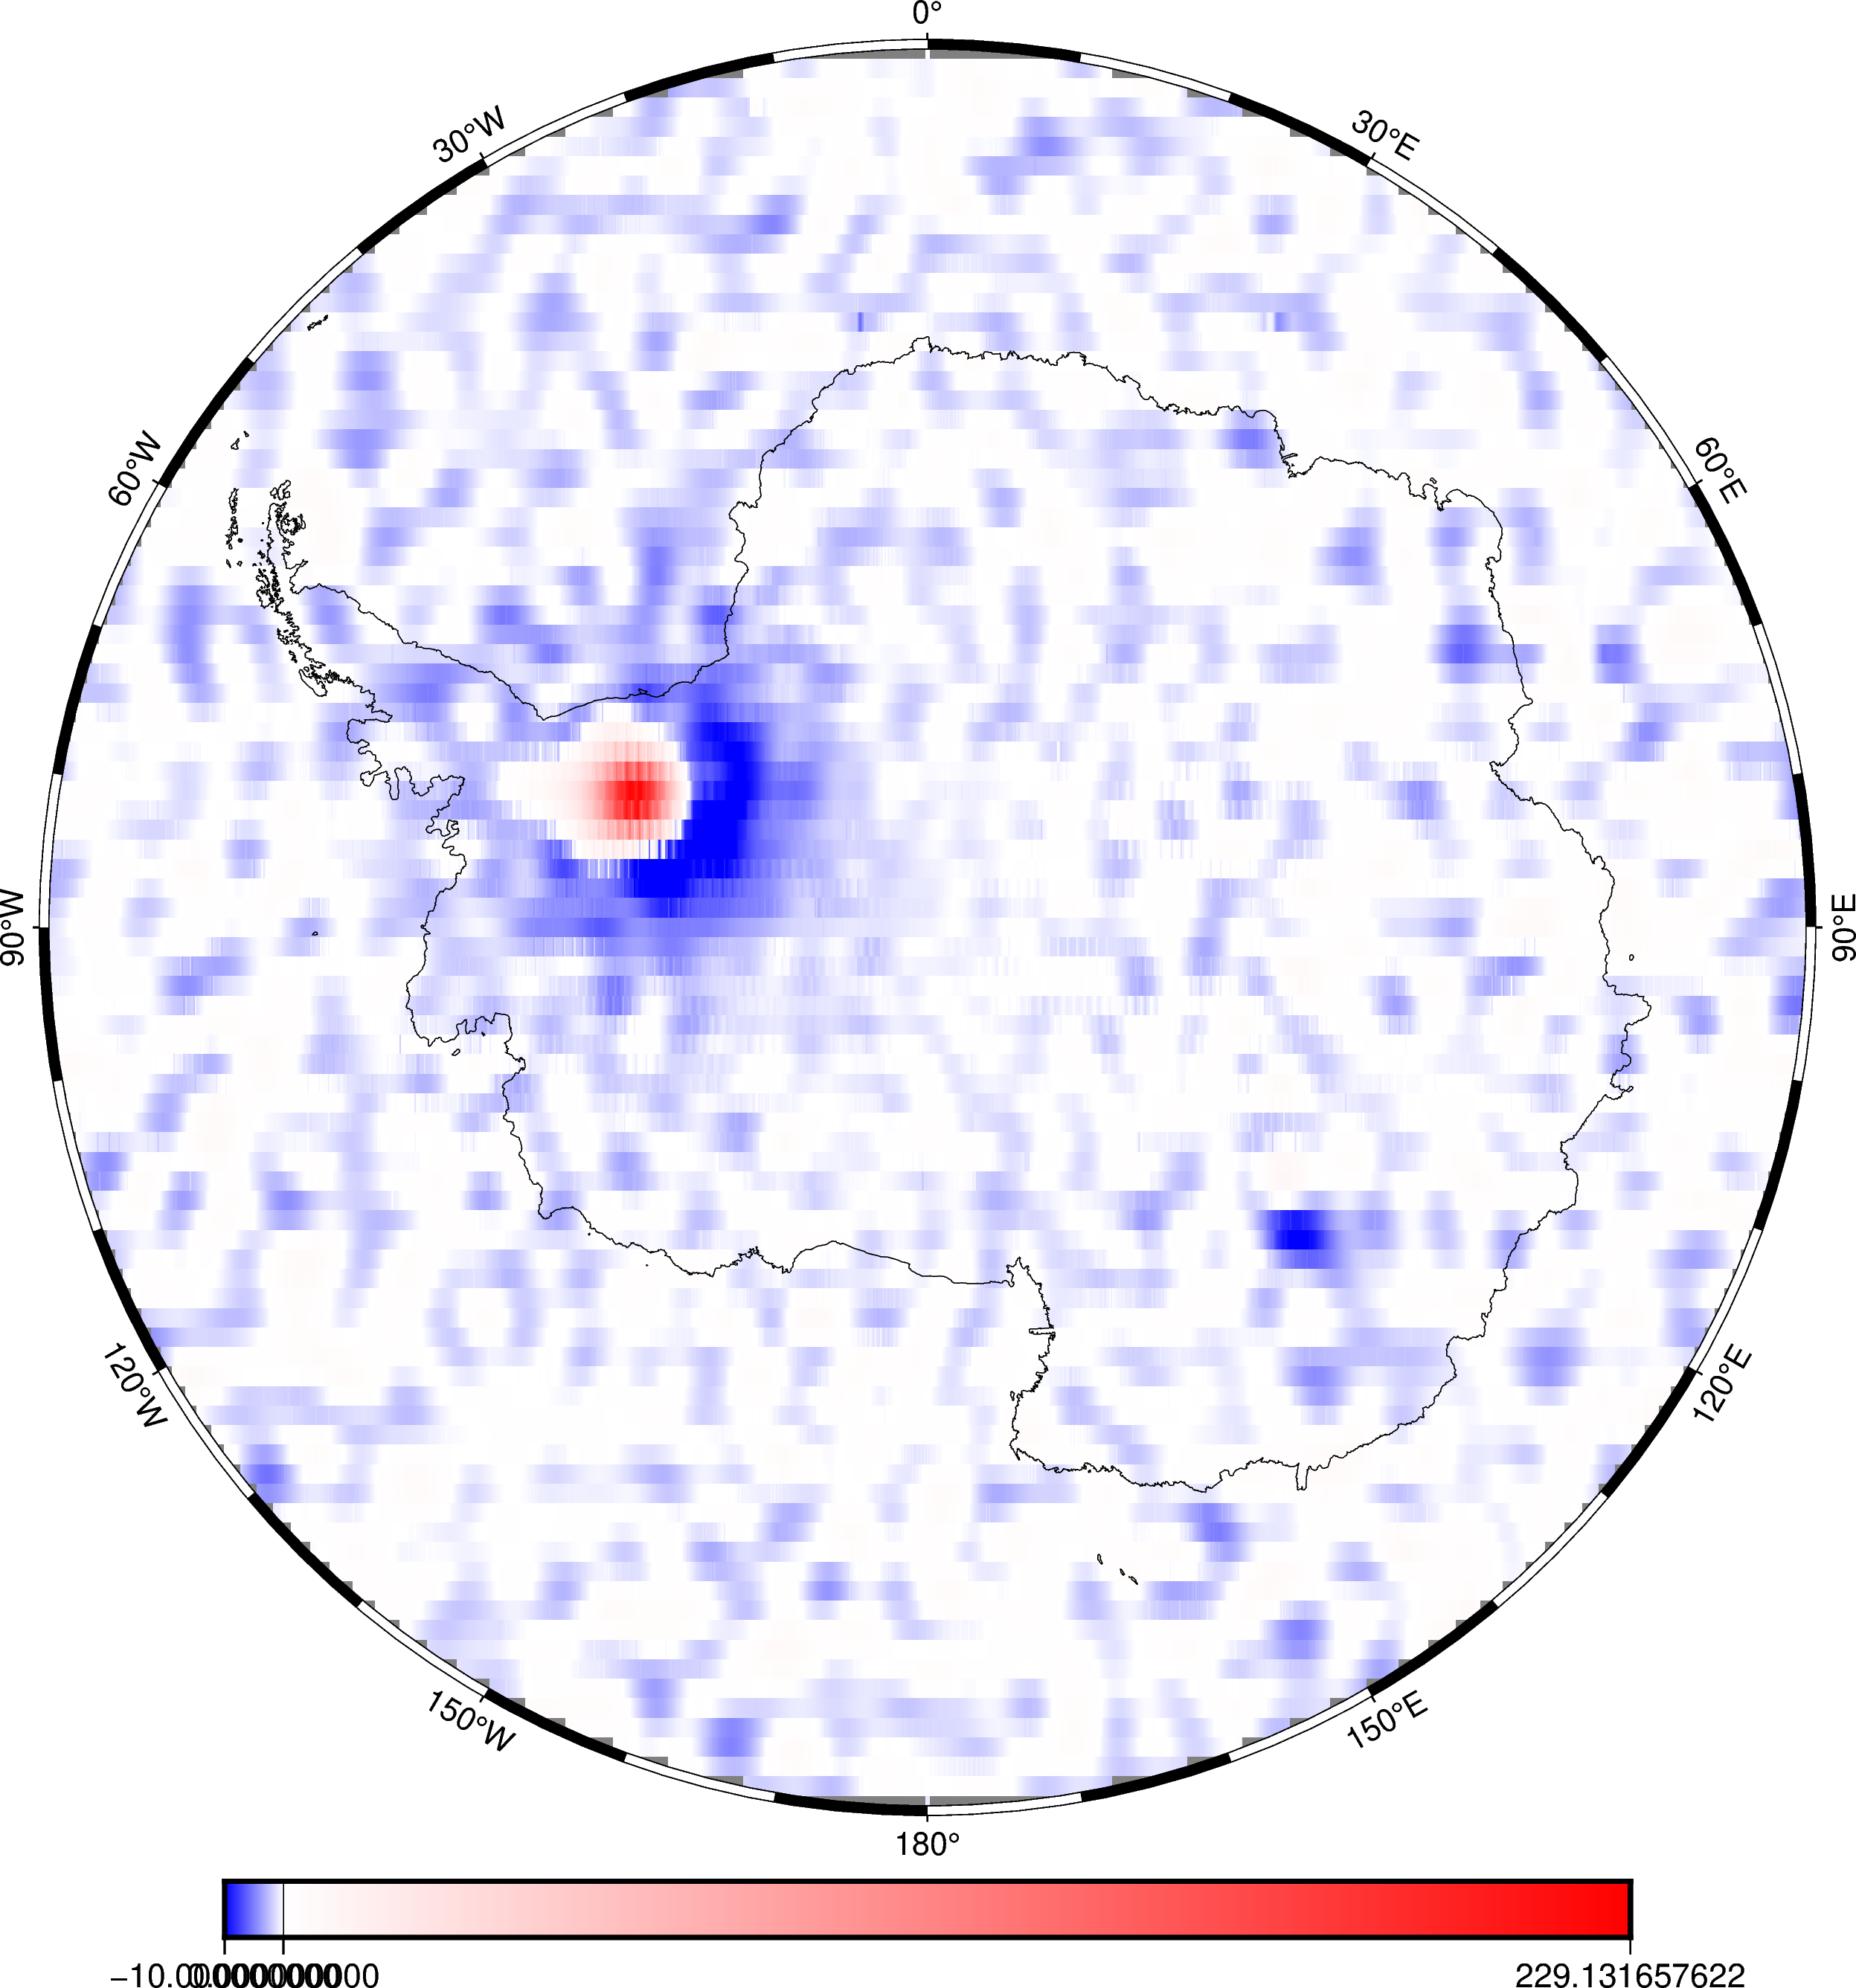

In [29]:
# Encontrar a escala global para os dois mapas preditos
# Calculamos o máximo absoluto para garantir que a escala "polar" (divergente) fique simétrica e igual

max_val_64 = np.nanmax(np.abs(total_field_anomaly_predicted_64))
max_val_32 = np.nanmax(np.abs(total_field_anomaly_predicted_32))

# Escolhemos o maior valor entre os dois
limite_escala = max(max_val_64, max_val_32)


# Criar e salvar o CPT fixo
pygmt.makecpt(
    cmap="polar+h", 
    series=[-10, limite_escala],  # 
    background=True,
    output="escala.cpt"
)

print("64 bits")
fig = pygmt.Figure()
fig.grdimage(
    total_field_anomaly_predicted_64, 
    cmap="escala.cpt", 
    frame=True, 
    projection="S0/-90/20c"
)
fig.colorbar(cmap="escala.cpt") 
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(
    total_field_anomaly_predicted_32, 
    cmap="escala.cpt", 
    frame=True, 
    projection="S0/-90/20c"
)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

Mapa de Diferença (64 bits vs 32 bits)


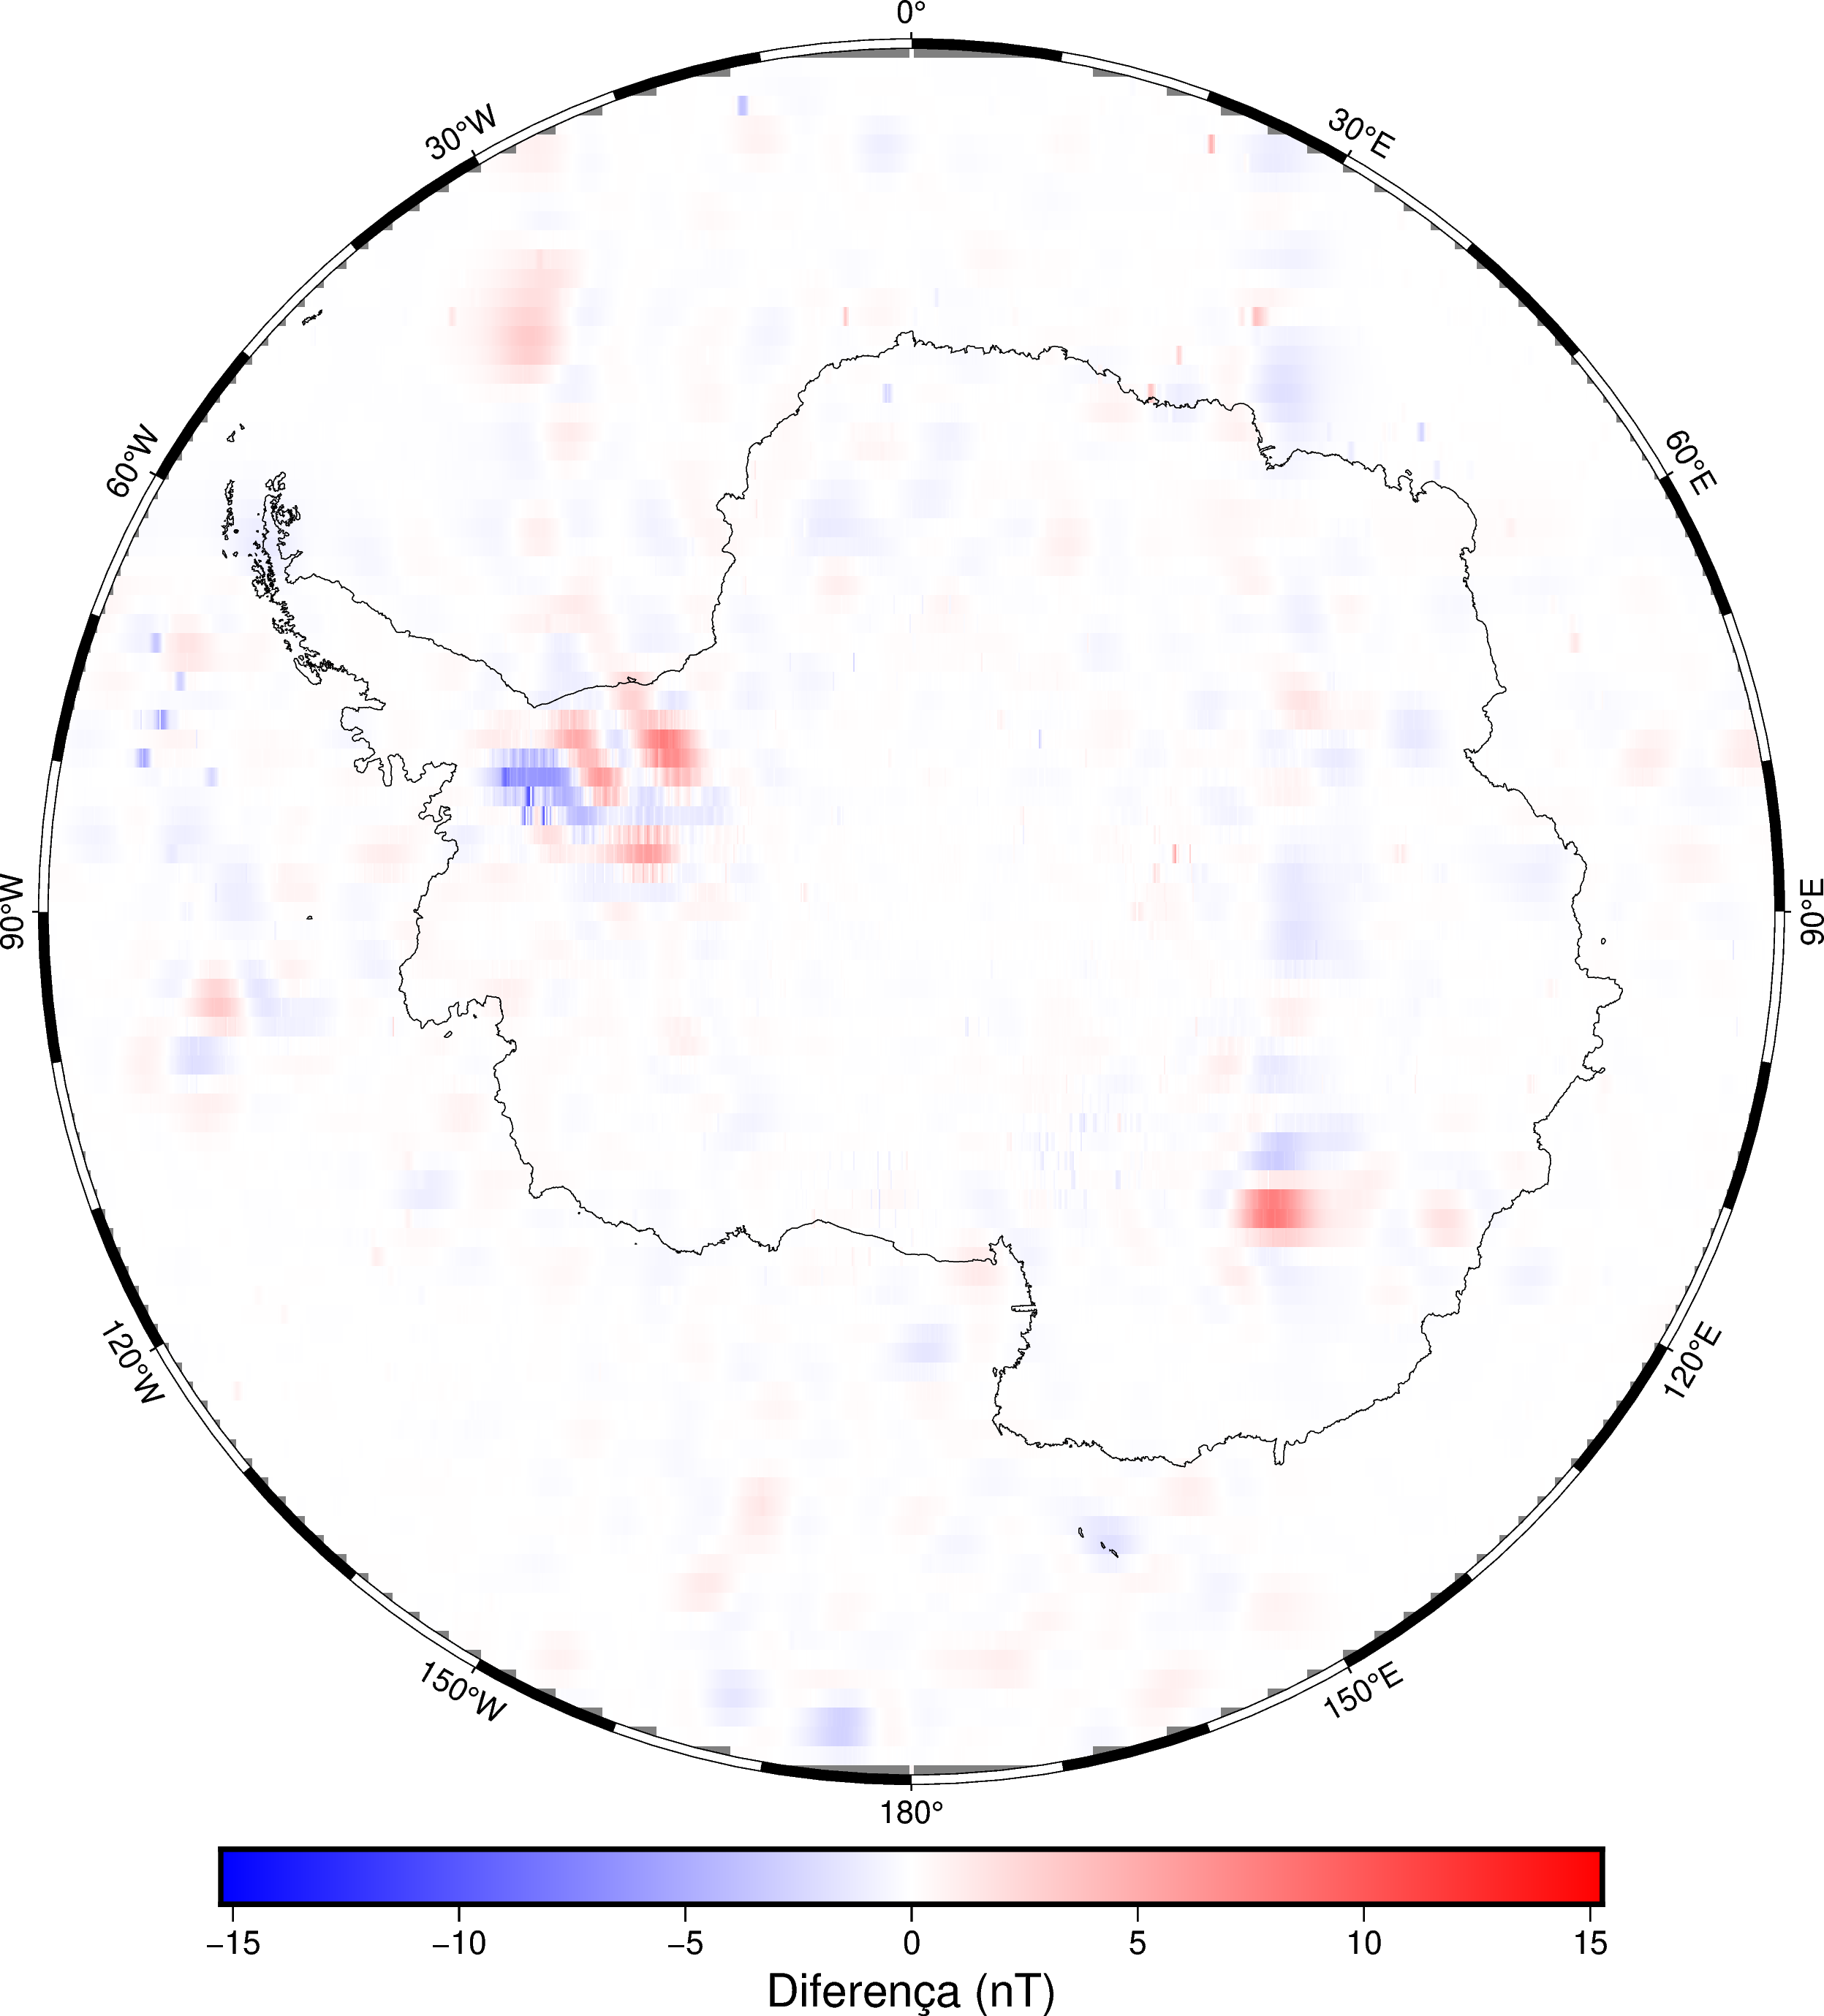

In [30]:
# Diferença entre o grid calculdado com 64 e 32 bits.

# Calcular o Grid da Diferença (64 bits - 32 bits)
# Isso mostra onde a precisão foi perdida ou alterada
diff_bits = total_field_anomaly_predicted_64 - total_field_anomaly_predicted_32

# Calcular a escala automática para essa diferença
# Usamos o máximo absoluto para garantir que o zero fique no centro (branco)
limite_diff = np.nanmax(np.abs(diff_bits))

# Criar e salvar o CPT específico para essa diferença
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_diff, limite_diff], 
    background=True,
    output="escala.cpt"
)

# 4. Plotar
print("Mapa de Diferença (64 bits vs 32 bits)")
fig = pygmt.Figure()
fig.grdimage(
    diff_bits, 
    cmap="escala.cpt", 
    frame=True,
    projection="S0/-90/20c"
)
fig.colorbar(
    cmap="escala.cpt", 
    frame=["a", "x+lDiferença (nT)"]
)
fig.coast(shorelines=True)
fig.show()

Diferença da precisão

In [31]:
# --- 1. Extração dos Dados Numéricos ---

valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---
mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: 0.2947367983202446
A Raiz do Erro Quadrático Médio (RMSE) é: 0.5429 nT
O erro dividido pela média dos valores absolutos dos dados é: 0.31490124855859053


Proporção entre quantidade de pontos de entrada e tamanho do grid

In [32]:
pontos_entrada = len(data)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)

10000
98371


Show the difference

64 bits


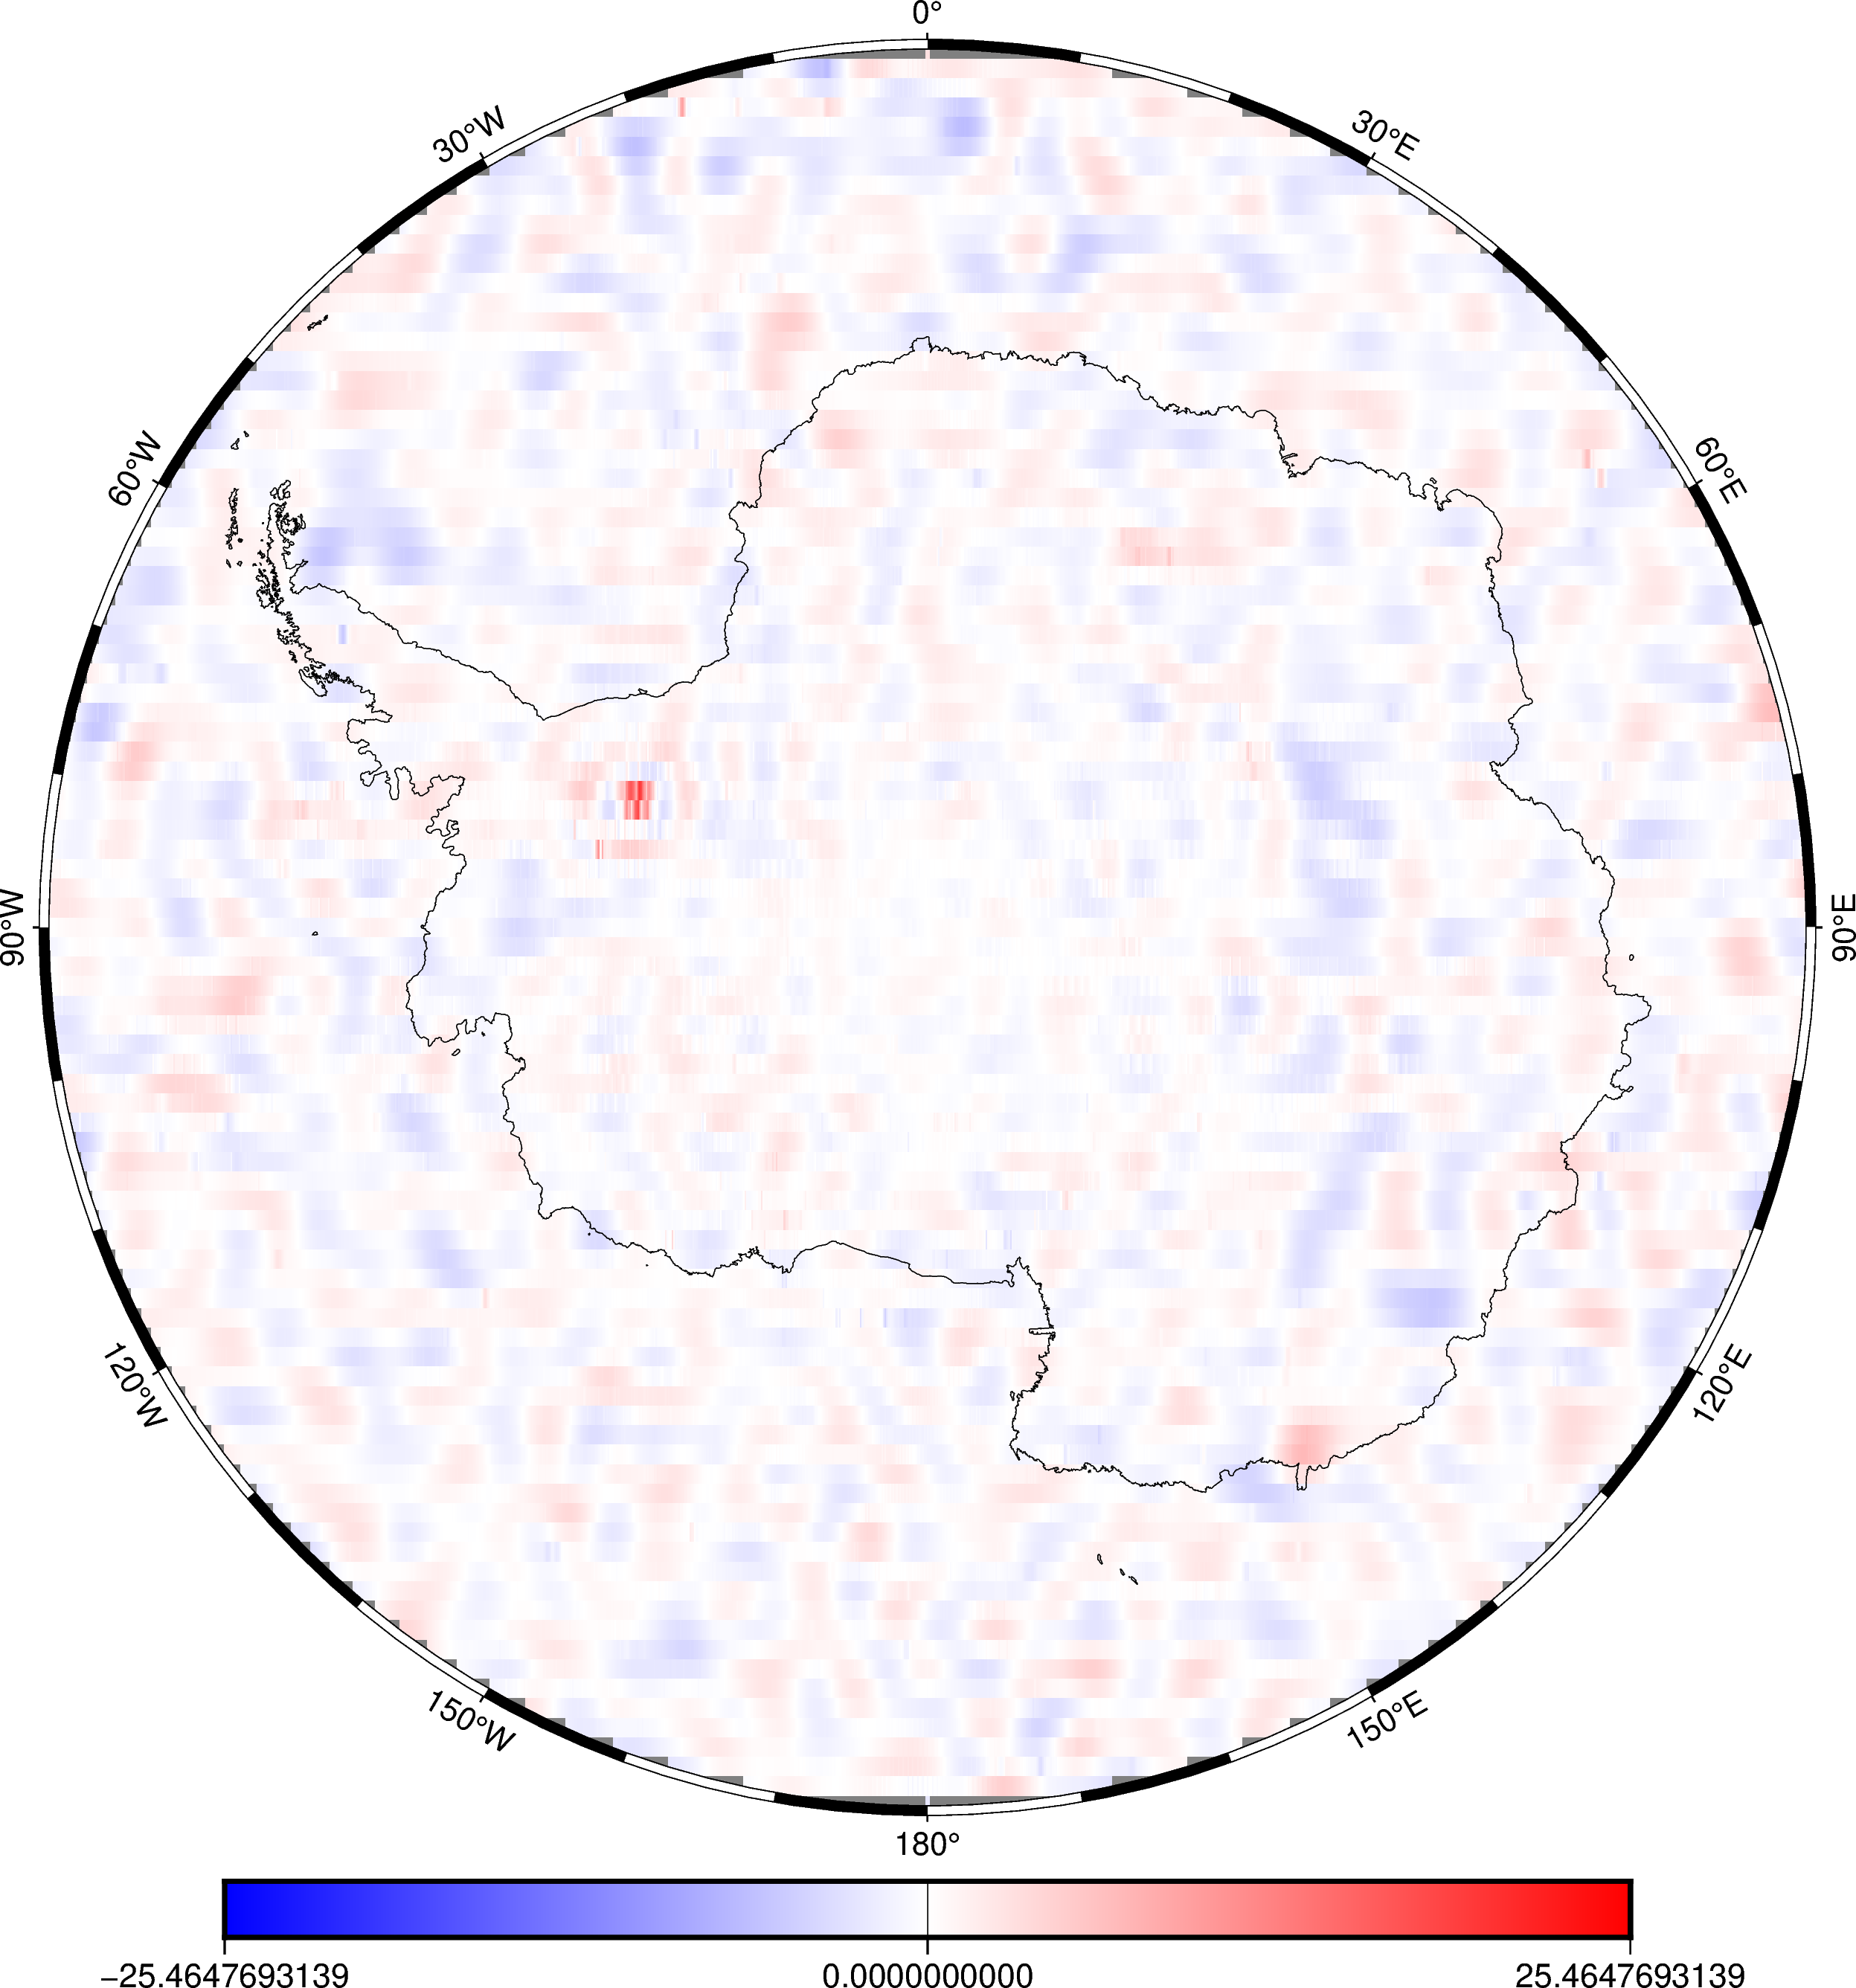

32 bits


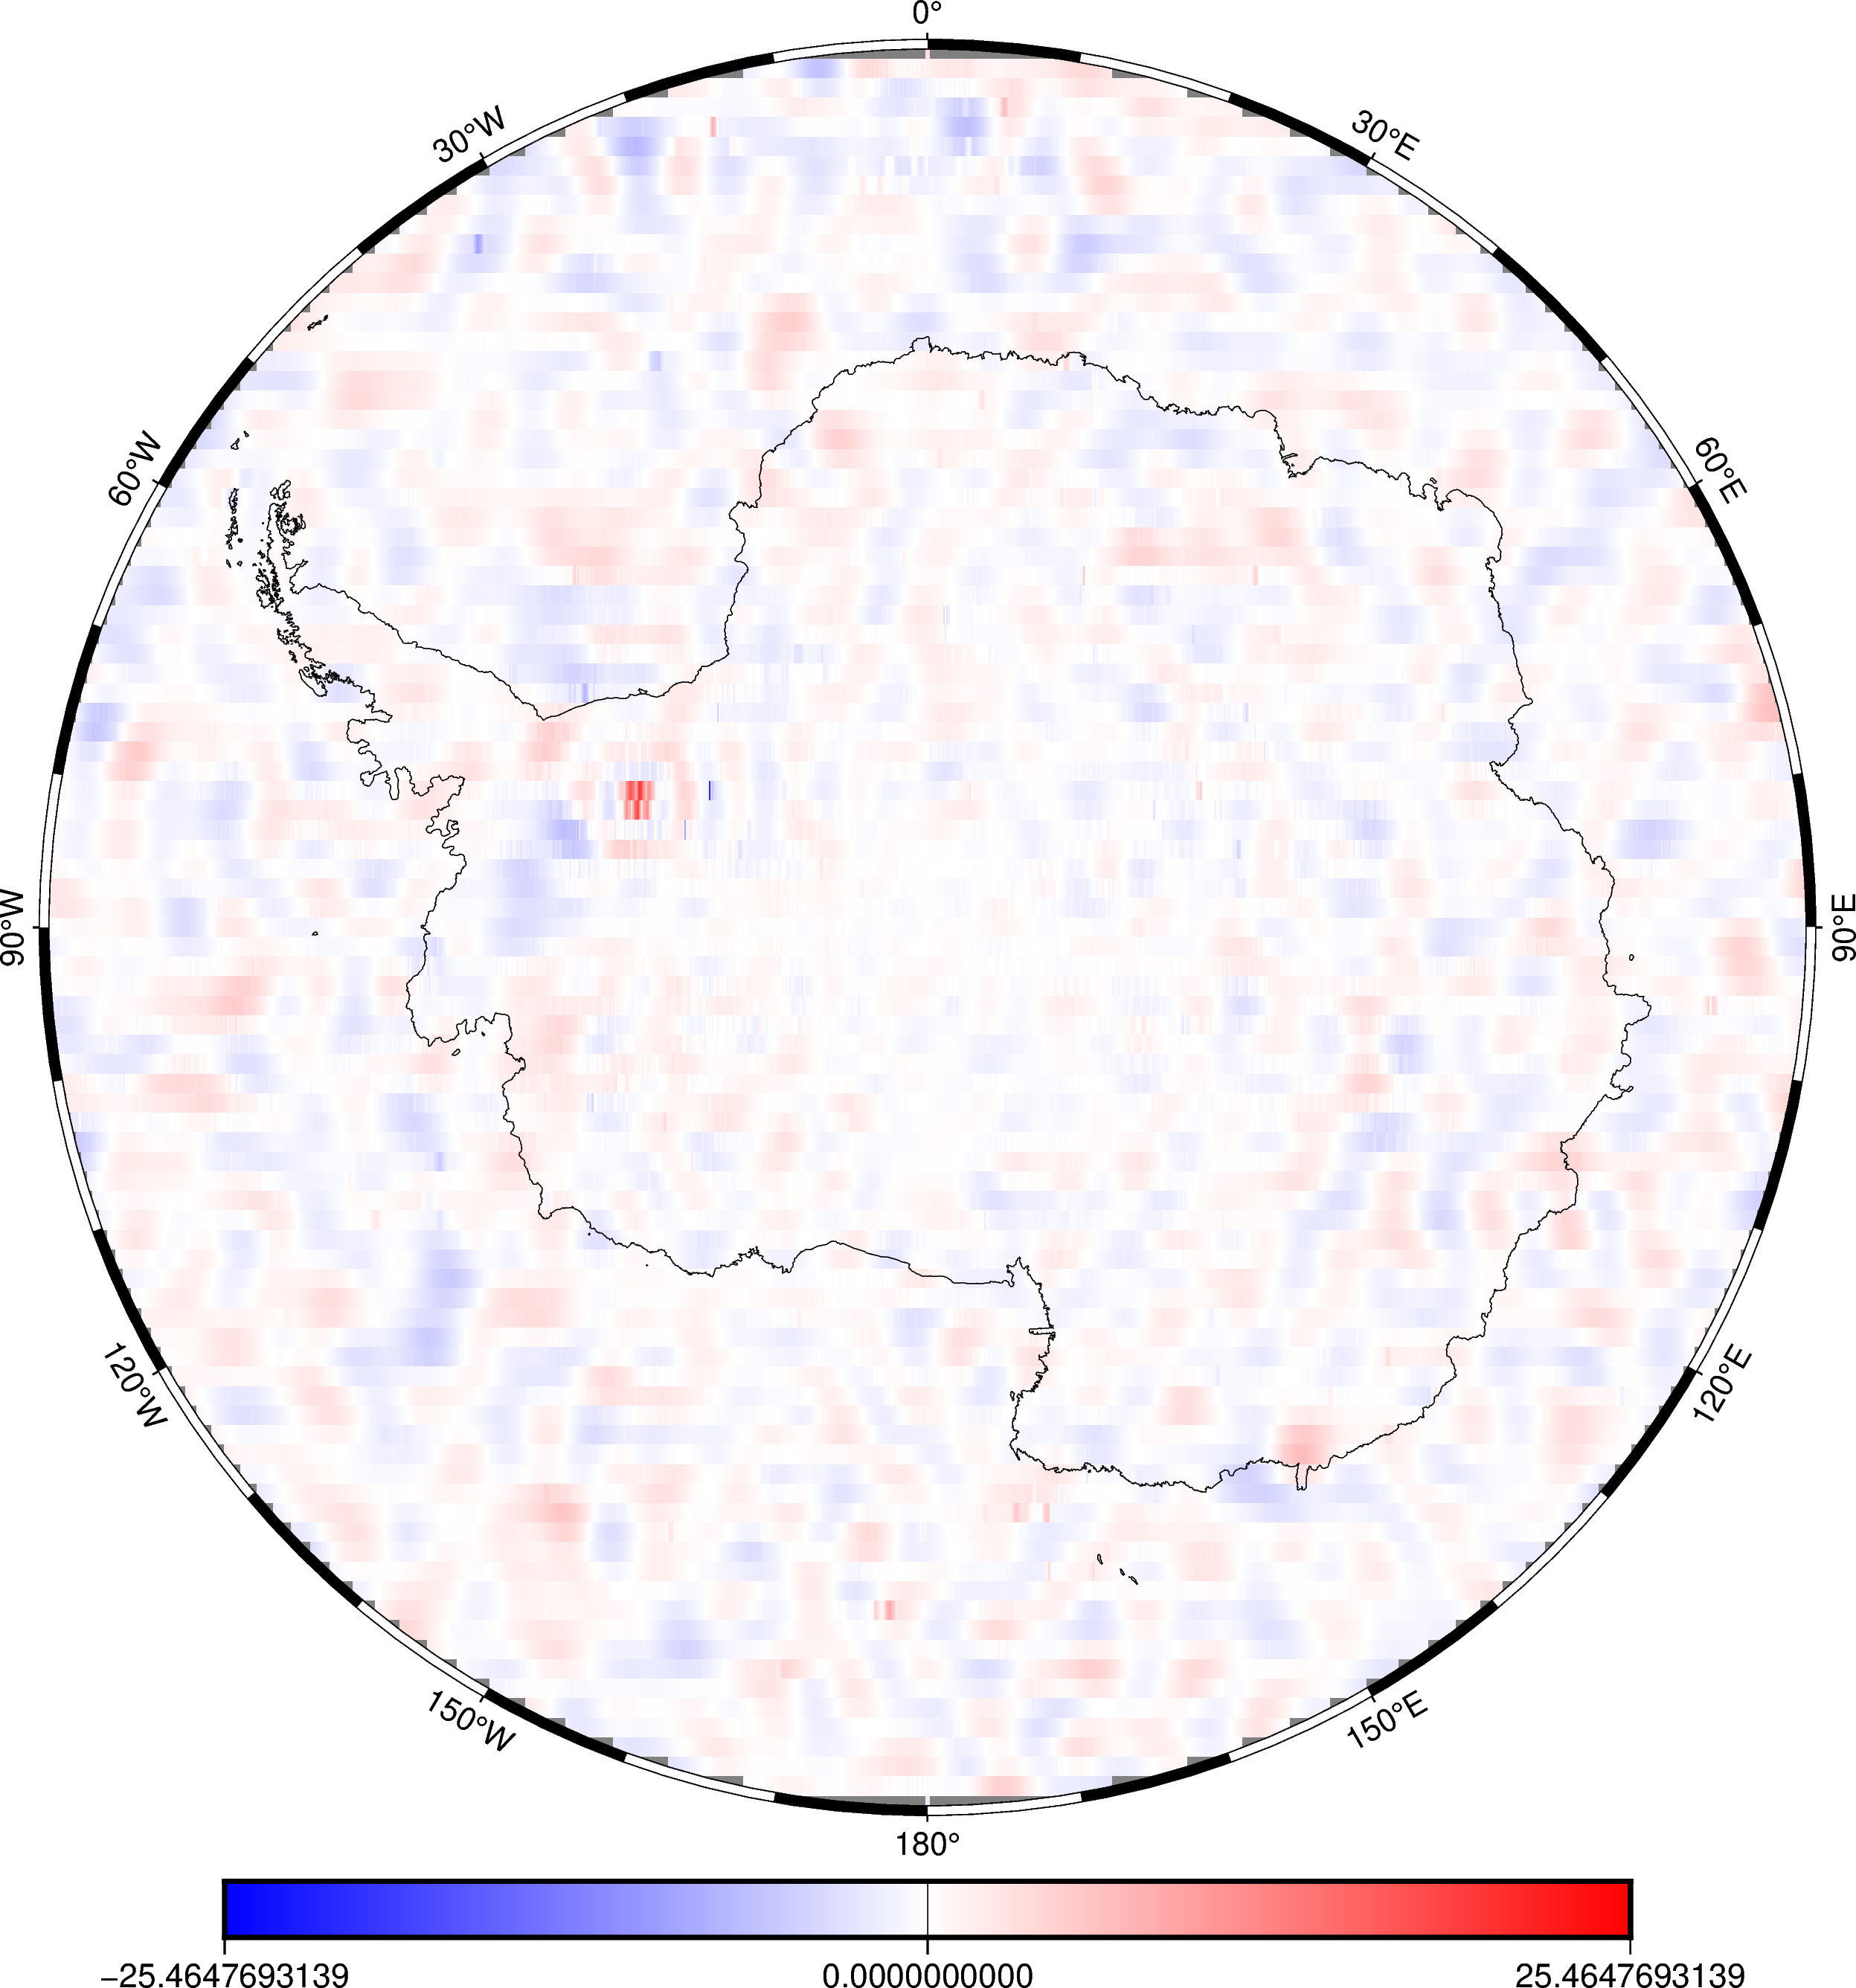

In [ ]:
# Calcule os grids de diferença antes
diff_64 = total_field_anomaly - total_field_anomaly_predicted_64
diff_32 = total_field_anomaly - total_field_anomaly_predicted_32

# Descubra a escala global (o maior erro absoluto entre os dois mapas)
# Usamos np.nanmax para ignorar NaNs se houver máscara
max_erro_64 = np.nanmax(np.abs(diff_64))
max_erro_32 = np.nanmax(np.abs(diff_32))

# O limite da escala deve ser o maior valor encontrado entre os dois casos
limite_escala = max(max_erro_64, max_erro_32)

# Criar e salvar o CPT fixo
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_escala, limite_escala], 
    background=True,
    output="escala.cpt"
)

print("64 bits")
fig = pygmt.Figure()
fig.grdimage(diff_64, frame=True ,cmap="escala_fixa.cpt", projection= "S0/-90/20c")
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()


print("32 bits")
fig = pygmt.Figure()
fig.grdimage(diff_32, frame=True ,cmap="escala_fixa.cpt", projection= "S0/-90/20c")
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()


Plot the windows.

64 bits


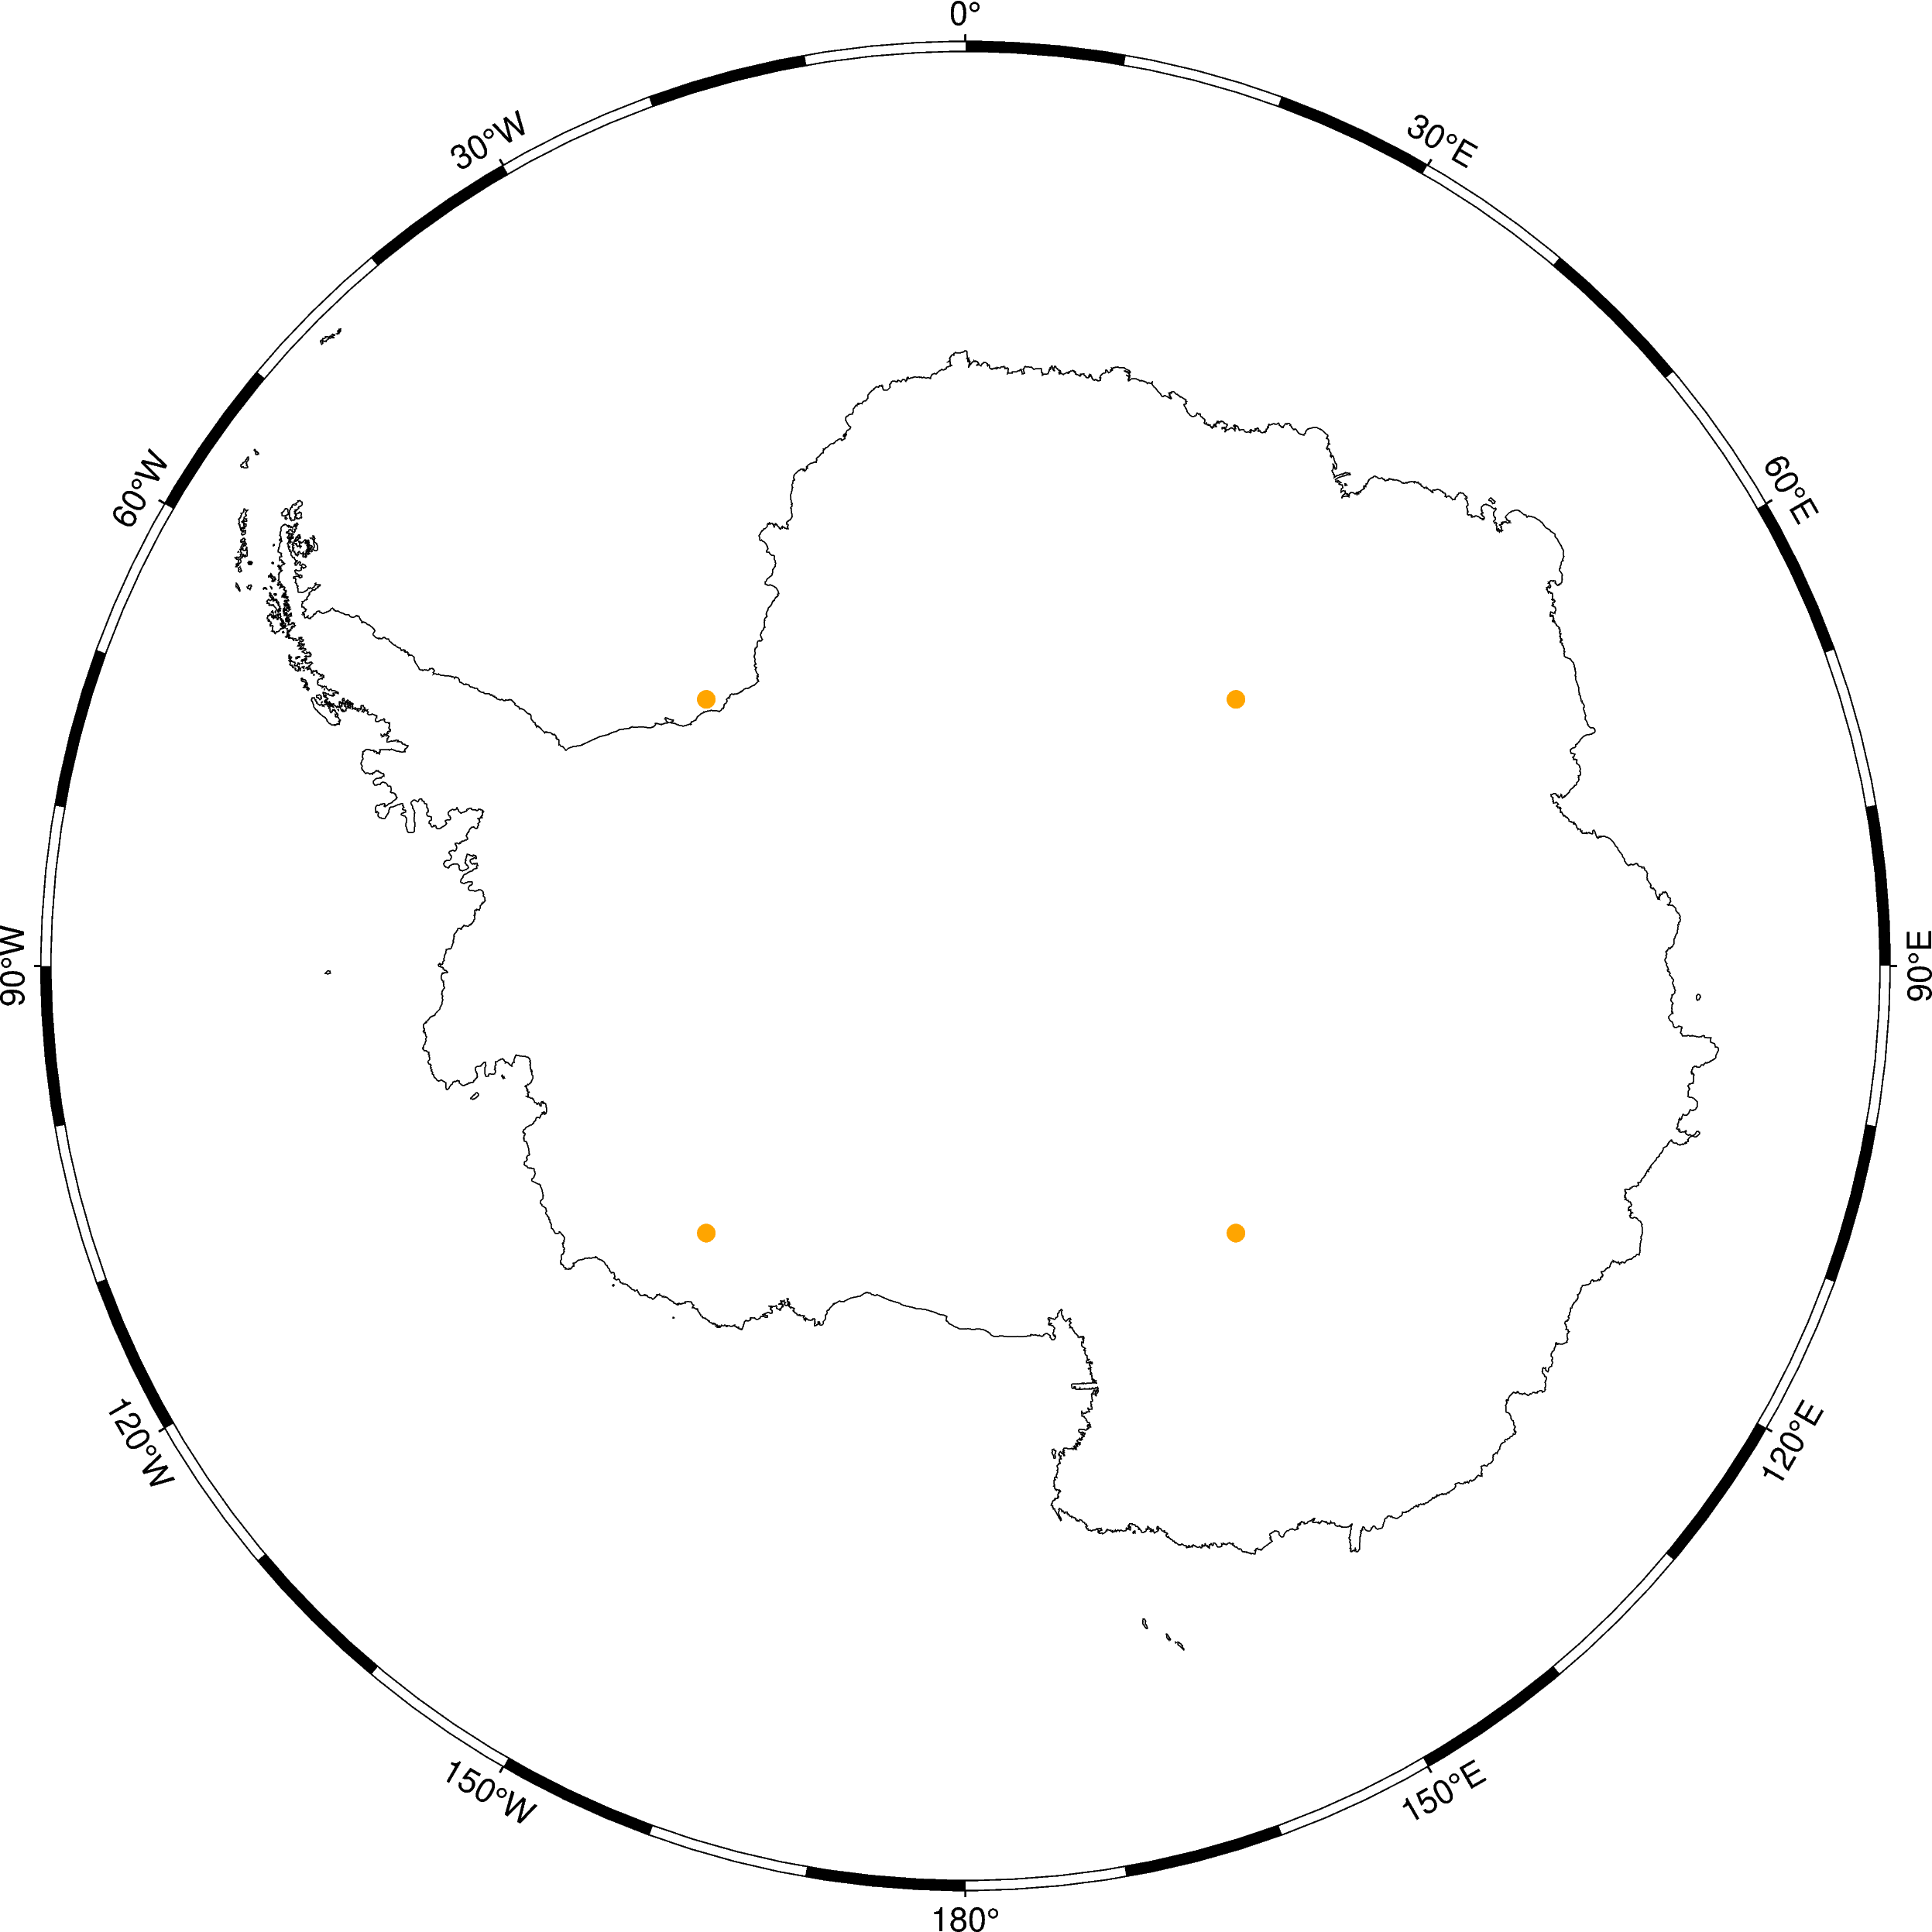

32 bits


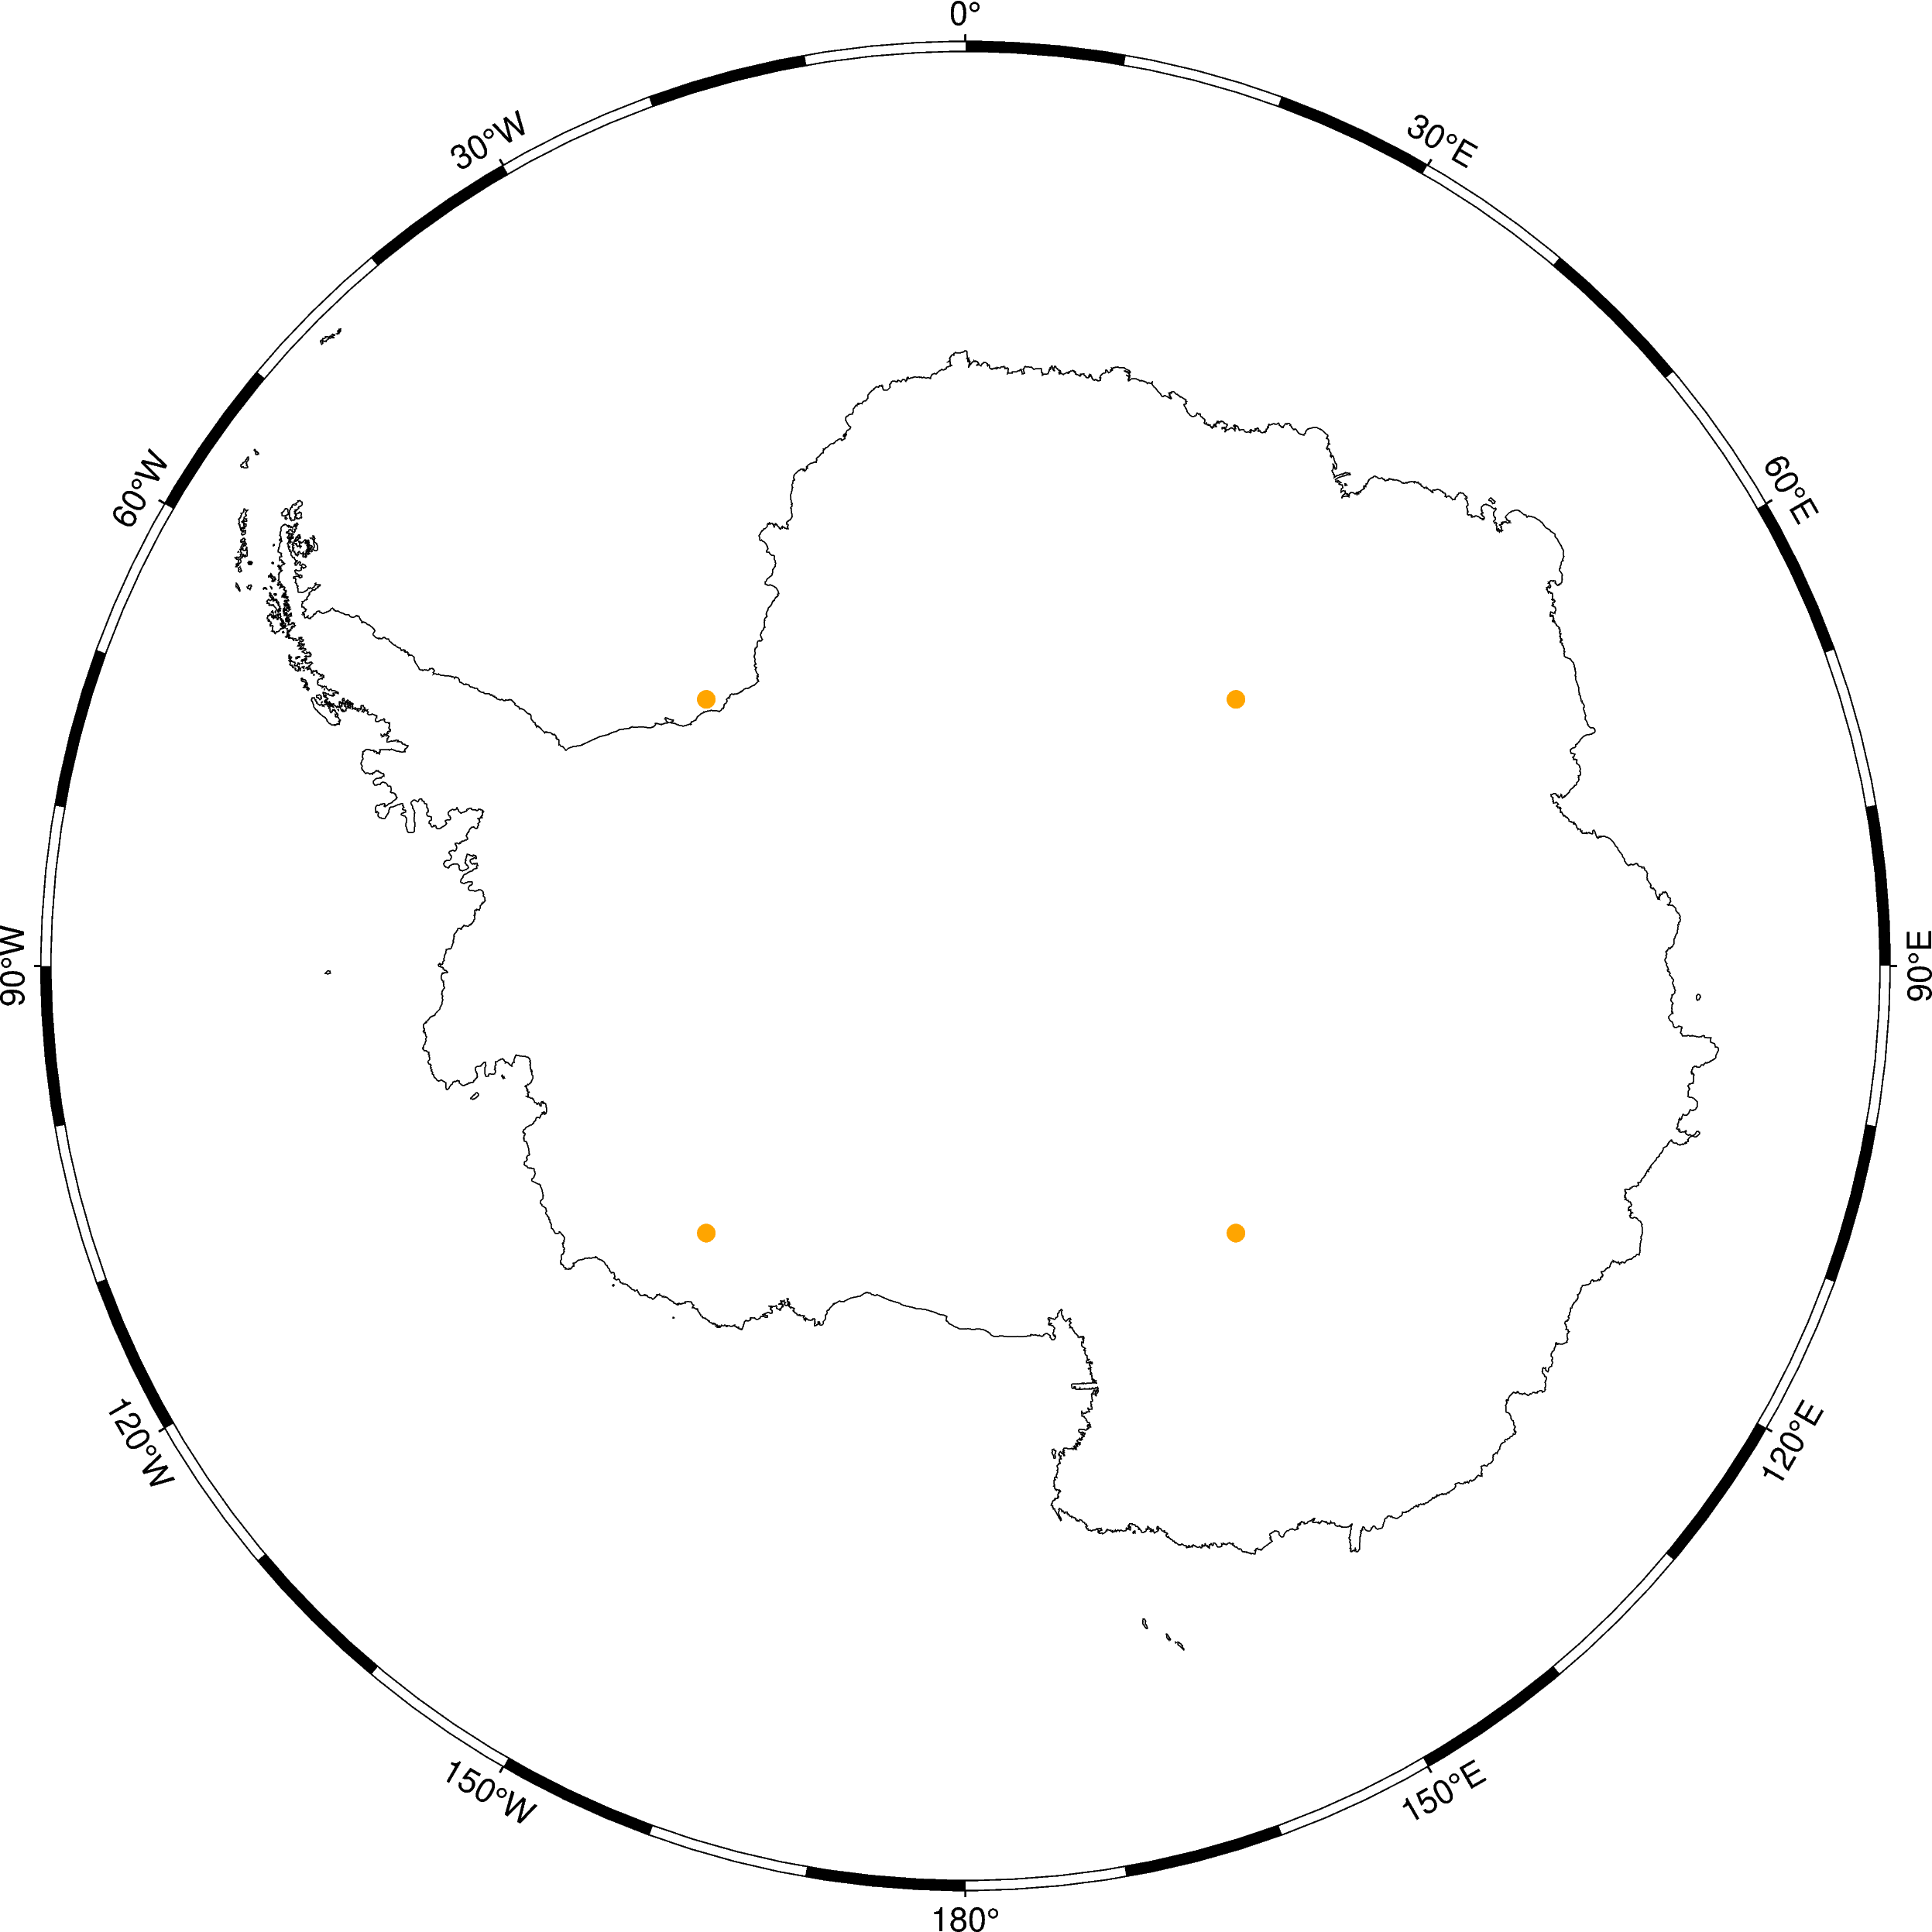

In [39]:
print("64 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_64.window_centers_[0].ravel(), y=eqs_64.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True, region=region,projection= "S0/-90/20c")
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_32.window_centers_[0].ravel(), y=eqs_32.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True, region=region,projection= "S0/-90/20c")
fig.coast(shorelines=True)
fig.show()